# 0.0 Imports

In [1]:
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import inflection

import plotly.graph_objects as go

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb

from IPython.display import Image
from IPython.core.display import HTML
import warnings
warnings.filterwarnings('ignore')

## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [253]:
def mean_absolute_percentage_error(y,yhat):
    return np.mean(np.abs((y-yhat) / y))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y,yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat)) 
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE':mae,
                        'RMSE':rmse}, index=[0])

def cross_validation(x_training, kfold, model_name, model, verbose=True):
    mae_list = []
    rmse_list = []
    for k in reversed(range(1,kfold+1)):
        if verbose:
            print('Kfold Number: {}'.format(k))
        # start and end date for validation
        validation_start_date = x_training.index.max() - datetime.timedelta(days=k*90)
        validation_end_date = x_training.index.max() - datetime.timedelta(days=(k-1)*90)

        # filtering dataset
        training = x_training[x_training.index < validation_start_date]
        validation = x_training[(x_training.index >= validation_start_date) & (x_training.index <= validation_end_date)]

        # training and validation dataset
        xtraining = training.drop(['daily_return_pct','symbol'], axis=1)
        ytraining = training['daily_return_pct']

        xvalidation = validation.drop(['daily_return_pct','symbol'],axis=1)
        yvalidation = validation['daily_return_pct']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, yvalidation, yhat) #np.expm1(yvalidation), np.expm1(yhat))

        # store perfomance of each kfold iteration
        mae_list.append(m_result['MAE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model':model_name,
        'MAE cv': np.round(np.mean(mae_list),5).astype(str) + '+/-' + np.round(np.std(mae_list),4).astype(str),
        'RMSE cv': np.round(np.mean(rmse_list),5).astype(str) + '+/-' + np.round(np.std(rmse_list),4).astype(str)}, index=[0])


def descriptive_statistics(num):
    # Central Tendency - mean, median

    ct1 = pd.DataFrame(num.apply(np.mean)).T
    ct2 = pd.DataFrame(num.apply(np.median)).T

    # Dispersion - std, min, max, range, skew, curtosis
    d1 = pd.DataFrame(num.apply(min)).T
    d2 = pd.DataFrame(num.apply(max)).T
    d3 = pd.DataFrame(num.apply(lambda x: x.max()-x.min())).T
    d4 = pd.DataFrame(num.apply(np.std)).T
    d5 = pd.DataFrame(num.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num.apply(lambda x: x.kurtosis())).T

    ctd = pd.concat([ct1,ct2,d1,d2,d3,d4,d5,d6]).T.reset_index()
    ctd.columns = ['features', 'mean','median','min','max','range','std','skew','kurtosis']
    return ctd


def plot_candles(asset_name, df, days):
    df = df.iloc[0:days]
    fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'])],
                layout=go.Layout(
                            title=go.layout.Title(text='{} Candlestick Chart from {}-{}-{} to {}-{}-{}'.format(asset_name, df.index[-1:].year[0],df.index[-1:].month[0], df.index[-1:].day[0],df.index[0].year, df.index[0].month,df.index[0].day))))
    return fig.show()

def plot_cum_return(asset_name, df):
    plt.title('{} Cumulative Return'.format(asset_name));
    (1+df[::-1].daily_return_pct).cumprod().plot();
    plt.xticks(rotation='45');
    return plt.show()
    
def plot_cumreturn_day_of_year(asset_name, df):
    plt.title('{} - Daily Return Cumulative Sum per Day of the Year'.format(asset_name))
    (1+df.groupby(df.index.day_of_year)['daily_return_pct'].mean()).cumprod().plot()
    return plt.show()

def plot_mean_month(asset_name, df):
    plt.title('{} - Mean Daily Return Percentage per Month'.format(asset_name))
    df.groupby(df.index.month)['daily_return_pct'].mean().plot.bar();
    return plt.show()
def plot_median_month(asset_name, df):
    plt.title('{} - Median Daily Return Percentage per Month'.format(asset_name))
    df.groupby(df.index.month).median()['daily_return_pct'].plot.bar()
    return plt.show()
def plot_daily_sum_per_month(asset_name, df, month):
    m = df[df.index.month==month]
    plt.title('{} - Daily Return Percentage Mean per Month ({})'.format(asset_name, month))
    m.groupby(m.index.day)['daily_return_pct'].sum().plot.bar()
    plt.xticks(rotation='45');
    return plt.show()
def concat_return(dolar, bova11, smal11, bitcoin, ether):
    full_return_pct = dolar[['daily_return_pct']].copy()
    full_return_pct.rename(columns= {'daily_return_pct':'dolar'}, inplace=True)
    full_return_pct = full_return_pct.merge(bova11.daily_return_pct, left_index=True, right_index=True, how='outer')
    full_return_pct.rename(columns= {'daily_return_pct':'bova11'}, inplace=True)
    full_return_pct = full_return_pct.merge(smal11.daily_return_pct, left_index=True, right_index=True, how='outer')
    full_return_pct.rename(columns= {'daily_return_pct':'smal11'}, inplace=True)
    full_return_pct = full_return_pct.merge(bitcoin.daily_return_pct, left_index=True, right_index=True, how='outer')
    full_return_pct.rename(columns= {'daily_return_pct':'bitcoin'}, inplace=True)
    full_return_pct = full_return_pct.merge(ether.daily_return_pct, left_index=True, right_index=True, how='outer')
    full_return_pct.rename(columns= {'daily_return_pct':'ether'}, inplace=True)
    return full_return_pct
def plot_volatility(asset_name, df):
    plt.subplot(2,1,1)
    print('{} Standard Deviation: {}'.format(asset_name, df.daily_return_pct.std().round(5)))
    plt.title('{} - Daily Return Percentage - Histogram '.format(asset_name));
    df.daily_return_pct.hist();
    plt.tight_layout();

    plt.subplot(2,1,2)
    plt.title('{} - Daily Return Percentage - Volatility Moving Average (30 days)'.format(asset_name));
    df.daily_return_pct.rolling(window=30).std().plot();
    plt.tight_layout();
    return plt.show()

def merge_returns(d2):
    if d2 is dolar_f:
        d2 = pd.merge(left= dolar_f, right= bova11.daily_return_pct, left_index=True, right_index=True, how='outer')
        d2.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'bova11'}, inplace=True)
        d2 = pd.merge(left= d2, right= smal11.daily_return_pct, left_index=True, right_index=True,how='outer')
        d2.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'smal11'}, inplace=True)
        d2 = pd.merge(left= d2, right= bitcoin.daily_return_pct, left_index=True, right_index=True,how='outer')
        d2.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'bitcoin'}, inplace=True)
        d2 = pd.merge(left= d2, right= ether.daily_return_pct, left_index=True, right_index=True,how='outer')
        d2.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'ether'}, inplace=True)
        d2 = d2[d2['daily_return_pct'].notna()]
        d2.fillna(method='ffill', inplace=True)
        d2.fillna(0, inplace=True)

    elif d2 is bova11_f:
        # Bova11
        d2 = pd.merge(left= bova11_f, right= dolar.daily_return_pct, left_index=True, right_index=True, how='left')
        d2.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'dolar'}, inplace=True)
        d2 = pd.merge(left= d2, right= smal11.daily_return_pct, left_index=True, right_index=True,how='left')
        d2.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'smal11'}, inplace=True)
        d2 = pd.merge(left= d2, right= bitcoin.daily_return_pct, left_index=True, right_index=True,how='left')
        d2.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'bitcoin'}, inplace=True)
        d2 = pd.merge(left= d2, right= ether.daily_return_pct, left_index=True, right_index=True,how='left')
        d2.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'ether'}, inplace=True)
        d2 = d2[d2['daily_return_pct'].notna()]
        d2.fillna(method='ffill', inplace=True)
        d2.fillna(0, inplace=True)
    
    elif d2 is smal11_f:
        # Smal11
        d2 = pd.merge(left= smal11_f, right= dolar.daily_return_pct, left_index=True, right_index=True, how='left')
        d2.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'dolar'}, inplace=True)

        d2 = pd.merge(left= d2, right= bova11.daily_return_pct, left_index=True, right_index=True,how='left')
        d2.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'bova11'}, inplace=True)

        d2 = pd.merge(left= d2, right= bitcoin.daily_return_pct, left_index=True, right_index=True,how='left')
        d2.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'bitcoin'}, inplace=True)

        d2 = pd.merge(left= d2, right= ether.daily_return_pct, left_index=True, right_index=True,how='left')
        d2.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'ether'}, inplace=True)

        d2 = d2[d2['daily_return_pct'].notna()]
        d2.fillna(method='ffill', inplace=True)
        d2.fillna(0, inplace=True)

    elif d2 is bitcoin_f:
        # Bitcoin
        d2 = pd.merge(left= bitcoin_f, right= dolar.daily_return_pct, left_index=True, right_index=True, how='left')
        d2.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'dolar'}, inplace=True)

        d2 = pd.merge(left= d2, right= bova11.daily_return_pct, left_index=True, right_index=True,how='left')
        d2.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'bova11'}, inplace=True)

        d2 = pd.merge(left= d2, right= smal11.daily_return_pct, left_index=True, right_index=True,how='left')
        d2.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'smal11'}, inplace=True)

        d2 = pd.merge(left= d2, right= ether.daily_return_pct, left_index=True, right_index=True,how='left')
        d2.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'ether'}, inplace=True)

        d2 = d2[d2['daily_return_pct'].notna()]
        d2.fillna(method='ffill', inplace=True)
        d2.fillna(0, inplace=True)

    elif d2 is ether_f:
        # Ether
        d2 = pd.merge(left= ether_f, right= dolar.daily_return_pct, left_index=True, right_index=True, how='left')
        d2.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'dolar'}, inplace=True)

        d2 = pd.merge(left= d2, right= bova11.daily_return_pct, left_index=True, right_index=True,how='left')
        d2.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'bova11'}, inplace=True)

        d2 = pd.merge(left= d2, right= smal11.daily_return_pct, left_index=True, right_index=True,how='left')
        d2.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'smal11'}, inplace=True)

        d2 = pd.merge(left= d2, right= bitcoin.daily_return_pct, left_index=True, right_index=True,how='left')
        d2.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'bitcoin'}, inplace=True)

        d2 = d2[d2['daily_return_pct'].notna()]
        d2.fillna(method='ffill', inplace=True)
        d2.fillna(0, inplace=True)
    
    return d2[::-1]

def merge_indicators(d):
    if d is dolar:
        d = pd.merge(left= dolar, right= selic.taxa_selic, left_index=True, right_index=True, how='left')
        d.fillna(method='ffill', inplace=True)
        d.fillna(8.65000, inplace=True) 
        d = pd.merge(left= d, right= ipca.ipca, left_index=True, right_index=True, how='left')
        d.fillna(method='ffill', inplace=True)
        d.fillna(0.78000, inplace=True)
        d = pd.merge(left= d, right= indice_di.indice_di, left_index=True, right_index=True, how='left')
        d.fillna(method='ffill', inplace=True) 
        d.fillna(0.59000, inplace=True) 
    if d is bova11:
        d = pd.merge(left= bova11, right= selic.taxa_selic, left_index=True, right_index=True, how='left')
        d.fillna(method='ffill', inplace=True)
        d.fillna(11.17000, inplace=True) 
        d = pd.merge(left= d, right= ipca.ipca, left_index=True, right_index=True, how='left')
        d.fillna(method='ffill', inplace=True)
        d.fillna(0.80000, inplace=True)
        d = pd.merge(left= d, right= indice_di.indice_di, left_index=True, right_index=True, how='left')
        d.fillna(method='ffill', inplace=True) 
        d.fillna(0.84000, inplace=True)
    if d is smal11:
        d = pd.merge(left= bova11, right= selic.taxa_selic, left_index=True, right_index=True, how='left')
        d.fillna(method='ffill', inplace=True)
        d.fillna(11.17000, inplace=True) 
        d = pd.merge(left= d, right= ipca.ipca, left_index=True, right_index=True, how='left')
        d.fillna(method='ffill', inplace=True)
        d.fillna(0.80000, inplace=True)
        d = pd.merge(left= d, right= indice_di.indice_di, left_index=True, right_index=True, how='left')
        d.fillna(method='ffill', inplace=True) 
        d.fillna(0.84000, inplace=True)
    if d is bitcoin:
        d = pd.merge(left= bitcoin, right= selic.taxa_selic, left_index=True, right_index=True, how='left')
        d.fillna(method='ffill', inplace=True)
        d.fillna(11.17000, inplace=True) 
        d = pd.merge(left= d, right= ipca.ipca, left_index=True, right_index=True, how='left')
        d.fillna(method='ffill', inplace=True)
        d.fillna(0.83000, inplace=True)
        d = pd.merge(left= d, right= indice_di.indice_di, left_index=True, right_index=True, how='left')
        d.fillna(method='ffill', inplace=True) 
        d.fillna(0.86000, inplace=True) 
    if d is ether:
        d = pd.merge(left= ether, right= selic.taxa_selic, left_index=True, right_index=True, how='left')
        d.fillna(method='ffill', inplace=True)
        d.fillna(14.15000, inplace=True) 
        d = pd.merge(left= d, right= ipca.ipca, left_index=True, right_index=True, how='left')
        d.fillna(method='ffill', inplace=True)
        d.fillna(0.54000, inplace=True)
        d = pd.merge(left= d, right= indice_di.indice_di, left_index=True, right_index=True, how='left')
        d.fillna(method='ffill', inplace=True) 
        d.fillna(1.11000, inplace=True)
    
    return d[::-1]

def hyp_monte_carlo(full_return_pct):
    # Requeried inputs
    yearly_mean_return = full_return_pct.mean() *252
    yearly_cov = daily_cov*252
    num_assets = full_return_pct.shape[1]
    
    # Hypothetical portfolios' weights
    hyp_portf_weitghs = [[0,0.5,0.5,0,0], [0,0,0,0.5,0.5], [0.4,0.3,0,0,0.3], [1,0,0,0,0,], [0.2,0.2,0.2,0.2,0.2]]
    
    port_returns = []
    port_volatility = []
    stock_weights = []
    for port_weight in hyp_portf_weitghs:
        port_weight = np.array(port_weight)
        returns = np.dot(port_weight, yearly_mean_return)
        volatility = np.sqrt(np.dot(port_weight.T, np.dot(yearly_cov, port_weight)))
        
        # # Monte Carlo's output
        port_returns.append(returns)
        port_volatility.append(volatility)
        stock_weights.append(port_weight)
    # Create dict for final dataframe
    portfolio = {'returns': port_returns, 'volatility': port_volatility, 'return_risk_ratio': ((value/ port_volatility[count]) for count, value in enumerate(port_returns))}
    # Create weight columns
    for counter, symbol in enumerate(full_return_pct.columns):
        portfolio[symbol + '_weight'] = [weight[counter] for weight in stock_weights]
    # Create final dataframe
    port = pd.DataFrame(portfolio)
    # Create investment profile column
    port['invest_profile'] = ['National', 'Crypto', 'Foreign', 'Dolar_Only', 'Balanced']
    return port

def monte_carlo(full_return_pct, num_portfolios):
    # Requeried inputs
    yearly_mean_return = full_return_pct.mean() *252
    daily_cov = full_return_pct.cov()
    yearly_cov = daily_cov*252
    num_assets = full_return_pct.shape[1]
    num_portfolios = num_portfolios
    
    port_returns = []
    port_volatility = []
    stock_weights = []
    for single_portfolio in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        returns = np.dot(weights, yearly_mean_return)
        volatility = np.sqrt(np.dot(weights.T, np.dot(yearly_cov, weights)))
        
        # # Monte Carlo's output
        port_returns.append(returns)
        port_volatility.append(volatility)
        stock_weights.append(port_weight)
        
    # Create dict for final dataframe
    portfolio = {'returns': port_returns, 'volatility': port_volatility, 'return_risk_ratio': ((value/ port_volatility[count]) for count, value in enumerate(port_returns))}
    # Create weight columns
    for counter, symbol in enumerate(full_return_pct.columns):
        portfolio[symbol + '_weight'] = [weight[counter] for weight in stock_weights]
    # Create final dataframe
    port = pd.DataFrame(portfolio)
    port.sort_values(by='returns', ascending=False, inplace=True)
    
    return port


## 0.2 Load Data

In [256]:
selic = pd.read_csv('..\data\selic.csv')
selic.drop('Unnamed: 0', axis=1, inplace=True)
indice_di = pd.read_csv('..\data\indice_di.csv')
indice_di.drop('Unnamed: 0', axis=1, inplace=True)
ipca = pd.read_csv('..\data\ipca.csv')
ipca.drop('Unnamed: 0', axis=1, inplace=True)
dolar = pd.read_csv('..\data\dolar.csv')
dolar.drop('Unnamed: 0', axis=1, inplace=True)
bova11 = pd.read_csv('..\data\\bova11.csv')
bova11.drop('Unnamed: 0', axis=1, inplace=True)
smal11 = pd.read_csv('..\data\smal11.csv')
smal11.drop('Unnamed: 0', axis=1, inplace=True)
bitcoin = pd.read_csv('..\data\\bitcoin.csv')
bitcoin.drop('Unnamed: 0', axis=1, inplace=True)
ether = pd.read_csv('..\data\ether.csv')
ether.drop('Unnamed: 0', axis=1, inplace=True)

# Add stock label
dolar['Ativo'] = 'DOLAR'
bova11['Ativo'] = 'BOVA11'
smal11['Ativo'] = 'SMAL11'
bitcoin['Ativo'] = 'BITCOIN'
ether['Ativo'] = 'ETHER'

# Rename columns
new_cols = ['date','close', 'daily_variation','daily_return_pct', 'open', 'high', 'low', 'volume','symbol']
for df in [dolar, bova11, smal11, bitcoin, ether]:
    df.columns = new_cols
    # Set Date as index
    df.set_index('date', inplace=True)
    
# Inverse Ether dataframe time order
ether = ether[::-1]

# 1.0 Data Description

## 1.1 Data Dimensions

In [5]:
print(' Selic Dataframe has {} rows and {} columns'.format(selic.shape[0], selic.shape[1]))
print(' IPCA Dataframe has {} rows and {} columns'.format(ipca.shape[0], ipca.shape[1]))
print(' Indice DI Dataframe has {} rows and {} columns'.format(indice_di.shape[0], indice_di.shape[1]))
print(' Dolar Dataframe has {} rows and {} columns'.format(dolar.shape[0], dolar.shape[1]))
print(' BOVA11 Dataframe has {} rows and {} columns'.format(bova11.shape[0], bova11.shape[1]))
print(' SMAL11 Dataframe has {} rows and {} columns'.format(smal11.shape[0], smal11.shape[1]))
print(' Bitcoin Dataframe has {} rows and {} columns'.format(bitcoin.shape[0], bitcoin.shape[1]))
print(' Ether Dataframe has {} rows and {} columns'.format(ether.shape[0], ether.shape[1]))


 Selic Dataframe has 246 rows and 7 columns
 IPCA Dataframe has 486 rows and 2 columns
 Indice DI Dataframe has 420 rows and 2 columns
 Dolar Dataframe has 4298 rows and 8 columns
 BOVA11 Dataframe has 2846 rows and 8 columns
 SMAL11 Dataframe has 2844 rows and 8 columns
 Bitcoin Dataframe has 3922 rows and 8 columns
 Ether Dataframe has 2211 rows and 8 columns


## 1.2 Data Types

In [6]:
## ECONOMIC INDICATORS

for name,df in {'Taxa Selic': selic, 'IPCA': ipca, 'Indice DI':indice_di}.items():
    print(name)
    print(df.dtypes)
    print('\n')

Taxa Selic
reunião                 object
data                    object
período de vigência     object
meta selic             float64
tban                   float64
retorno_mesal          float64
taxa_selic             float64
dtype: object


IPCA
Data     object
%       float64
dtype: object


Indice DI
Data     object
%       float64
dtype: object




In [7]:
## STOCK ASSETS

for name,df in {'Dolar': dolar, 'Bova11': bova11, 'Smal11':smal11, 'Bitcoin':bitcoin, 'Ether':ether}.items():
    print(name)
    print(df.dtypes)
    print('\n')

Dolar
close               float64
daily_variation     float64
daily_return_pct    float64
open                float64
high                float64
low                 float64
volume              float64
symbol               object
dtype: object


Bova11
close               float64
daily_variation     float64
daily_return_pct    float64
open                float64
high                float64
low                 float64
volume                int64
symbol               object
dtype: object


Smal11
close               float64
daily_variation     float64
daily_return_pct    float64
open                float64
high                float64
low                 float64
volume                int64
symbol               object
dtype: object


Bitcoin
close               float64
daily_variation     float64
daily_return_pct    float64
open                float64
high                float64
low                 float64
volume                int64
symbol               object
dtype: object


Ether
close 

### 1.2.1 Adjusting Data Types

In [257]:
# To datetime type
selic.index = pd.to_datetime(selic.index)
indice_di.index = pd.to_datetime(indice_di.index)
ipca.index = pd.to_datetime(ipca.index)
dolar.index = pd.to_datetime(dolar.index)
bova11.index = pd.to_datetime(bova11.index)
smal11.index = pd.to_datetime(smal11.index)
bitcoin.index = pd.to_datetime(bitcoin.index)
ether.index = pd.to_datetime(ether.index)

## 1.3 Null Values

In [9]:
## ECONOMIC INDICATORS

for name,df in {'Taxa Selic': selic, 'IPCA': ipca, 'Indice DI':indice_di}.items():
    print(name)
    print(df.isna().sum()[df.isna().sum()>0])
    print('\n')

Taxa Selic
data      8
tban    217
dtype: int64


IPCA
Series([], dtype: int64)


Indice DI
Series([], dtype: int64)




In [10]:
## STOCK ASSETS

for name,df in {'Dolar': dolar, 'Bova11': bova11, 'Smal11':smal11, 'Bitcoin':bitcoin, 'Ether':ether}.items():
    print(name)
    print(df.isna().sum()[df.isna().sum()>0])
    print('\n')

Dolar
volume    8
dtype: int64


Bova11
Series([], dtype: int64)


Smal11
Series([], dtype: int64)


Bitcoin
Series([], dtype: int64)


Ether
Series([], dtype: int64)




## 1.4 Descriptive Statistics

### DOLAR

In [11]:
descriptive_statistics(dolar.drop('symbol', axis=1))

features         mean   median     min          max        range          std      skew   kurtosis
0             close     3.087062  3.14445  1.5385      5.88790      4.34940     1.160179  0.564900  -0.596936
1   daily_variation     0.000731  0.00000 -0.2500      0.34000      0.59000     0.030946  0.149032  11.914693
2  daily_return_pct     0.000290  0.00000 -0.0574      0.07420      0.13160     0.008329  0.273157   6.036260
3              open     3.086198  3.14470  1.5385      5.88780      4.34930     1.159738  0.564972  -0.596735
4              high     3.103608  3.15585  1.5495      5.97237      4.42287     1.168341  0.566760  -0.593941
5               low     3.070072  3.13335  1.5290      5.85667      4.32767     1.151816  0.560986  -0.603925
6            volume  2968.216783      NaN  0.0000  34144.00000  34144.00000  6012.881741  2.289402   4.519794

Pela avaliação da estatística descritiva, pode-se ver que a variação do movimento do dólar é baixa tendo em vista a alta `kurtosis` o que indica que há um concentração acentuada dos valores de `daily_variation` ao redor de zero, ponto reforçado pela baíxíssima média de `daily_return_pct`.

### BOVA11

In [12]:
pd.options.display.float_format = '{:.5f}'.format
descriptive_statistics(bova11.drop('symbol', axis=1))#.apply(lambda x: '%.5f' % x, axis=1)

features          mean        median       min            max          range           std     skew  kurtosis
0             close      68.48880      60.75000  36.45000      125.67000       89.22000      21.10802  0.90472  -0.27730
1   daily_variation       0.02194       0.00000 -11.96000        9.39000       21.35000       1.09367 -1.35780  18.57466
2  daily_return_pct       0.00038       0.00000  -0.14570        0.13400        0.27970       0.01560 -0.49618  10.69495
3              open      68.52664      60.80000  36.32000      125.57000       89.25000      21.10554  0.90219  -0.28392
4              high      69.11680      61.17000  36.61000      126.22000       89.61000      21.22290  0.90124  -0.29248
5               low      67.86566      60.31500  36.01000      124.71000       88.70000      20.96117  0.90785  -0.26571
6            volume 3310216.68833 2274495.00000   0.00000 45899510.00000 45899510.00000 3628650.01226  3.46034  20.61631

Tal qual o Dólar, o BOVA11 demonstra ser um ativo que apresenta pouca variação no agregado, tendo em vista sua média baixa, reforçada pela concentração de valores ao redor de zero apontada pela elevada `kurtosis`

### SMAL11

In [13]:
pd.options.display.float_format = '{:.5f}'.format
descriptive_statistics(smal11.drop('symbol', axis=1))

features            mean          median        min              max            range            std     skew  kurtosis
0             close      1560.09813      1394.01500  722.93000       3224.79000       2501.86000      557.92229  1.16163   0.57381
1   daily_variation         0.51370         0.00000 -363.51000        198.73000        562.24000       25.05839 -2.83410  40.35934
2  daily_return_pct         0.00033         0.00000   -0.16660          0.10930          0.27590        0.01405 -1.64178  21.44047
3              open      1559.44205      1394.08000  722.93000       3224.70000       2501.77000      557.24980  1.16263   0.57944
4              high      1572.41836      1401.53000  729.20000       3232.89000       2503.69000      562.81501  1.16070   0.55555
5               low      1546.39050      1385.53500  716.70000       3202.59000       2485.89000      551.26351  1.16242   0.59428
6            volume 111315540.24824 102993050.00000    0.00000 1184851500.00000 1184851500.00000 88479409.44992  3.33473  25.74554

Ainda que tenha um desvio padrão de R$25, o SMAL11 também apresenta pouco percentual de variação diária, em que tanto a média do `daily_return_pct` quanto a média do `daily_variation`  são próximas de zero. 

### BITCOIN

In [14]:
pd.options.display.float_format = '{:.5f}'.format
descriptive_statistics(bitcoin.drop('symbol', axis=1))

features          mean      median         min              max            range            std     skew   kurtosis
0             close    5301.68968   623.06000     0.29500      63431.38000      63431.08500    10420.60120  3.36229   12.12961
1   daily_variation       8.06649     0.06000 -5616.61000       7082.84000      12699.45000      510.28324  0.36029   44.41475
2  daily_return_pct       0.00436     0.00190    -0.38970          0.52890          0.91860        0.05166  0.74990   13.68581
3              open    5293.85802   622.47000     0.29500      63485.71000      63485.41500    10413.42114  3.36939   12.18748
4              high    5474.77531   629.27000     0.29900      64900.00000      64899.70100    10773.28271  3.35012   11.97356
5               low    5090.32858   610.23000     0.28900      62036.73000      62036.44100     9984.46290  3.38446   12.39580
6            volume 3948121.85033 38645.00000     0.00000 4057877677.00000 4057877677.00000 97217275.10138 30.59415 1051.30929

Diferentemente dos demais ativos, o bitcoin possui um `std` elevado, ponto que é refletido nos também altos números de `min` e `max`.

### ETHER

In [15]:
pd.options.display.float_format = '{:.5f}'.format
descriptive_statistics(ether.drop('symbol', axis=1))

features          mean       median        min             max           range           std     skew  kurtosis
0             close     391.24998    199.23000    0.43483      4154.58000      4154.14517     609.65001  2.85942   8.97753
1   daily_variation       0.82456      0.00004 -862.74000       525.67000      1388.41000      47.47102 -2.01547  76.28505
2  daily_return_pct       0.00528      0.00030   -0.72820         0.50730         1.23550       0.06564  0.14612  13.70557
3              open     389.88434    198.53000    0.00000      4176.25000      4176.25000     608.04538  2.85773   8.93355
4              high     407.89172    206.44000    0.00000      4384.43000      4384.43000     637.65513  2.87754   9.14333
5               low     369.41759    189.60000    0.00000      3934.01000      3934.01000     572.87044  2.84903   8.87248
6            volume 1750739.19674 586411.00000    0.00000 313233068.00000 313233068.00000 9629292.32245 23.10217 630.79912

Tal qual o Bitcoin, o Ether aparenta possuir uma maior variação, com o `std` chegando a cerca de 6%.

# 2.0 Feature Filtering

In [258]:
dolar_df = dolar.copy()
bova11_df = bova11.copy()
smal11_df = smal11.copy()
bitcoin_df = bitcoin.copy()
ether_df = ether.copy()

## 2.1 Droping NAs

In [259]:
dolar_df.dropna(inplace=True)

## 2.2 Droping duplicated dates

In [260]:
# Checking for duplicate dates
for df in [dolar_df, bova11_df, smal11_df, bitcoin_df, ether_df]:
    print(df.duplicated().any())
    print('There {} duplicated dates in this dataframe'.format(df.duplicated().sum()))

True
There 128 duplicated dates in this dataframe
True
There 70 duplicated dates in this dataframe
True
There 79 duplicated dates in this dataframe
True
There 67 duplicated dates in this dataframe
True
There 35 duplicated dates in this dataframe


In [261]:
# Drop Duplicates
dolar_df.drop_duplicates(inplace=True)
bova11_df.drop_duplicates(inplace=True)
smal11_df.drop_duplicates(inplace=True)
bitcoin_df.drop_duplicates(inplace=True)
ether_df.drop_duplicates(inplace=True)

print(dolar_df.shape)
print(bova11_df.shape)
print(smal11_df.shape)
print(bitcoin_df.shape)
print(ether_df.shape)

(4162, 8)
(2776, 8)
(2765, 8)
(3855, 8)
(2176, 8)


## 2.3 Droping repeated dates (not considered duplicates)

In [262]:
dolar_df = dolar_df[~dolar_df.index.duplicated(keep='last')]
print(dolar_df.shape)
print(dolar_df[dolar_df.index.duplicated(keep=False)].shape)

bova11_df = bova11_df[~bova11_df.index.duplicated(keep='last')]
print(bova11_df.shape)
print(bova11_df[bova11_df.index.duplicated(keep=False)].shape)

smal11_df = smal11_df[~smal11_df.index.duplicated(keep='last')]
print(smal11_df.shape)
print(smal11_df[smal11_df.index.duplicated(keep=False)].shape)

bitcoin_df = bitcoin_df[~bitcoin_df.index.duplicated(keep='first')]
print(bitcoin_df.shape)
print(bitcoin_df[bitcoin_df.index.duplicated(keep=False)].shape)

ether_df = ether_df[~ether_df.index.duplicated(keep='last')]
print(ether_df.shape)
print(ether_df[ether_df.index.duplicated(keep=False)].shape)

(4145, 8)
(0, 8)
(2722, 8)
(0, 8)
(2714, 8)
(0, 8)
(3849, 8)
(0, 8)
(2173, 8)
(0, 8)


## 2.4 Adjusting Economic Indicators

In [263]:
# Indice Di
indice_di.rename(columns={'Data':'date', '%':'indice_di'}, inplace=True)
indice_di.set_index('date', inplace=True)
indice_di.index = pd.to_datetime(indice_di.index)

indice_di.head()

indice_di
date                 
1986-07-01    1.84000
1986-08-01    2.30000
1986-09-01    2.71000
1986-10-01    2.87000
1986-11-01    5.15000

In [264]:
# IPCA
ipca.rename(columns={'Data':'date', '%':'ipca'}, inplace=True)
ipca.set_index('date', inplace=True)
ipca.index = pd.to_datetime(ipca.index)

ipca.head()

ipca
date              
1981-01-01 6.82000
1981-02-01 6.15000
1981-03-01 5.10000
1981-04-01 5.04000
1981-05-01 7.39000

In [265]:
# SELIC
selic = selic[['data', 'taxa_selic']]
selic.rename(columns={'data':'date'}, inplace=True)
selic.set_index('date', inplace=True)
selic.index = pd.to_datetime(selic.index)

selic.head()

taxa_selic
date                  
2021-05-05     3.40000
2021-03-17     2.65000
2021-01-20     1.90000
2020-12-09     1.90000
2020-10-28     1.90000

# 3.0 Feature Engineering

## 3.1 Full Daily Return dataframe

In [266]:
# Creating Dataframe with all the daily return percentages
full_return_pct = concat_return(dolar_df, bova11_df, smal11_df, bitcoin_df, ether_df)
full_return_pct.isna().sum()

dolar        70
bova11     1493
smal11     1501
bitcoin     366
ether      2042
dtype: int64

In [267]:
# Fill all NAs with 0
full_return_pct = full_return_pct.fillna(0)

## 3.2 Merging Economic Indicators

In [268]:
dolar_f = merge_indicators(dolar_df)
bova11_f = merge_indicators(bova11_df)
smal11_f = merge_indicators(smal11_df)
bitcoin_f = merge_indicators(bitcoin_df)
ether_f = merge_indicators(ether_df)

## 3.2 Merge Returns

In [269]:
def merge_returns(d2):
    if 'DOLAR' in d2['symbol'][0]:
        d3 = pd.merge(left= d2, right= bova11.daily_return_pct, left_index=True, right_index=True, how='left')
        d3.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'bova11'}, inplace=True)
        d3 = pd.merge(left= d3, right= smal11.daily_return_pct, left_index=True, right_index=True,how='left')
        d3.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'smal11'}, inplace=True)
        d3 = pd.merge(left= d3, right= bitcoin.daily_return_pct, left_index=True, right_index=True,how='left')
        d3.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'bitcoin'}, inplace=True)
        d3 = pd.merge(left= d3, right= ether.daily_return_pct, left_index=True, right_index=True,how='left')
        d3.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'ether'}, inplace=True)
        d3 = d3[d3['daily_return_pct'].notna()]
        d3.fillna(method='ffill', inplace=True)
        d3.fillna(0, inplace=True)

    elif 'BOVA11' in d2['symbol'][0]:
        # Bova11
        d3 = pd.merge(left= d2, right= dolar.daily_return_pct, left_index=True, right_index=True, how='left')
        d3.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'dolar'}, inplace=True)
        d3 = pd.merge(left= d3, right= smal11.daily_return_pct, left_index=True, right_index=True,how='left')
        d3.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'smal11'}, inplace=True)
        d3 = pd.merge(left= d3, right= bitcoin.daily_return_pct, left_index=True, right_index=True,how='left')
        d3.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'bitcoin'}, inplace=True)
        d3 = pd.merge(left= d3, right= ether.daily_return_pct, left_index=True, right_index=True,how='left')
        d3.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'ether'}, inplace=True)
        d3 = d3[d3['daily_return_pct'].notna()]
        d3.fillna(method='ffill', inplace=True)
        d3.fillna(0, inplace=True)
    
    elif 'SMAL11' in d2['symbol'][0]:
        # Smal11
        d3 = pd.merge(left= d2, right= dolar.daily_return_pct, left_index=True, right_index=True, how='left')
        d3.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'dolar'}, inplace=True)

        d3 = pd.merge(left= d3, right= bova11.daily_return_pct, left_index=True, right_index=True,how='left')
        d3.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'bova11'}, inplace=True)

        d3 = pd.merge(left= d3, right= bitcoin.daily_return_pct, left_index=True, right_index=True,how='left')
        d3.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'bitcoin'}, inplace=True)

        d3 = pd.merge(left= d3, right= ether.daily_return_pct, left_index=True, right_index=True,how='left')
        d3.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'ether'}, inplace=True)

        d3 = d3[d3['daily_return_pct'].notna()]
        d3.fillna(method='ffill', inplace=True)
        d3.fillna(0, inplace=True)

    elif 'BITCOIN' in d2['symbol'][0]:
        # Bitcoin
        d3 = pd.merge(left= d2, right= dolar.daily_return_pct, left_index=True, right_index=True, how='left')
        d3.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'dolar'}, inplace=True)

        d3 = pd.merge(left= d3, right= bova11.daily_return_pct, left_index=True, right_index=True,how='left')
        d3.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'bova11'}, inplace=True)

        d3 = pd.merge(left= d3, right= smal11.daily_return_pct, left_index=True, right_index=True,how='left')
        d3.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'smal11'}, inplace=True)

        d3 = pd.merge(left= d3, right= ether.daily_return_pct, left_index=True, right_index=True,how='left')
        d3.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'ether'}, inplace=True)

        d3 = d3[d3['daily_return_pct'].notna()]
        d3.fillna(method='ffill', inplace=True)
        d3.fillna(0, inplace=True)

    elif 'ETHER' in d2['symbol'][0]:
        # Ether
        d3 = pd.merge(left= d2, right= dolar.daily_return_pct, left_index=True, right_index=True, how='left')
        d3.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'dolar'}, inplace=True)

        d3 = pd.merge(left= d3, right= bova11.daily_return_pct, left_index=True, right_index=True,how='left')
        d3.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'bova11'}, inplace=True)

        d3 = pd.merge(left= d3, right= smal11.daily_return_pct, left_index=True, right_index=True,how='left')
        d3.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'smal11'}, inplace=True)

        d3 = pd.merge(left= d3, right= bitcoin.daily_return_pct, left_index=True, right_index=True,how='left')
        d3.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'bitcoin'}, inplace=True)

        d3 = d3[d3['daily_return_pct'].notna()]
        d3.fillna(method='ffill', inplace=True)
        d3.fillna(0, inplace=True)
    
    return d3[::-1]

In [270]:
dolar_full = merge_returns(dolar_f)
print(dolar_f.shape)
print(dolar_full.shape)
print(dolar_full.isna().sum()[dolar_full.isna().sum()>0])
dolar_full.head()

(4145, 8)
(4531, 12)
Series([], dtype: int64)


close  daily_variation  daily_return_pct    open    high     low  volume symbol   bova11   smal11  bitcoin    ether
date                                                                                                                            
2021-07-19 5.25240          0.14000           0.02680 5.11680 5.25820 5.11329 0.00000  DOLAR -0.00780 -0.01390 -0.03100 -0.04300
2021-07-18 5.11550          0.00000           0.00000 5.11571 5.11571 5.11550 0.00000  DOLAR -0.01060 -0.00800  0.01040  0.00430
2021-07-17 5.11550          0.00000           0.00000 5.11037 5.11550 5.11037 0.00000  DOLAR -0.01060 -0.00800  0.00500  0.01060
2021-07-16 5.11545          0.00000           0.00080 5.11180 5.12680 5.07570 0.00000  DOLAR -0.01060 -0.00800 -0.00610 -0.01310
2021-07-16 5.11545          0.00000           0.00080 5.11180 5.12680 5.07570 0.00000  DOLAR -0.01060  0.00000 -0.00610 -0.01310

In [248]:
bova11_full = merge_returns(bova11_f)
print(bova11_f.shape)
print(bova11_full.shape)
print(bova11_full.isna().sum()[bova11_full.isna().sum()>0])
bova11_full.head()

(2846, 11)
(3168, 15)
Series([], dtype: int64)


close  daily_variation  daily_return_pct      open      high       low   volume  symbol  taxa_selic    ipca  indice_di   dolar   smal11  bitcoin    ether
date                                                                                                                                                                    
2021-07-19 120.20000         -0.95000          -0.00780 119.50000 120.20000 118.64000  6486683  BOVA11     3.40000 0.53000    0.31000 0.02680 -0.01390 -0.03100 -0.04300
2021-07-16 121.15000         -1.30000          -0.01060 123.01000 123.14000 121.04000  5638173  BOVA11     3.40000 0.53000    0.31000 0.00080 -0.00800 -0.00610 -0.01310
2021-07-16 121.15000         -1.30000          -0.01060 123.01000 123.14000 121.04000  5638173  BOVA11     3.40000 0.53000    0.31000 0.00080  0.00000 -0.00610 -0.01310
2021-07-16 121.15000          0.00000           0.00000 123.01000 123.14000 121.04000        0  BOVA11     3.40000 0.53000    0.31000 0.00080 -0.00800 -0.00610 -0.01310
2021-07-16 121.15000          0.00000           0.00000 123.01000 123.14000 121.04000        0  BOVA11     3.40000 0.53000    0.31000 0.00080  0.00000 -0.00610 -0.01310

In [29]:
# smal11_full = merge_returns(smal11_f)
# print(smal11_f.shape)
# print(smal11_full.shape)
# print(smal11_full.isna().sum()[smal11_full.isna().sum()>0])
# smal11_full.head()

In [30]:
# bitcoin_full = merge_returns(bitcoin_f)
# print(bitcoin_f.shape)
# print(bitcoin_full.shape)
# print(bitcoin_full.isna().sum()[bitcoin_full.isna().sum()>0])
# bitcoin_full.head()

In [31]:
# ether_full = merge_returns(ether_f)
# print(ether_f.shape)
# print(ether_full.shape)
# print(ether_full.isna().sum()[ether_full.isna().sum()>0])
# ether_full.head()

# 4.0 Exploratory Data Analysis

## 4.1 Univariate Analysis

For every asset, plot:
* Candle plot
* `daily_return_pct` plot grouped by year --> conferir [artigo](https://www.wrighters.io/financial-market-data-analysis-with-pandas/)
* `daily_return_pct` plot grouped by months --> conferir [artigo](https://www.wrighters.io/financial-market-data-analysis-with-pandas/)
* Use Median instead
* Plotar a distribuição (histograma) dos retornos (variações) para dar um panorama das frequências (se há mais ocorrência de muitas altas ou muitas baixas) --> Amplitude na distribuição dos retornos" --> expresso pelo desvio padrão, indica a volatilidade e o risco
* Média móvel da volatilidade mensal: .rolling(width='M').std() --> Existe a Média Móvel Curta (30 dias) e a Média Móvel Longa (90 dias)
* Análise de Fronteira Eficiente 


### 4.1.2 Daily Return Percentage

#### Candlestick Chart

In [32]:
# Number of past days to analyse
n_days = 252 # 1 stock trading year

In [33]:
def plot_candles(asset_name, df, days):
    df = df.iloc[0:days]
    fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'])],
                layout=go.Layout(
                            title=go.layout.Title(text='{} Candlestick Chart from {}-{}-{} to {}-{}-{}'.format(asset_name, df.index[-1:].year[0],df.index[-1:].month[0], df.index[-1:].day[0],df.index[0].year, df.index[0].month,df.index[0].day))))
    return fig.show()

In [34]:
plot_candles('Dolar',dolar, n_days)

In [35]:
plot_candles('BOVA11',bova11, n_days)

In [36]:
plot_candles('SMAL11',smal11, n_days)

In [37]:
plot_candles('BITCOIN',bitcoin, n_days)

In [38]:
plot_candles('ETHER',ether, n_days)

#### Daily Cumulative Return per Year (Price Normalization) 

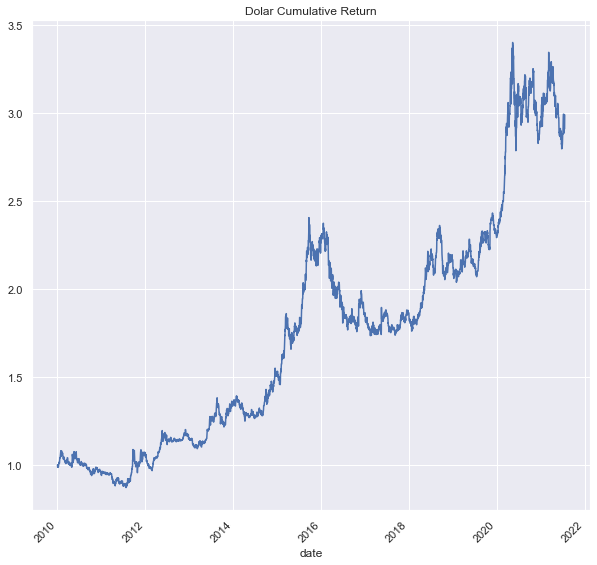

In [39]:
plot_cum_return('Dolar', dolar)

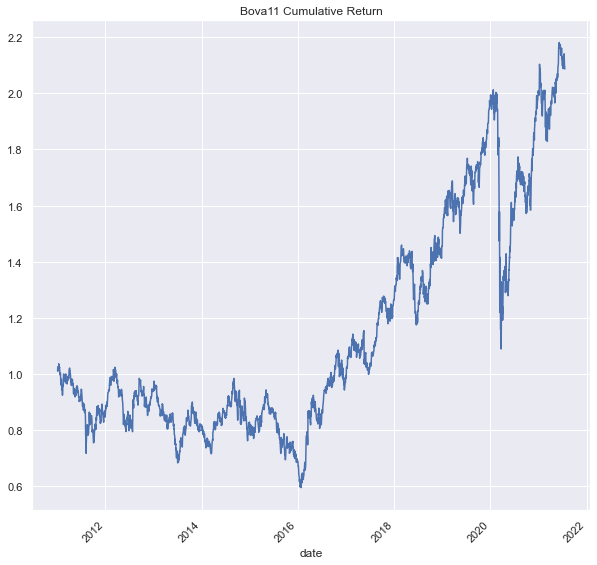

In [40]:
plot_cum_return('Bova11', bova11)

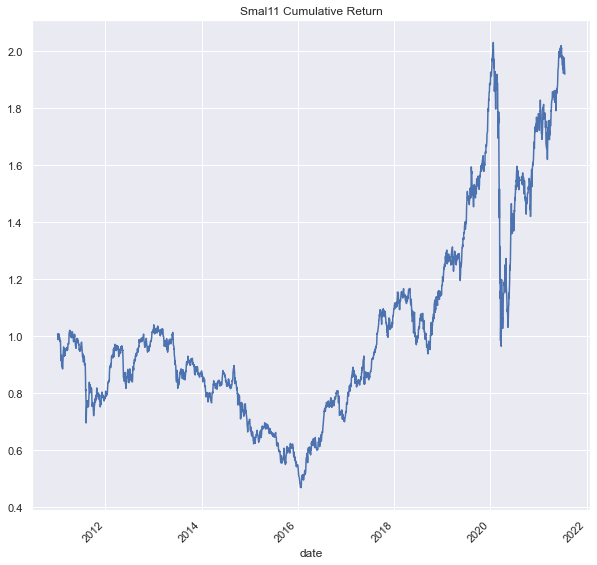

In [41]:
plot_cum_return('Smal11', smal11)

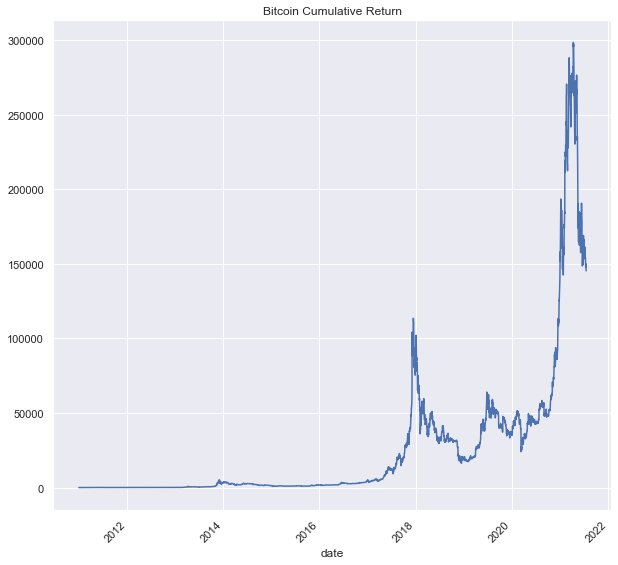

In [42]:
plot_cum_return('Bitcoin', bitcoin)

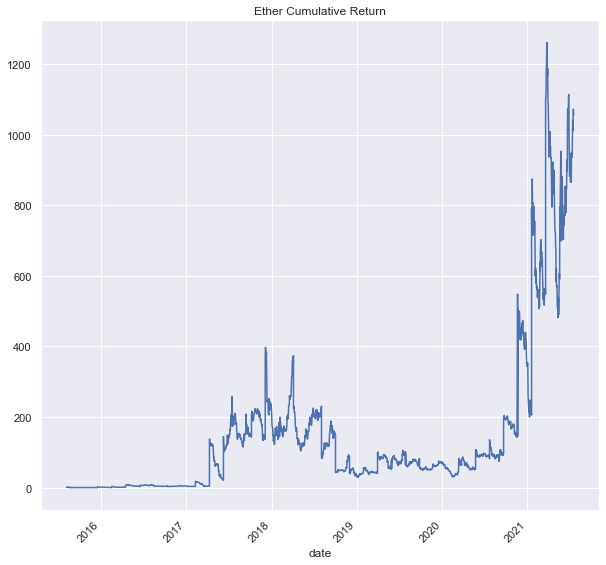

In [43]:
plot_cum_return('Ether', ether)

Algumas observações: ao final do período, todos ativos obtiveram valorização. No entanto, vale a pena destacar o percusso: o **Bova11** e o **Small1** foram os ativos que mais sofreram retornos negativos, sobretudo ao longo da crise de 2014-2016, provavelmente devido ao caráter e ao vínculo com a economia nacional desses índices, além do impacto da crise do Covid-19 deflagrada em 2020;


O **Bitcoin** e o **Ether** são disparadamente as que mais alcançaram valorização acumulada, demonstrando o poder crescente das criptomoeadas. Esses dois ativos basicamente não sofreram com o impacto da pandemia, junto ao **dólar** que, devido à evasão de agentes econômicos nesse período, valorizou-se.

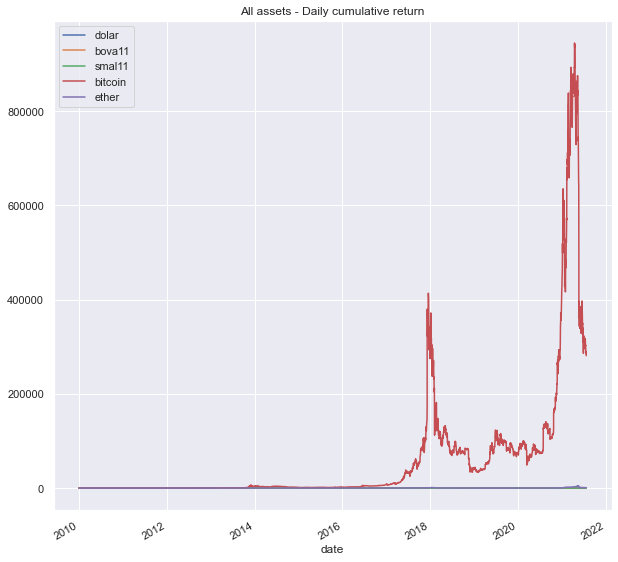

In [44]:
(1+full_return_pct).cumprod().plot();
plt.title('All assets - Daily cumulative return');

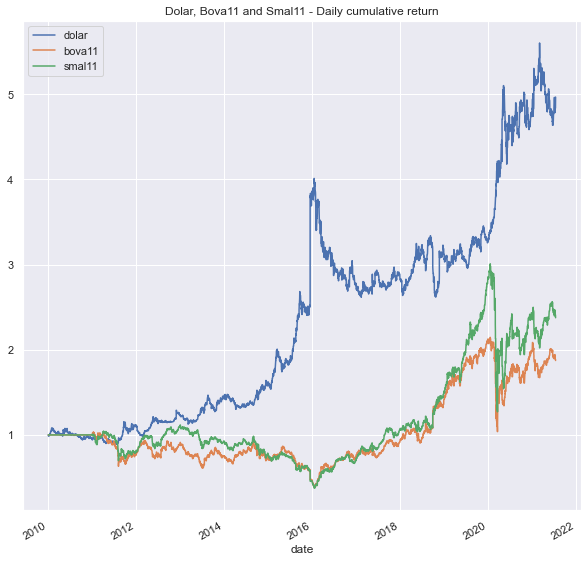

In [45]:
(1+full_return_pct.drop(['bitcoin', 'ether'], axis=1)).cumprod().plot()
plt.title('Dolar, Bova11 and Smal11 - Daily cumulative return');

#### Daily Return Cumulative Sum per Day of the Year --> Sazonalidade

In [46]:
def plot_cumsum_day_of_year(asset_name, df):
    plt.title('{} - Daily Return Cumulative Sum per Day of the Year'.format(asset_name))
    (1+df.groupby(df.index.day_of_year)['daily_return_pct'].mean()).cumprod().plot()
    return plt.show()

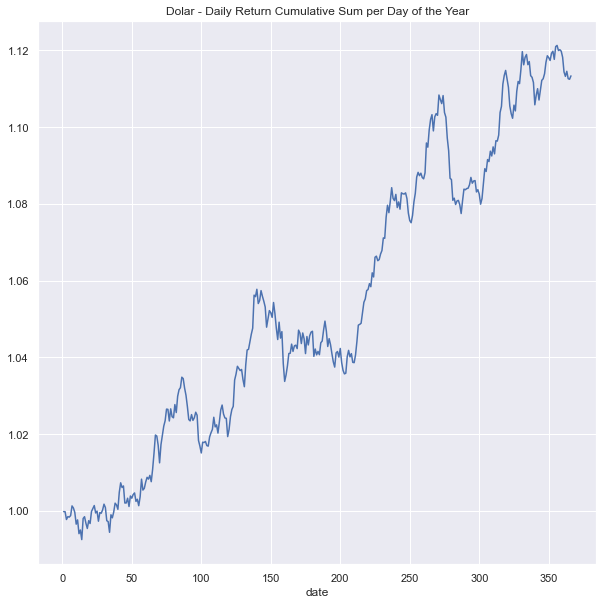

In [47]:
plot_cumreturn_day_of_year('Dolar', dolar)

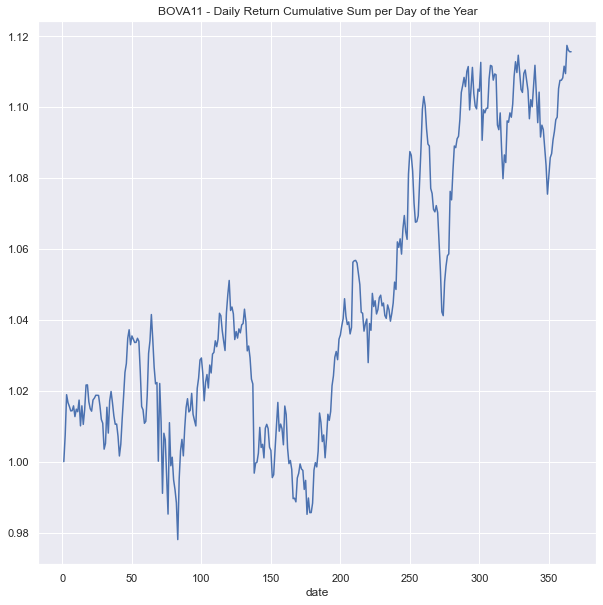

In [48]:
plot_cumreturn_day_of_year('BOVA11', bova11)

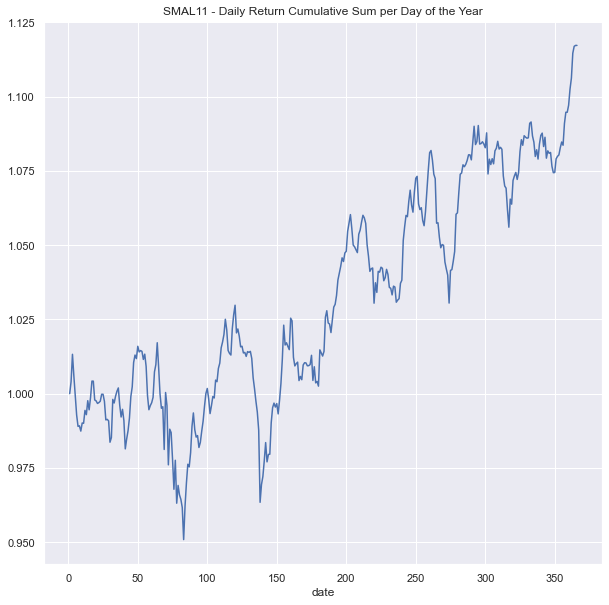

In [49]:
plot_cumreturn_day_of_year('SMAL11', smal11)

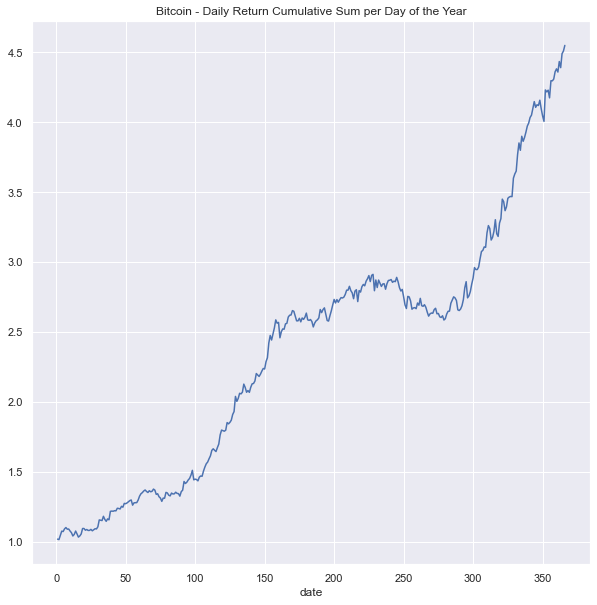

In [50]:
plot_cumreturn_day_of_year('Bitcoin', bitcoin)

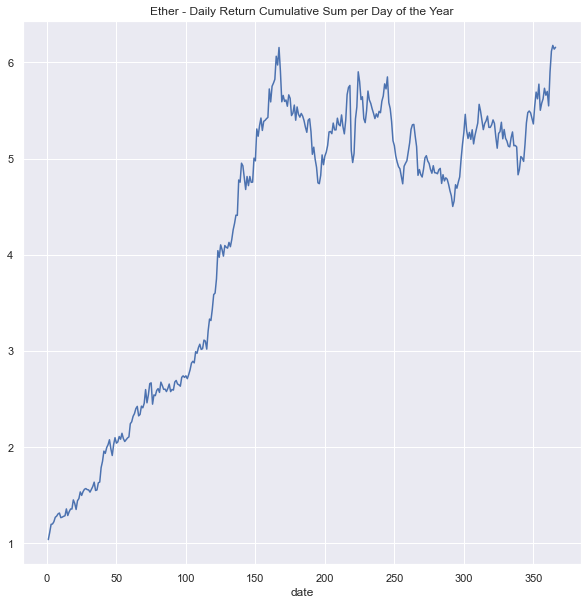

In [51]:
plot_cumreturn_day_of_year('Ether', ether)

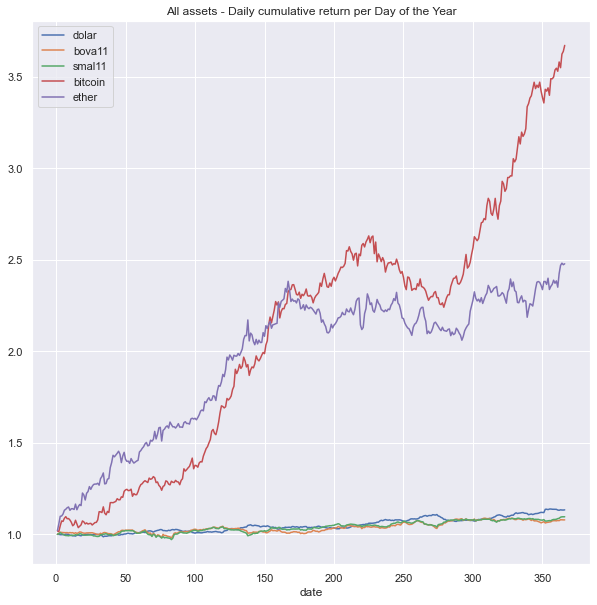

In [52]:
(1+full_return_pct.groupby(full_return_pct.index.day_of_year).mean()).cumprod().plot();
plt.title('All assets - Daily cumulative return per Day of the Year');

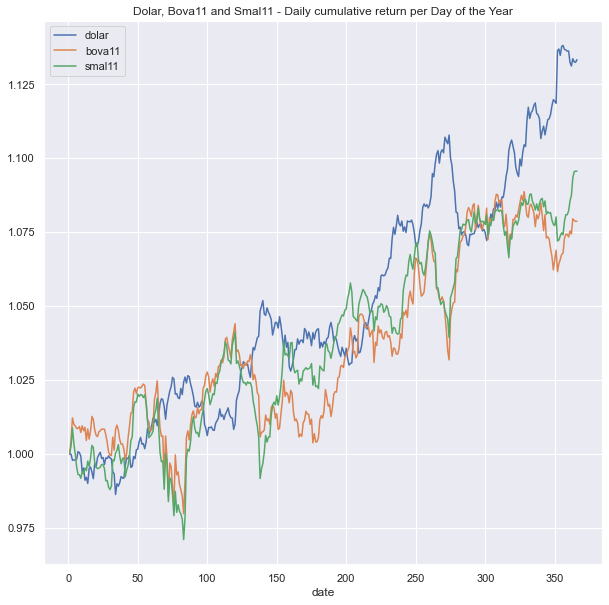

In [53]:
(1+full_return_pct[['dolar', 'bova11', 'smal11']].groupby(full_return_pct[['dolar', 'bova11', 'smal11']].index.day_of_year).mean()).cumprod().plot();
plt.title('Dolar, Bova11 and Smal11 - Daily cumulative return per Day of the Year');

De forma geral, a maioria dos ativos tende a iniciar o ano num ritmo mais lento ao passo que vão aumento a geração de retorno diário ao longo do ano. 

Percebemos novamente como o desenvolvimento de Bitcoin e Ether distorce a comparação, devido ao seu acentuado acúmulo. Retirando-los, pode-se identificar como a dinâmica de movimento do Dólar é on reflexo oposto do movimento do **Bova11** e **Smal11**. Ademais, Bova11 e o Smal11 apresentam solavancos negativos ao longo do ano sobretudo entre o primeiro trimestre e o segundo trimestre dos anos. Vale ressaltar que esses desempenhos provavelmente foram influenciados pelo pandemia do Covid-19 que impactou fortemente a economia brasileira nesse período.

####  Mean Daily Return Percentage per Month-> Sazonalidade

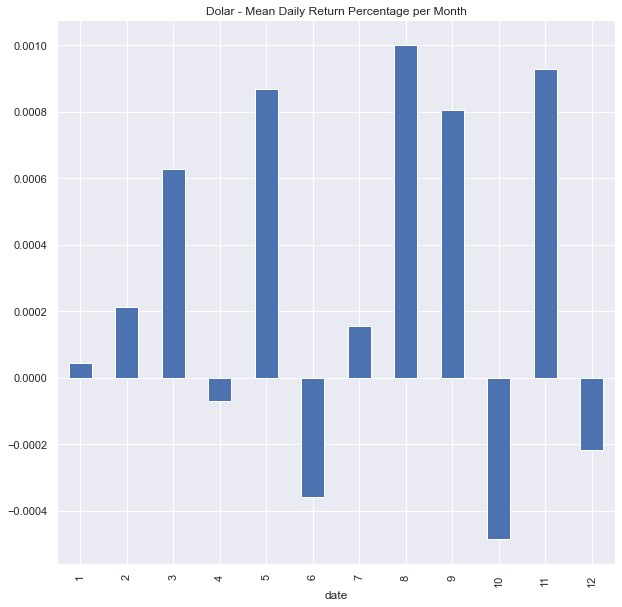

In [54]:
plot_mean_month('Dolar',dolar)

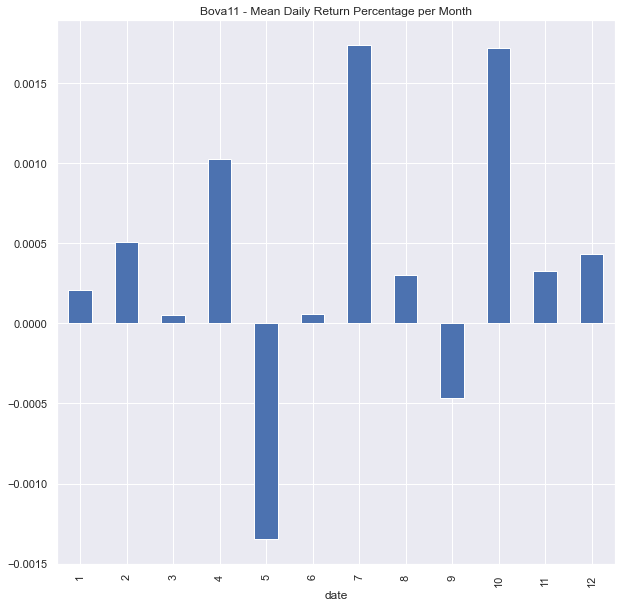

In [55]:
plot_mean_month('Bova11', bova11)

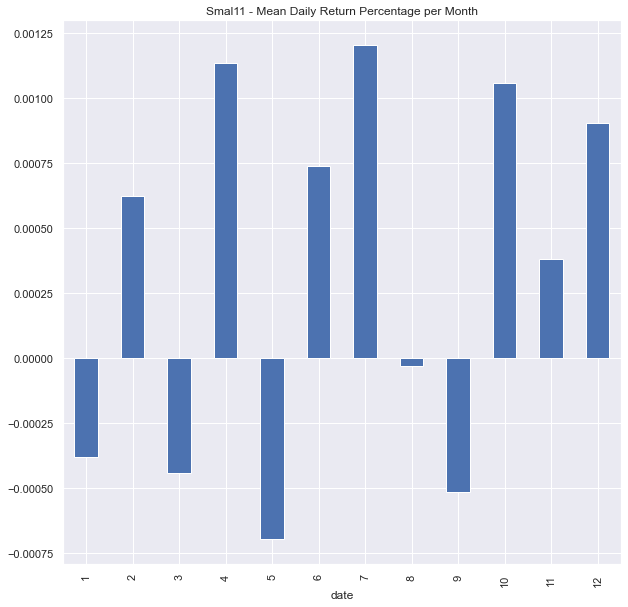

In [56]:
plot_mean_month('Smal11', smal11)

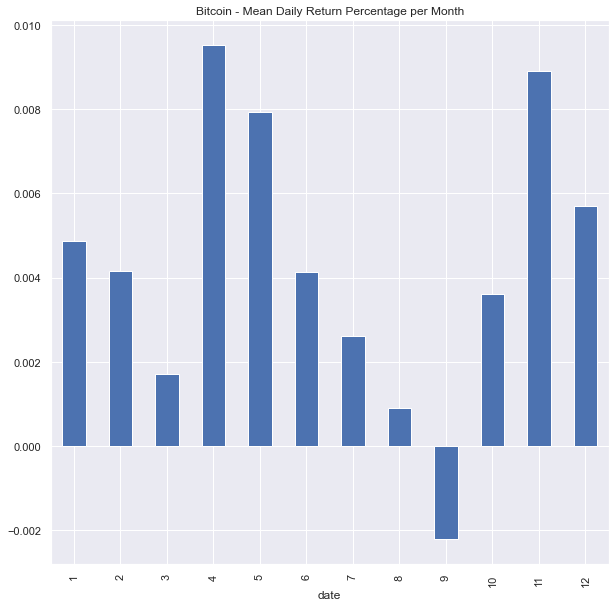

In [57]:
plot_mean_month('Bitcoin', bitcoin)

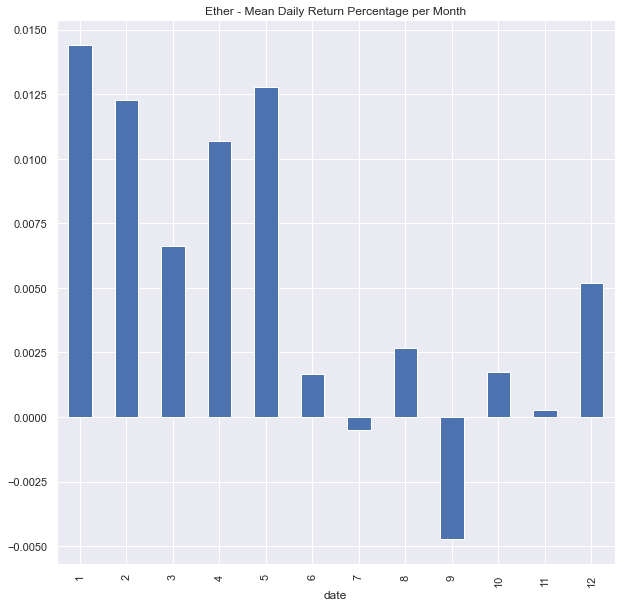

In [58]:
plot_mean_month('Ether', ether)

Como é possível observar,o mês de **Setembro** foi um mês de retornos negativos para 4 dos 5 ativos. Para certificarmos de que não se trata de valores discrepantes (outliers), vamos visualizar mais afundos esse mês específico.

#### Daily Return Percentage Sum per Day of Month - May and September

**Negative Returns**

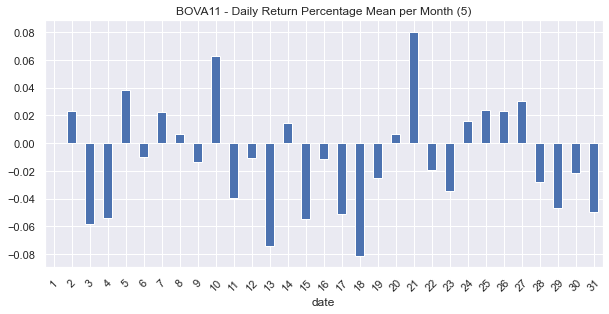

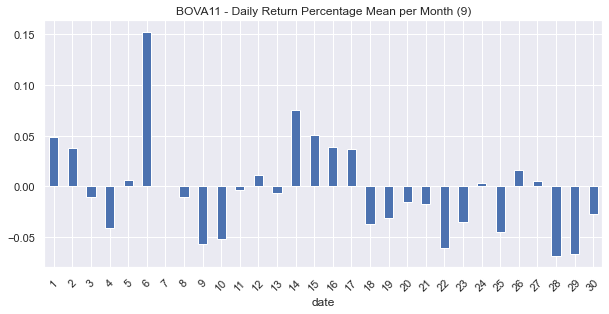

In [59]:
plt.subplot(2,1,1)
plot_daily_sum_per_month('BOVA11', bova11, 5)

plt.subplot(2,1,2)
plot_daily_sum_per_month('BOVA11', bova11, 9)


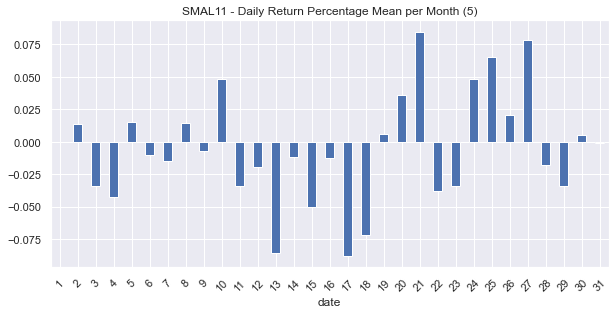

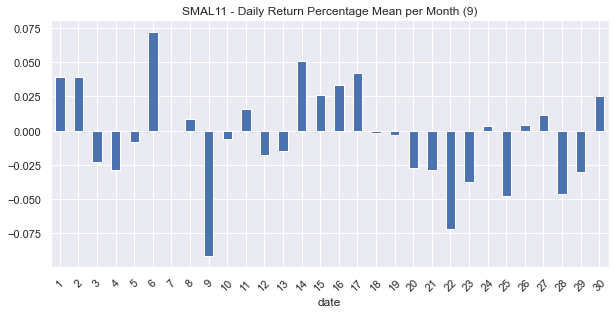

In [60]:
plt.subplot(2,1,1)
plot_daily_sum_per_month('SMAL11', smal11, 5)

plt.subplot(2,1,2)
plot_daily_sum_per_month('SMAL11', smal11, 9)


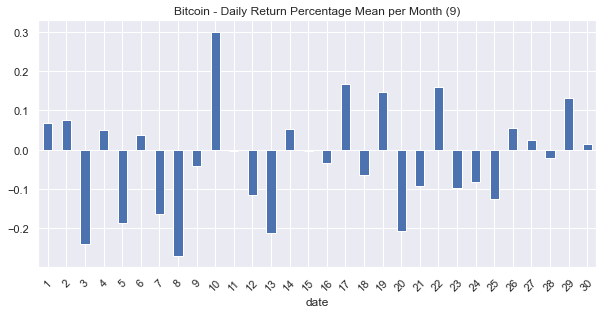

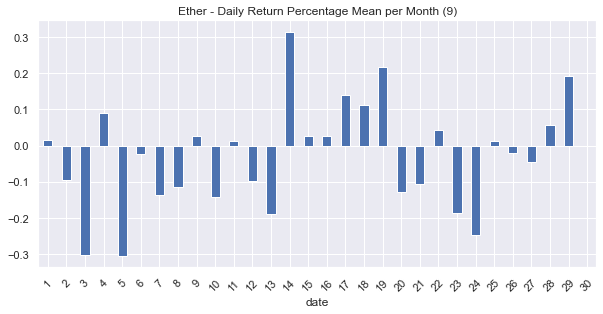

In [61]:
# Bitcoin and Ether both in September
plt.subplot(2,1,1)
plot_daily_sum_per_month('Bitcoin', bitcoin, 9)

plt.subplot(2,1,2)
plot_daily_sum_per_month('Ether', ether, 9)


Podemos observar que realmente Setembro possui um comportamento atípico em termos de rentabilidade, **não se tratando, portanto, de outlier**. A explicação para esse fenômeno requer um maior entendimento da dinâmica desses ativos, em específico, e do mercado, em geral, ao longo desse período.

Se para valores negativos tentamos verificar a presença de outliers, faremos o mesmo para os retornos positivos. Na seção seguinte, usamos a **mediana**, ao invés da média, para conferir a performance dos ativos **sem a possível influência de valores discrepantes**.

####  Median Daily Return Percentage per Month

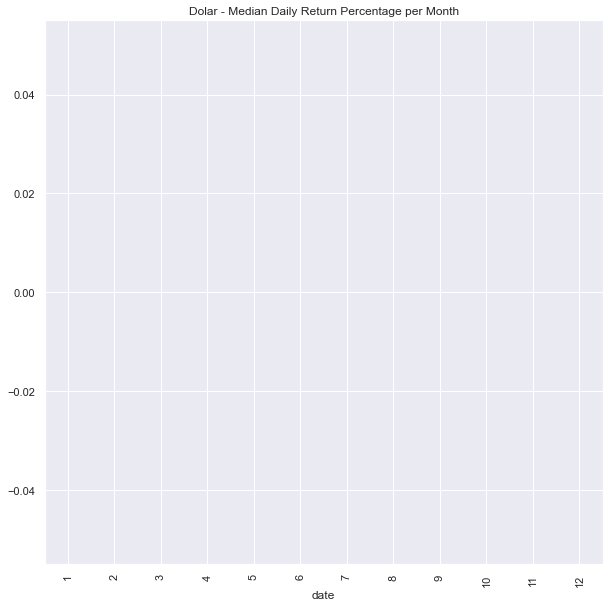

In [62]:
# The Dolar's Median Daily Return Percentage per Month is 0 for all months
plot_median_month('Dolar',dolar)

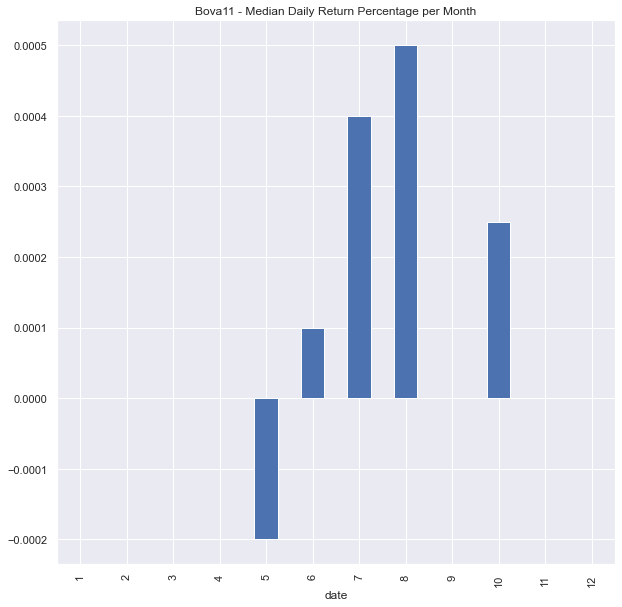

In [63]:
plot_median_month('Bova11',bova11)

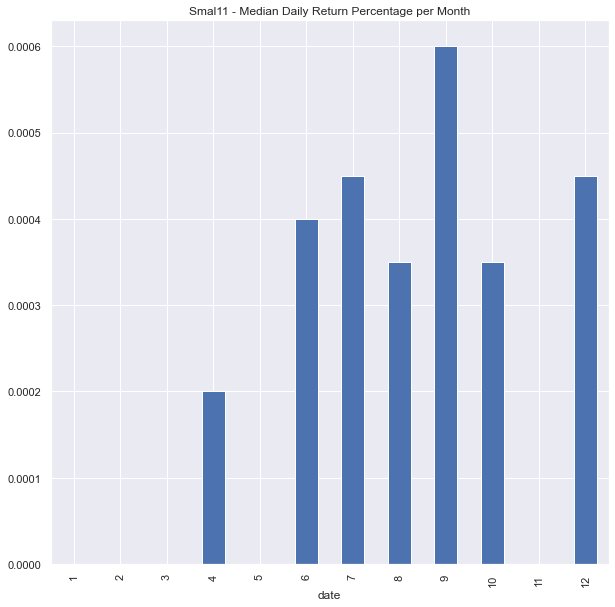

In [64]:
plot_median_month('Smal11',smal11)

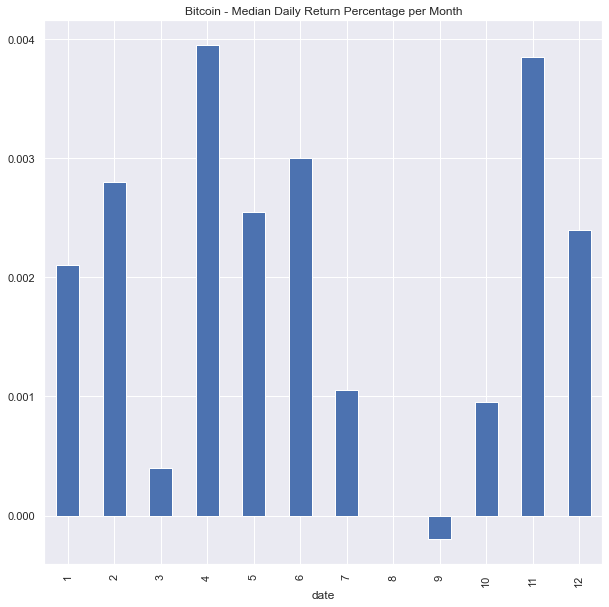

In [65]:
plot_median_month('Bitcoin', bitcoin)

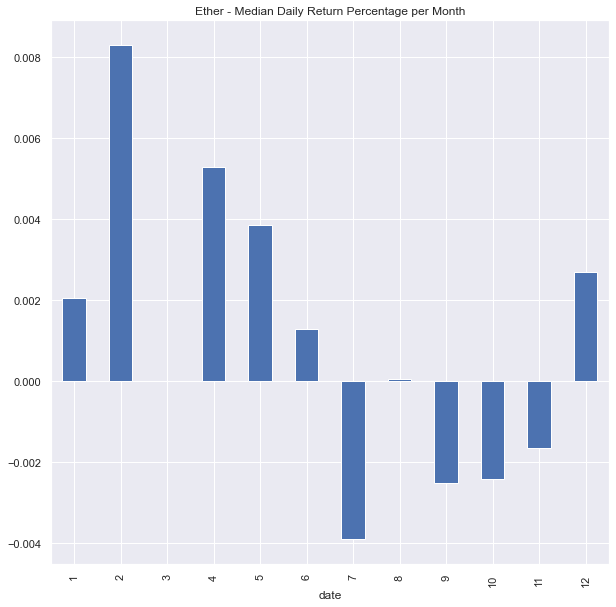

In [66]:
plot_median_month('Ether',ether)

O que vale ser destacado é como há presença significativa de variação nula em alguns meses, com destaque extraordinário do dólar. No mais, **a tendência das medianax mais ou menos reflete a tendência das médias**, principalmente no caso das criptomoedas, como pode ser visto no caso dos meses de retorno baixo do **Bitcoin** e do segundo semestre fraco do **Ether**.

In [67]:
# rows=2
# columns=2
# plt.subplot(rows,columns,1)
# plot_cumsum_day_of_year('Dolar', dolar)

# plt.subplot(rows,columns,2)
# plot_cumsum_day_of_year('BOVA11', bova11)

# plt.subplot(rows,columns,3)
# plot_cumsum_day_of_year('SMAL11', smal11)

# plt.subplot(rows,columns,4)
# plot_cumsum_day_of_year('Bitcoin', bitcoin)

# # plt.subplot(rows,columns,5)
# # plot_cumsum_day_of_year('Ether', ether)
# plt. subplots_adjust()

#### Yearly Return

In [68]:
dolar.daily_return_pct.mean()

0.00028959981386691486

In [69]:
#def yearly_
dolar.groupby(dolar.index.year)['daily_return_pct'].mean()*252

date
2010   -0.02984
2011    0.08847
2012    0.05826
2013    0.11103
2014    0.08056
2015    0.29044
2016   -0.12559
2017    0.01314
2018    0.10972
2019    0.04410
2020    0.17977
2021    0.03897
Name: daily_return_pct, dtype: float64

#### Short and Long Moving Average

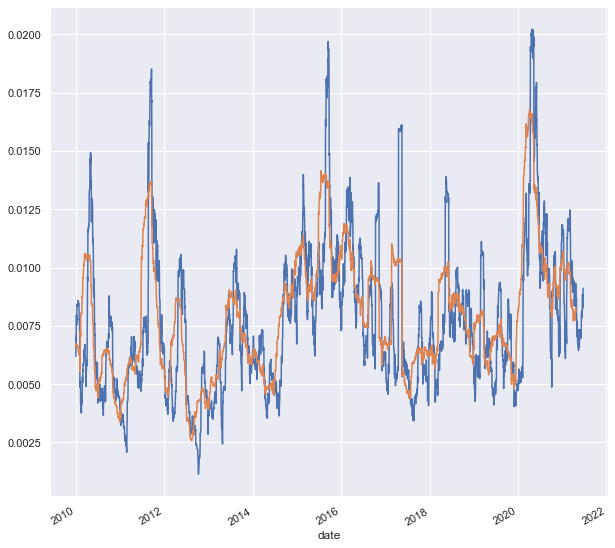

In [70]:
dolar.daily_return_pct.rolling(window=30).std().plot();
dolar.daily_return_pct.rolling(window=90).std().plot();


####

* Histograma
* **Média móvel** curta (30 dias) e longa (90 dias): `daily_return_pct.rolling(windows=30).mean()` => Plotar `.plot()`
    * Ver comportamentos e tendência
* **Volatilidade**: desvio padrão => quanto maior a amplitude da distribuição (histograma), maior a volatilidade e, portanto, maior o risco.
    * Criar a **média móvel da volatilidade**: `daily_return_pct.rolling(windows=30).std()` e plotar `.plot()`
* Normalização dos preços: a forma de comparar ativos de preços diferentes
    * `retorno_acumulado = (1 + df.daily_return_pct).cumprod()`

#### Volatility

Dolar Standard Deviation: 0.00833


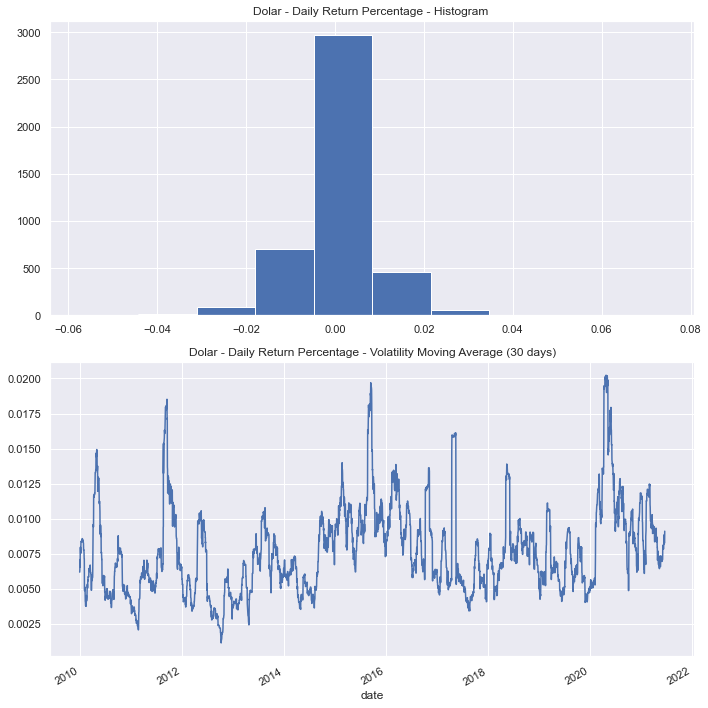

In [71]:
plot_volatility('Dolar',dolar)

Bova11 Standard Deviation: 0.0156


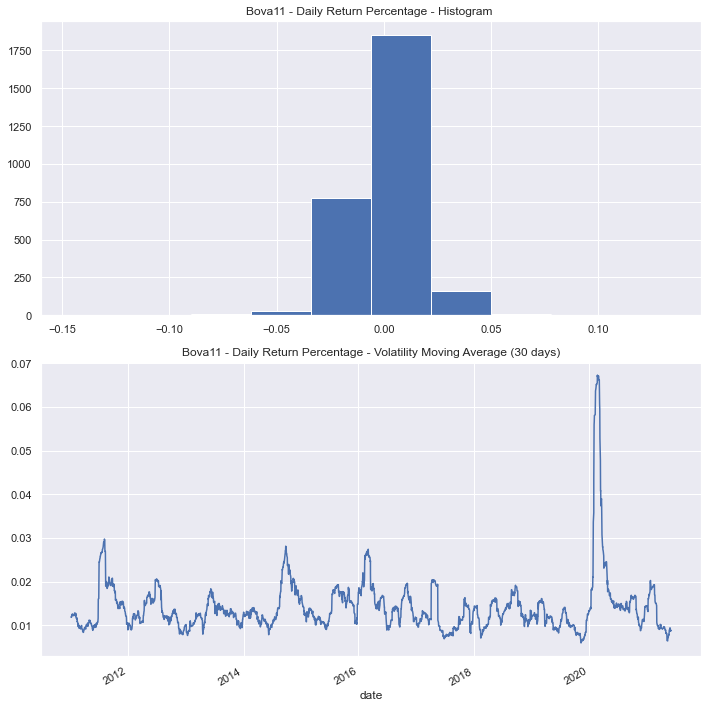

In [72]:
plot_volatility('Bova11',bova11)

Smal11 Standard Deviation: 0.01405


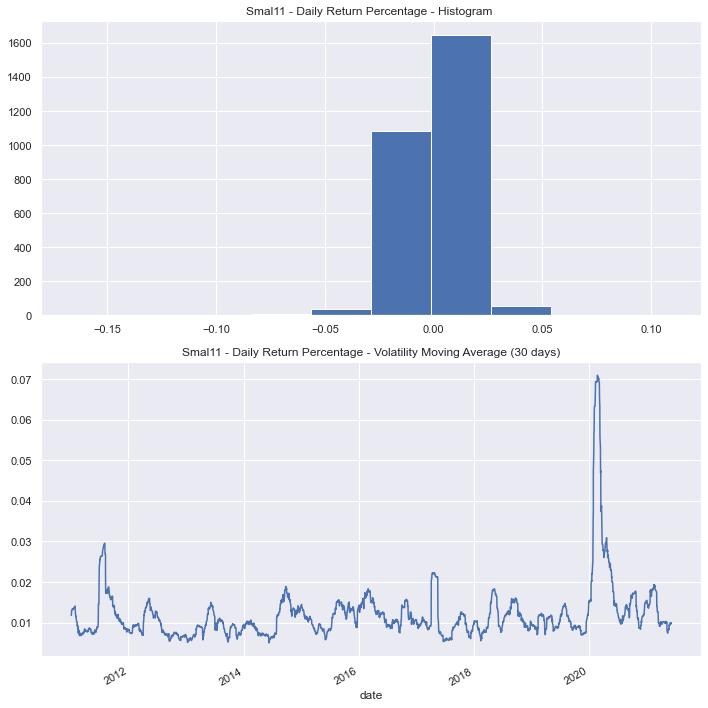

In [73]:
plot_volatility('Smal11',smal11)

Bitcoin Standard Deviation: 0.05167


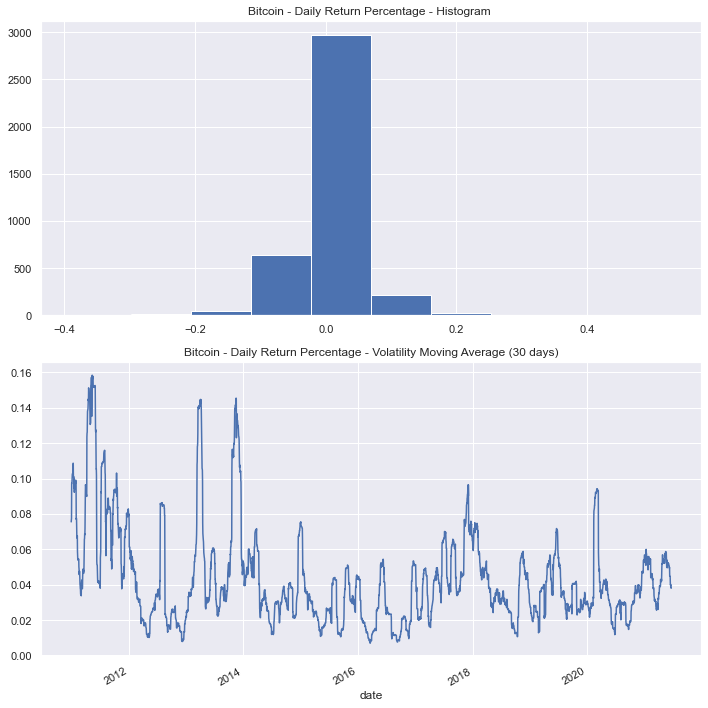

In [74]:
plot_volatility('Bitcoin',bitcoin)

Ether Standard Deviation: 0.06565


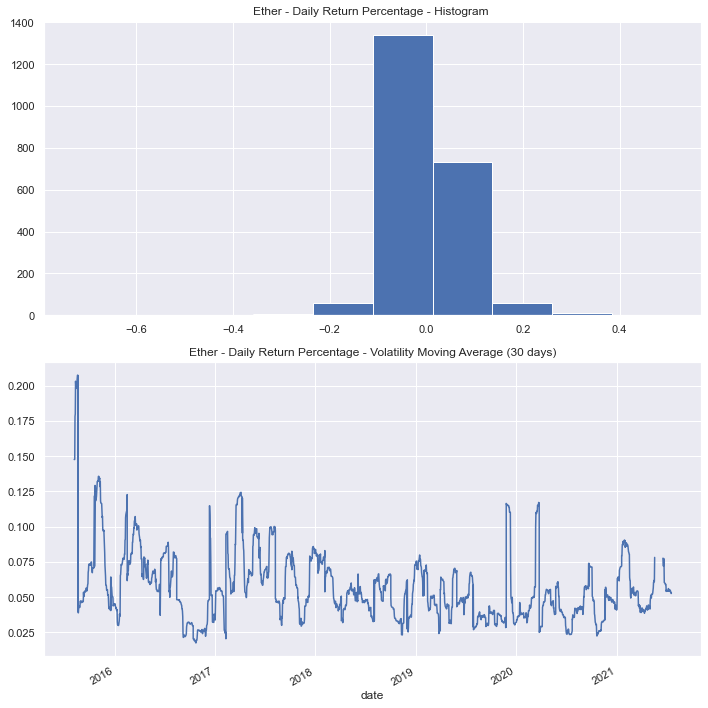

In [75]:
plot_volatility('Ether',ether)

#### Mean-Variance 

In [76]:
mean_std = pd.DataFrame()
mean_std['mean'] = [full_return_pct[column].mean() for column in full_return_pct.columns]
mean_std['std'] =[full_return_pct[column].std() for column in full_return_pct.columns]
mean_std.set_index(full_return_pct.columns, inplace=True)
mean_std

mean     std
dolar   0.00038 0.00847
bova11  0.00021 0.01272
smal11  0.00025 0.01159
bitcoin 0.00386 0.04902
ether   0.00260 0.04759

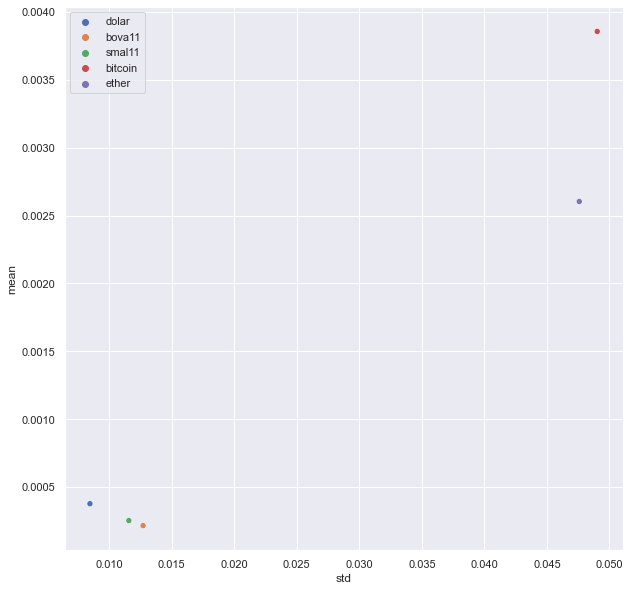

In [77]:
sns.scatterplot(mean_std['std'],mean_std['mean'],hue=mean_std.index);

## 4.2 Bivariate Analysis

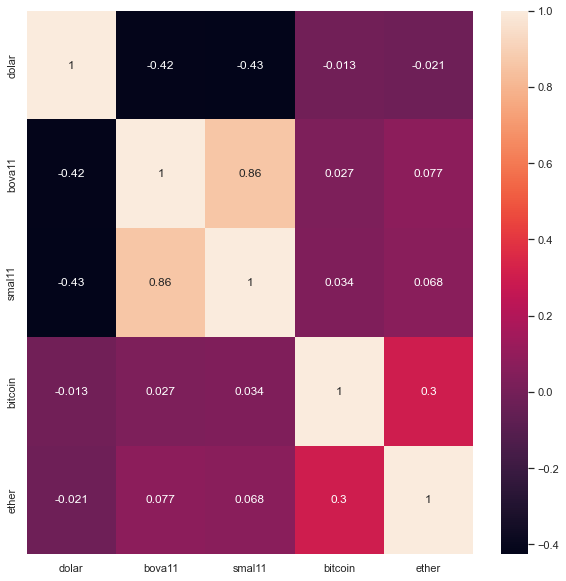

In [78]:
daily_corr = full_return_pct.corr()
sns.heatmap(daily_corr, annot=True);

#### Covariance

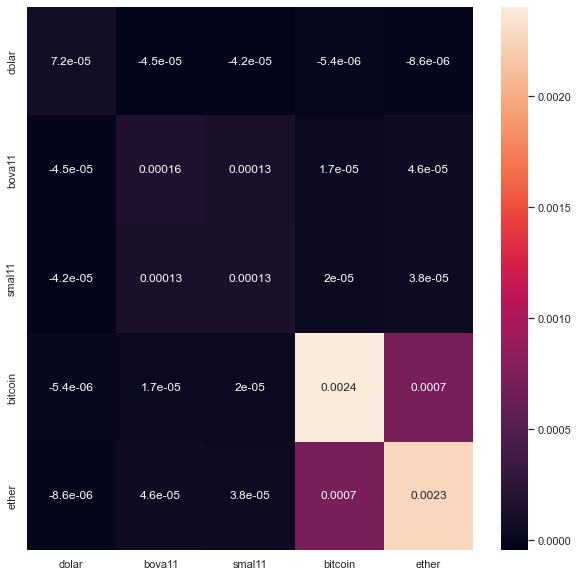

In [79]:
daily_cov = full_return_pct.cov()
sns.heatmap(daily_cov, annot=True);

## 4.3 Multivariate Analysis - Hypothesis Testing

Para geração e validação de hipóteses, iremos criar um cenário fictício por meio de perfis de investimentos diferentes, conforme nossa cartela de ativos, afim de levantar insights sobre a performance dessas aplicações em termos de retorno (`daily_return_pct`) e de risco (`std`).

A ideia é utilizar a **Simulação de Monte Carlo** para validar nossas hipóteses, de modo a testar a alocação de investimento das carteiras, que correspondem ao perfil de investidor criado. A Simulação de Monte Carlo contribui para criar portfólios com combinações de alocação (aleaórias ou não), levando em conta a covariância entre os ativos do portfólio. Com a Simulação de Monte Carlo, por exemplo, é possível criar uma carteira de ativos cujo risco é menor do que todos os ativos separadamente.

Perfis de investidores e sua correspondente porcentagem de alocação:
* **Investidor Nacional**: Bova11 (50%) e Smal11 (50%)
* **Investidor de criptomoeda**: Bitcoin (50%) e Ether (50%)
* **Investidor Estrangeiro**: Dolar (40%), Ether (30%) e Bova11 (30%)

**Hipóteses**:
1. O investidor de criptomoeda terá o dobro do retorno do investidor nacional
2. Investidor nacional terá um rendimento médio maisor do que o estrangeiro
3. O risco do investidor de cripto é maior do que a soma do risco dos investidores nacional e estrangeiro
4. Investir só em dólar dá um retorno médio maior do que o retorno do investidor nacional
5. O retorno médio do investidor estrangeiro é maior do que o retorno médio do investidor de criptomoeda
6. Investir 20% em cada ativo dá um retorno maior do que só investir em ativos nacionais 

### 4.3.1 Monte Carlo Simulation - Hypothesis Validation

In [80]:
port = hyp_monte_carlo(full_return_pct)
port

returns  volatility  return_risk_ratio  dolar_weight  bova11_weight  smal11_weight  bitcoin_weight  ether_weight invest_profile
0  0.05877     0.18606            0.31585       0.00000        0.50000        0.50000         0.00000       0.00000       National
1  0.81396     0.61870            1.31561       0.00000        0.00000        0.00000         0.50000       0.50000         Crypto
2  0.25093     0.23832            1.05293       0.40000        0.30000        0.00000         0.00000       0.30000        Foreign
3  0.09475     0.13453            0.70433       1.00000        0.00000        0.00000         0.00000       0.00000     Dolar_Only
4  0.36804     0.26060            1.41231       0.20000        0.20000        0.20000         0.20000       0.20000       Balanced

**1. O investidor de criptomoeda terá o dobro do retorno do investidor nacional**

In [81]:
print('Verdadeiro, o Investidor de criptomoeda obteve mais que {}x o retorno do investidor nacional.'.format(np.round(float(port.loc[port.invest_profile =='Crypto']['returns'].values / port.loc[port.invest_profile =='National']['returns'].values),2)))

Verdadeiro, o Investidor de criptomoeda obteve mais que 13.85x o retorno do investidor nacional.


**2. Investidor nacional terá um rendimento médio maior do que o estrangeiro**

In [82]:
print('Falso, a rentabilidade do investido estrangeiro ({}) é significativamente maior do que o do investidor nacional ({}).'.format(round(float(port.loc[port.invest_profile =='Foreign']['returns'].values),3),round(float(port.loc[port.invest_profile =='National']['returns'].values),3)))

Falso, a rentabilidade do investido estrangeiro (0.251) é significativamente maior do que o do investidor nacional (0.059).


**3. O risco do investidor de cripto é maior do que a soma do risco dos investidores nacional e estrangeiro**

In [83]:
print('Verdadeiro, o risco do investidor de criptomoedade ({}) é maior do que a soma dos riscos dos investidores nacional e estrangeiro ({}).'.format(round(float(port.loc[port.invest_profile =='Crypto']['volatility'].values),3),
                                                                                                                                                 round(float(port.loc[port.invest_profile =='National']['volatility'].values),3) + round(float(port.loc[port.invest_profile =='Foreign']['volatility'].values),3)))

Verdadeiro, o risco do investidor de criptomoedade (0.619) é maior do que a soma dos riscos dos investidores nacional e estrangeiro (0.424).


**4. Investir só em dólar rendeu um retorno médio maior do que o retorno do investidor nacional**

In [84]:
print('Verdadeiro, a compra e venda de dólares rendeu um retorno maior ({}) do que as aplicações do investidor nacional ({})'.format(round(float(port.loc[port.invest_profile =='Dolar_Only']['returns'].values),3),
                                                                                                                                round(float(port.loc[port.invest_profile =='National']['returns'].values),3)))

Verdadeiro, a compra e venda de dólares rendeu um retorno maior (0.095) do que as aplicações do investidor nacional (0.059)


**5. O retorno médio do investidor estrangeiro é maior do que o retorno médio do investidor de criptomoeda**


In [85]:
print('Falso, a rentabildiade auferida pelo investido de criptomoeda ({}) é significativamente maior do que a do investidor estrangeiro ({}).'.format(round(float(port.loc[port.invest_profile =='Crypto']['returns'].values),3),
                                                                                                                                                     round(float(port.loc[port.invest_profile =='Foreign']['returns'].values),3)))

Falso, a rentabildiade auferida pelo investido de criptomoeda (0.814) é significativamente maior do que a do investidor estrangeiro (0.251).


**6. Investir 20% em cada ativo dá um retorno maior do que só investir em ativos nacionais**

In [86]:
print('Verdadeiro, o investimento balanceado na carteira de ativos aufere uma rentabilidade ({}) consideravelmente maior do que a carteira exclusivamente nacional ({}).'.format(round(float(port.loc[port.invest_profile =='Balanced']['returns'].values),3),
                                                                                                                                                                                 round(float(port.loc[port.invest_profile =='National']['returns'].values),3)))

Verdadeiro, o investimento balanceado na carteira de ativos aufere uma rentabilidade (0.368) consideravelmente maior do que a carteira exclusivamente nacional (0.059).


# 5.0 Data Preparation

In [87]:
# Min Max Scaler
mms = MinMaxScaler()

In [88]:
# for df in [dolar_full]:
#     df['close'] = mms.fit_transform(df[['close']].values)
#     df['daily_variation'] = mms.fit_transform(df[['daily_variation']].values)
#     df['open'] = mms.fit_transform(df[['open']].values)
#     df['high'] = mms.fit_transform(df[['high']].values)
#     df['low'] = mms.fit_transform(df[['low']].values)
#     df['volume'] = mms.fit_transform(df[['volume']].values)
#     df['taxa_selic'] = mms.fit_transform(df[['taxa_selic']].values)
#     df['ipca'] = mms.fit_transform(df[['ipca']].values)
#     df['indice_di'] = mms.fit_transform(df[['indice_di']].values)
#     df['bova11'] = mms.fit_transform(df[['bova11']].values)
#     df['smal11'] = mms.fit_transform(df[['smal11']].values)
#     df['bitcoin'] = mms.fit_transform(df[['bitcoin']].values)
#     df['ether'] = mms.fit_transform(df[['ether']].values)
# dolar_full.head()

In [89]:
# for df in [bova11_full]:
#     df['close'] = mms.fit_transform(df[['close']].values)
#     df['daily_variation'] = mms.fit_transform(df[['daily_variation']].values)
#     df['open'] = mms.fit_transform(df[['open']].values)
#     df['high'] = mms.fit_transform(df[['high']].values)
#     df['low'] = mms.fit_transform(df[['low']].values)
#     df['volume'] = mms.fit_transform(df[['volume']].values)
#     df['taxa_selic'] = mms.fit_transform(df[['taxa_selic']].values)
#     df['ipca'] = mms.fit_transform(df[['ipca']].values)
#     df['indice_di'] = mms.fit_transform(df[['indice_di']].values)
#     df['dolar'] = mms.fit_transform(df[['dolar']].values)
#     df['smal11'] = mms.fit_transform(df[['smal11']].values)
#     df['bitcoin'] = mms.fit_transform(df[['bitcoin']].values)
#     df['ether'] = mms.fit_transform(df[['ether']].values)
# bova11_full.head()

In [90]:
# for df in [smal11_full]:
#     df['close'] = mms.fit_transform(df[['close']].values)
#     df['daily_variation'] = mms.fit_transform(df[['daily_variation']].values)
#     df['open'] = mms.fit_transform(df[['open']].values)
#     df['high'] = mms.fit_transform(df[['high']].values)
#     df['low'] = mms.fit_transform(df[['low']].values)
#     df['volume'] = mms.fit_transform(df[['volume']].values)
#     df['taxa_selic'] = mms.fit_transform(df[['taxa_selic']].values)
#     df['ipca'] = mms.fit_transform(df[['ipca']].values)
#     df['indice_di'] = mms.fit_transform(df[['indice_di']].values)
#     df['dolar'] = mms.fit_transform(df[['dolar']].values)
#     df['bova11'] = mms.fit_transform(df[['bova11']].values)
#     df['bitcoin'] = mms.fit_transform(df[['bitcoin']].values)
#     df['ether'] = mms.fit_transform(df[['ether']].values)
# smal11_full.head()

In [91]:
# for df in [bitcoin_full]:
#     df['close'] = mms.fit_transform(df[['close']].values)
#     df['daily_variation'] = mms.fit_transform(df[['daily_variation']].values)
#     df['open'] = mms.fit_transform(df[['open']].values)
#     df['high'] = mms.fit_transform(df[['high']].values)
#     df['low'] = mms.fit_transform(df[['low']].values)
#     df['volume'] = mms.fit_transform(df[['volume']].values)
#     df['taxa_selic'] = mms.fit_transform(df[['taxa_selic']].values)
#     df['ipca'] = mms.fit_transform(df[['ipca']].values)
#     df['indice_di'] = mms.fit_transform(df[['indice_di']].values)
#     df['dolar'] = mms.fit_transform(df[['dolar']].values)
#     df['bova11'] = mms.fit_transform(df[['bova11']].values)
#     df['smal11'] = mms.fit_transform(df[['smal11']].values)
#     df['ether'] = mms.fit_transform(df[['ether']].values)
# bitcoin_full.head()

In [92]:
# for df in [ether_full]:
#     df['close'] = mms.fit_transform(df[['close']].values)
#     df['daily_variation'] = mms.fit_transform(df[['daily_variation']].values)
#     df['open'] = mms.fit_transform(df[['open']].values)
#     df['high'] = mms.fit_transform(df[['high']].values)
#     df['low'] = mms.fit_transform(df[['low']].values)
#     df['volume'] = mms.fit_transform(df[['volume']].values)
#     df['taxa_selic'] = mms.fit_transform(df[['taxa_selic']].values)
#     df['ipca'] = mms.fit_transform(df[['ipca']].values)
#     df['indice_di'] = mms.fit_transform(df[['indice_di']].values)
#     df['dolar'] = mms.fit_transform(df[['dolar']].values)
#     df['bova11'] = mms.fit_transform(df[['bova11']].values)
#     df['smal11'] = mms.fit_transform(df[['smal11']].values)
#     df['bitcoin'] = mms.fit_transform(df[['bitcoin']].values)
# ether_full.head()

# 6.0 Feature Selection

### Dolar

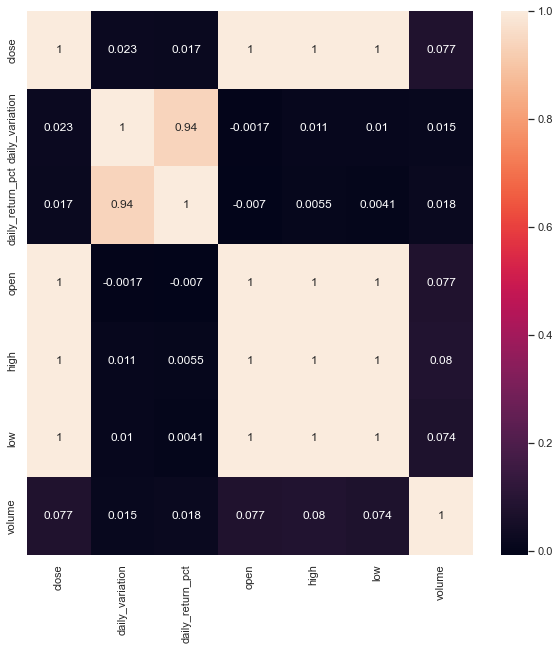

In [93]:
sns.heatmap(dolar.corr(method='pearson'), annot=True);

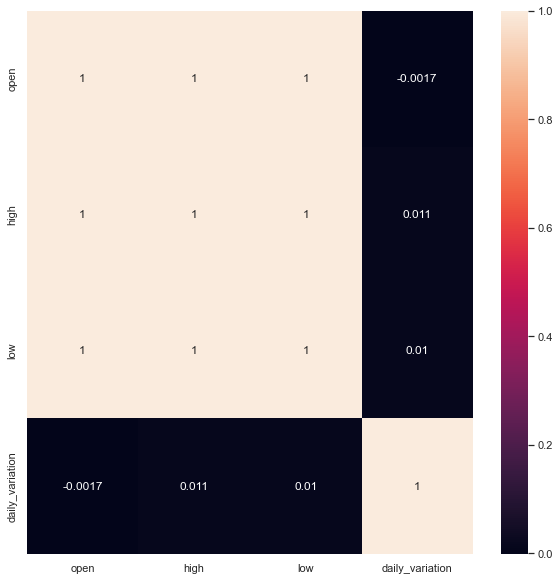

In [94]:
sns.heatmap(dolar[['open', 'high', 'low', 'daily_variation']].corr(method='pearson'), annot=True);

### Bova11

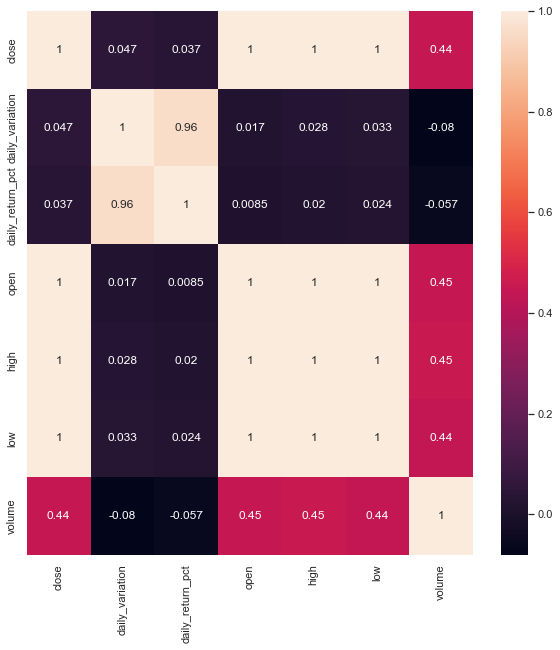

In [95]:
sns.heatmap(bova11.corr(method='pearson'), annot=True);

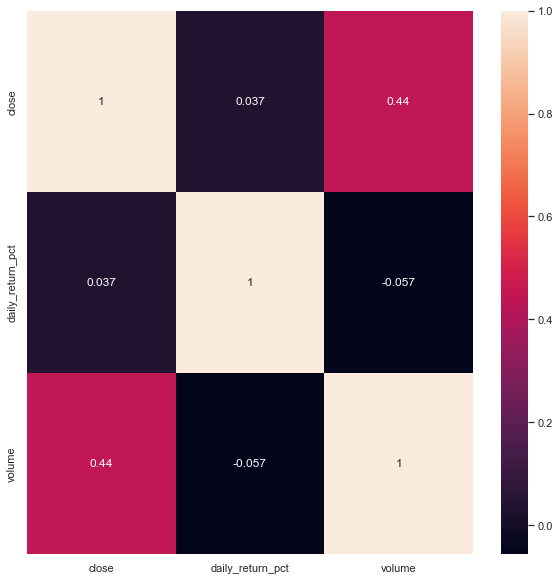

In [96]:
sns.heatmap(bova11.drop(['open', 'high', 'low', 'daily_variation'], axis=1).corr(method='pearson'), annot=True);

### Smal11

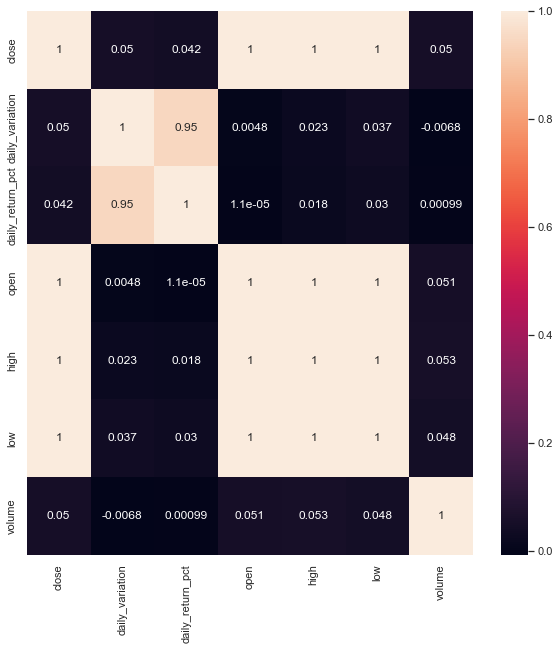

In [97]:
sns.heatmap(smal11.corr(method='pearson'), annot=True);

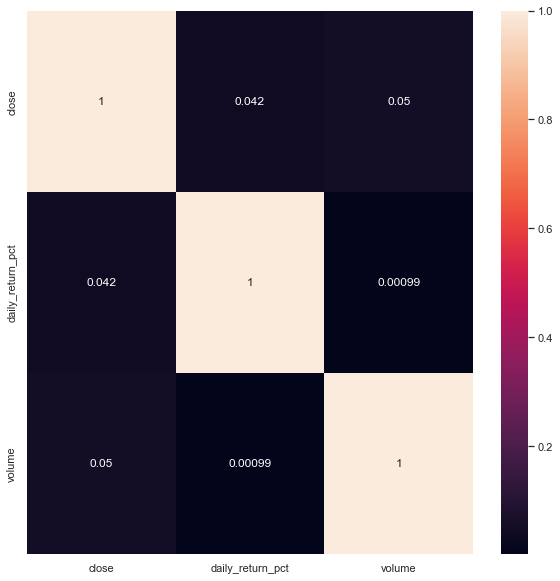

In [98]:
sns.heatmap(smal11.drop(['open', 'high', 'low', 'daily_variation'], axis=1).corr(method='pearson'), annot=True);

### Bitcoin

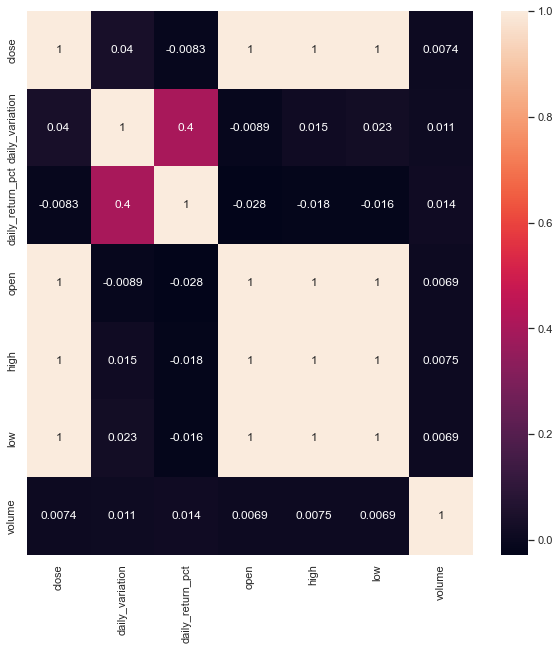

In [99]:
sns.heatmap(bitcoin.corr(method='pearson'), annot=True);

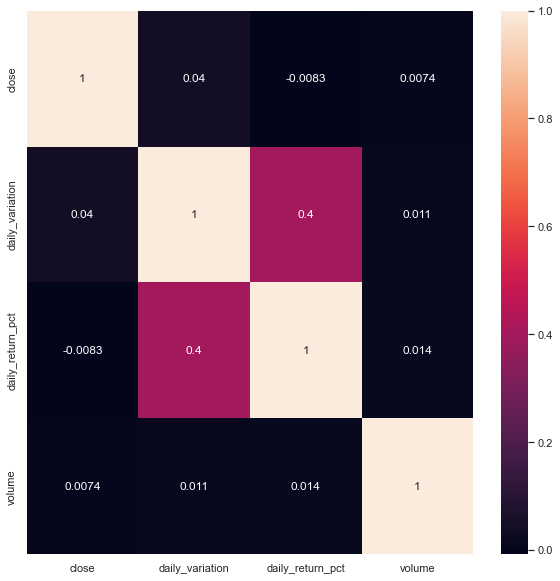

In [100]:
sns.heatmap(bitcoin.drop(['open', 'high', 'low'], axis=1).corr(method='pearson'), annot=True);

### Ether

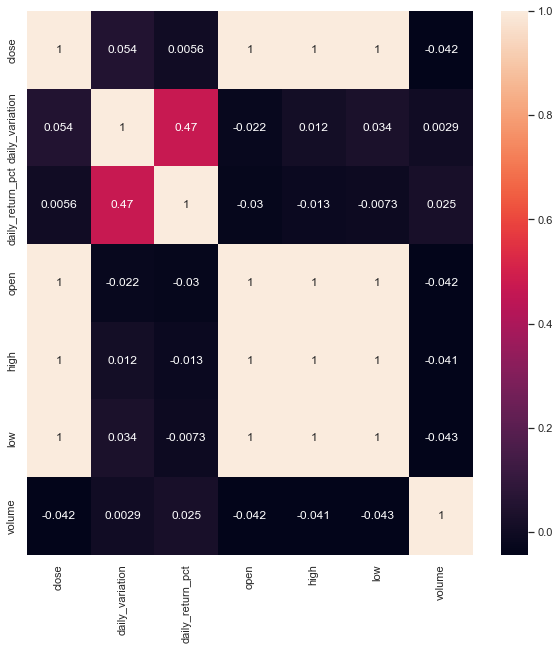

In [101]:
sns.heatmap(ether.corr(method='pearson'), annot=True);

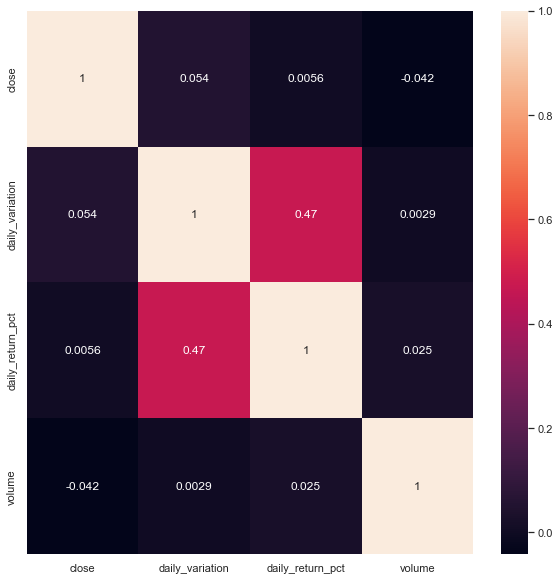

In [102]:
sns.heatmap(ether.drop(['open', 'high', 'low'], axis=1).corr(method='pearson'), annot=True);

In [103]:
# # Drop columns according to correlation matrix - avoid multicollinearity
# dolar_full.drop(['open', 'high', 'low', 'daily_variation', 'indice_di'], axis=1, inplace=True)
# bova11_full.drop(['open', 'high', 'low', 'daily_variation', 'indice_di'], axis=1, inplace=True)
# smal11_full.drop(['open', 'high', 'low', 'daily_variation', 'indice_di'], axis=1, inplace=True)
# bitcoin_full.drop(['open', 'high', 'low', 'indice_di'], axis=1, inplace=True)
# ether_full.drop(['open', 'high', 'low', 'indice_di'], axis=1, inplace=True)

# 7.0 Machine Learning Modelling

In [104]:
## Define the limit date to test set: 1 Trading Stock Year 
# 252

test_period = dolar.index.max() - datetime.timedelta(days=730)
test_period

Timestamp('2019-07-20 00:00:00')

In [105]:
# def ml_error(model_name, y, yhat):
#     mae = mean_absolute_error(y,yhat)
#     rmse = np.sqrt(mean_squared_error(y,yhat)) 
    
#     return pd.DataFrame({'Model Name': model_name,
#                          'MAE':mae,
#                         'RMSE':rmse}, index=[0])

In [106]:
def merge_indicators(d):
    if 'DOLAR' in d['symbol'][0]:
        d = pd.merge(left= d, right= selic.taxa_selic, left_index=True, right_index=True, how='left')
        d.fillna(method='ffill', inplace=True)
        #d.fillna(8.65000, inplace=True) 
        d = pd.merge(left= d, right= ipca.ipca, left_index=True, right_index=True, how='left')
        d.fillna(method='ffill', inplace=True)
        #d.fillna(0.78000, inplace=True)
        d = pd.merge(left= d, right= indice_di.indice_di, left_index=True, right_index=True, how='left')
        d.fillna(method='ffill', inplace=True) 
        #d.fillna(0.59000, inplace=True) 
    if 'BOVA11' in d['symbol'][0]:
        d = pd.merge(left= d, right= selic.taxa_selic, left_index=True, right_index=True, how='left')
        d.fillna(method='ffill', inplace=True)
        #d.fillna(11.17000, inplace=True) 
        d = pd.merge(left= d, right= ipca.ipca, left_index=True, right_index=True, how='left')
        d.fillna(method='ffill', inplace=True)
        #d.fillna(0.80000, inplace=True)
        d = pd.merge(left= d, right= indice_di.indice_di, left_index=True, right_index=True, how='left')
        d.fillna(method='ffill', inplace=True) 
        #d.fillna(0.84000, inplace=True)
    if 'SMAL11' in d['symbol'][0]:
        d = pd.merge(left= d, right= selic.taxa_selic, left_index=True, right_index=True, how='left')
        d.fillna(method='ffill', inplace=True)
        #d.fillna(11.17000, inplace=True) 
        d = pd.merge(left= d, right= ipca.ipca, left_index=True, right_index=True, how='left')
        d.fillna(method='ffill', inplace=True)
        #d.fillna(0.80000, inplace=True)
        d = pd.merge(left= d, right= indice_di.indice_di, left_index=True, right_index=True, how='left')
        d.fillna(method='ffill', inplace=True) 
        #d.fillna(0.84000, inplace=True)
    if 'BITCOIN' in d['symbol'][0]:
        d = pd.merge(left= d, right= selic.taxa_selic, left_index=True, right_index=True, how='left')
        d.fillna(method='ffill', inplace=True)
        #d.fillna(11.17000, inplace=True) 
        d = pd.merge(left= d, right= ipca.ipca, left_index=True, right_index=True, how='left')
        d.fillna(method='ffill', inplace=True)
        #d.fillna(0.83000, inplace=True)
        d = pd.merge(left= d, right= indice_di.indice_di, left_index=True, right_index=True, how='left')
        d.fillna(method='ffill', inplace=True) 
        #d.fillna(0.86000, inplace=True) 
    if 'ETHER' in d['symbol'][0]:
        d = pd.merge(left= d, right= selic.taxa_selic, left_index=True, right_index=True, how='left')
        d.fillna(method='ffill', inplace=True)
        #d.fillna(14.15000, inplace=True) 
        d = pd.merge(left= d, right= ipca.ipca, left_index=True, right_index=True, how='left')
        d.fillna(method='ffill', inplace=True)
        #d.fillna(0.54000, inplace=True)
        d = pd.merge(left= d, right= indice_di.indice_di, left_index=True, right_index=True, how='left')
        d.fillna(method='ffill', inplace=True) 
        #d.fillna(1.11000, inplace=True)
    
    return d[::-1]

In [107]:
def data_preparation(d):
    if 'DOLAR' in d['symbol'][0]:
        mms = MinMaxScaler()
        for df in [d]:
            df['close'] = mms.fit_transform(df[['close']].values)
            df['daily_variation'] = mms.fit_transform(df[['daily_variation']].values)
            df['open'] = mms.fit_transform(df[['open']].values)
            df['high'] = mms.fit_transform(df[['high']].values)
            df['low'] = mms.fit_transform(df[['low']].values)
            df['volume'] = mms.fit_transform(df[['volume']].values)
            df['taxa_selic'] = mms.fit_transform(df[['taxa_selic']].values)
            df['ipca'] = mms.fit_transform(df[['ipca']].values)
            df['indice_di'] = mms.fit_transform(df[['indice_di']].values)
            df['bova11'] = mms.fit_transform(df[['bova11']].values)
            df['smal11'] = mms.fit_transform(df[['smal11']].values)
            df['bitcoin'] = mms.fit_transform(df[['bitcoin']].values)
            df['ether'] = mms.fit_transform(df[['ether']].values)
    if 'BOVA11' in d['symbol'][0]:
        mms = MinMaxScaler()
        for df in [d]:
            df['close'] = mms.fit_transform(df[['close']].values)
            df['daily_variation'] = mms.fit_transform(df[['daily_variation']].values)
            df['open'] = mms.fit_transform(df[['open']].values)
            df['high'] = mms.fit_transform(df[['high']].values)
            df['low'] = mms.fit_transform(df[['low']].values)
            df['volume'] = mms.fit_transform(df[['volume']].values)
            df['taxa_selic'] = mms.fit_transform(df[['taxa_selic']].values)
            df['ipca'] = mms.fit_transform(df[['ipca']].values)
            df['indice_di'] = mms.fit_transform(df[['indice_di']].values)
            df['dolar'] = mms.fit_transform(df[['dolar']].values)
            df['smal11'] = mms.fit_transform(df[['smal11']].values)
            df['bitcoin'] = mms.fit_transform(df[['bitcoin']].values)
            df['ether'] = mms.fit_transform(df[['ether']].values)      
    if 'SMAL11' in d['symbol'][0]:
        mms = MinMaxScaler()
        for df in [d]:
            df['close'] = mms.fit_transform(df[['close']].values)
            df['daily_variation'] = mms.fit_transform(df[['daily_variation']].values)
            df['open'] = mms.fit_transform(df[['open']].values)
            df['high'] = mms.fit_transform(df[['high']].values)
            df['low'] = mms.fit_transform(df[['low']].values)
            df['volume'] = mms.fit_transform(df[['volume']].values)
            df['taxa_selic'] = mms.fit_transform(df[['taxa_selic']].values)
            df['ipca'] = mms.fit_transform(df[['ipca']].values)
            df['indice_di'] = mms.fit_transform(df[['indice_di']].values)
            df['dolar'] = mms.fit_transform(df[['dolar']].values)
            df['bova11'] = mms.fit_transform(df[['bova11']].values)
            df['bitcoin'] = mms.fit_transform(df[['bitcoin']].values)
            df['ether'] = mms.fit_transform(df[['ether']].values)
    if 'BITCOIN' in d['symbol'][0]:
        mms = MinMaxScaler()
        for df in [d]:
            df['close'] = mms.fit_transform(df[['close']].values)
            df['daily_variation'] = mms.fit_transform(df[['daily_variation']].values)
            df['open'] = mms.fit_transform(df[['open']].values)
            df['high'] = mms.fit_transform(df[['high']].values)
            df['low'] = mms.fit_transform(df[['low']].values)
            df['volume'] = mms.fit_transform(df[['volume']].values)
            df['taxa_selic'] = mms.fit_transform(df[['taxa_selic']].values)
            df['ipca'] = mms.fit_transform(df[['ipca']].values)
            df['indice_di'] = mms.fit_transform(df[['indice_di']].values)
            df['dolar'] = mms.fit_transform(df[['dolar']].values)
            df['bova11'] = mms.fit_transform(df[['bova11']].values)
            df['smal11'] = mms.fit_transform(df[['smal11']].values)
            df['ether'] = mms.fit_transform(df[['ether']].values)
    if 'ETHER' in d['symbol'][0]:
        mms = MinMaxScaler()
        for df in [d]:
            df['close'] = mms.fit_transform(df[['close']].values)
            df['daily_variation'] = mms.fit_transform(df[['daily_variation']].values)
            df['open'] = mms.fit_transform(df[['open']].values)
            df['high'] = mms.fit_transform(df[['high']].values)
            df['low'] = mms.fit_transform(df[['low']].values)
            df['volume'] = mms.fit_transform(df[['volume']].values)
            df['taxa_selic'] = mms.fit_transform(df[['taxa_selic']].values)
            df['ipca'] = mms.fit_transform(df[['ipca']].values)
            df['indice_di'] = mms.fit_transform(df[['indice_di']].values)
            df['dolar'] = mms.fit_transform(df[['dolar']].values)
            df['bova11'] = mms.fit_transform(df[['bova11']].values)
            df['smal11'] = mms.fit_transform(df[['smal11']].values)
            df['bitcoin'] = mms.fit_transform(df[['bitcoin']].values)
    
    return d

In [249]:
def merge_returns(d2):
    if 'DOLAR' in d2['symbol'][0]:
        d3 = pd.merge(left= d2, right= bova11.daily_return_pct, left_index=True, right_index=True, how='left')
        d3.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'bova11'}, inplace=True)
        d3 = pd.merge(left= d3, right= smal11.daily_return_pct, left_index=True, right_index=True,how='left')
        d3.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'smal11'}, inplace=True)
        d3 = pd.merge(left= d3, right= bitcoin.daily_return_pct, left_index=True, right_index=True,how='left')
        d3.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'bitcoin'}, inplace=True)
        d3 = pd.merge(left= d3, right= ether.daily_return_pct, left_index=True, right_index=True,how='left')
        d3.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'ether'}, inplace=True)
        d3 = d3[d3['daily_return_pct'].notna()]
        d3.fillna(method='ffill', inplace=True)
        d3.fillna(0, inplace=True)

    elif 'BOVA11' in d2['symbol'][0]:
        # Bova11
        d3 = pd.merge(left= d2, right= dolar.daily_return_pct, left_index=True, right_index=True, how='left')
        d3.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'dolar'}, inplace=True)
        d3 = pd.merge(left= d3, right= smal11.daily_return_pct, left_index=True, right_index=True,how='left')
        d3.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'smal11'}, inplace=True)
        d3 = pd.merge(left= d3, right= bitcoin.daily_return_pct, left_index=True, right_index=True,how='left')
        d3.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'bitcoin'}, inplace=True)
        d3 = pd.merge(left= d3, right= ether.daily_return_pct, left_index=True, right_index=True,how='left')
        d3.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'ether'}, inplace=True)
        d3 = d3[d3['daily_return_pct'].notna()]
        d3.fillna(method='ffill', inplace=True)
        d3.fillna(0, inplace=True)
    
    elif 'SMAL11' in d2['symbol'][0]:
        # Smal11
        d3 = pd.merge(left= d2, right= dolar.daily_return_pct, left_index=True, right_index=True, how='left')
        d3.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'dolar'}, inplace=True)

        d3 = pd.merge(left= d3, right= bova11.daily_return_pct, left_index=True, right_index=True,how='left')
        d3.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'bova11'}, inplace=True)

        d3 = pd.merge(left= d3, right= bitcoin.daily_return_pct, left_index=True, right_index=True,how='left')
        d3.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'bitcoin'}, inplace=True)

        d3 = pd.merge(left= d3, right= ether.daily_return_pct, left_index=True, right_index=True,how='left')
        d3.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'ether'}, inplace=True)

        d3 = d3[d3['daily_return_pct'].notna()]
        d3.fillna(method='ffill', inplace=True)
        d3.fillna(0, inplace=True)

    elif 'BITCOIN' in d2['symbol'][0]:
        # Bitcoin
        d3 = pd.merge(left= d2, right= dolar.daily_return_pct, left_index=True, right_index=True, how='left')
        d3.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'dolar'}, inplace=True)

        d3 = pd.merge(left= d3, right= bova11.daily_return_pct, left_index=True, right_index=True,how='left')
        d3.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'bova11'}, inplace=True)

        d3 = pd.merge(left= d3, right= smal11.daily_return_pct, left_index=True, right_index=True,how='left')
        d3.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'smal11'}, inplace=True)

        d3 = pd.merge(left= d3, right= ether.daily_return_pct, left_index=True, right_index=True,how='left')
        d3.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'ether'}, inplace=True)

        d3 = d3[d3['daily_return_pct'].notna()]
        d3.fillna(method='ffill', inplace=True)
        d3.fillna(0, inplace=True)

    elif 'ETHER' in d2['symbol'][0]:
        # Ether
        d3 = pd.merge(left= d2, right= dolar.daily_return_pct, left_index=True, right_index=True, how='left')
        d3.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'dolar'}, inplace=True)

        d3 = pd.merge(left= d3, right= bova11.daily_return_pct, left_index=True, right_index=True,how='left')
        d3.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'bova11'}, inplace=True)

        d3 = pd.merge(left= d3, right= smal11.daily_return_pct, left_index=True, right_index=True,how='left')
        d3.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'smal11'}, inplace=True)

        d3 = pd.merge(left= d3, right= bitcoin.daily_return_pct, left_index=True, right_index=True,how='left')
        d3.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'bitcoin'}, inplace=True)

        d3 = d3[d3['daily_return_pct'].notna()]
        d3.fillna(method='ffill', inplace=True)
        d3.fillna(0, inplace=True)
    
    return d3[::-1]

In [109]:
def pre_processing(df):
### Pre-processing
    ## Feature filtering
        # Drop NAs
    if df.isna().any().any():
        df.dropna(inplace=True)
        # Drop duplicates
    df.drop_duplicates(inplace=True)
    
        # Drop repeated dates
    df = df[~df.index.duplicated(keep='last')]

         # Merge economic indicators
    df_f = merge_indicators(df)
    
         # Merge other assets' returns
    df_full = merge_returns(df_f)
    df_full.drop_duplicates(inplace=True)
    df_full = df_full[~df_full.index.duplicated(keep='last')]
 
        # Data preparation - MinMax Scalar
    df_full = data_preparation(df_full)
    
        ##  Feature Selection
    #df_full.drop(['open', 'high', 'low', 'daily_variation', 'indice_di', 'symbol'], axis=1, inplace=True)
    df_full.drop([ 'symbol'], axis=1, inplace=True)
    
    return df_full

In [110]:
# def pre_processing(df):
# ### Pre-processing
#     ## Feature filtering
#         # Drop NAs
#     if df.isna().any().any():
#         df.dropna(inplace=True)
#         # Drop duplicates
#     print(df.shape)
#     df.drop_duplicates(inplace=True)
#         # Drop repeated dates
#     print(df.shape)
    
#     df = df[~df.index.duplicated(keep='last')]
#     print(df.shape)

#          # Merge economic indicators
#     df_f = merge_indicators(df)
#     print(df_f.shape)
#     #return df_f.head(15)

    
# # #         # Merge other assets' returns
#     df_full = merge_returns(df_f)
#     print(df_full.shape)
#     print(df_full.index.duplicated().sum())
#     df_full.drop_duplicates(inplace=True)
#     print(df_full.shape)
#     df_full = df_full[~df_full.index.duplicated(keep='last')]
#     print(df_full.shape)
#     return df_full.head(50)
# # # #         # Data preparation - MinMax Scalar
# #     df_full = data_preparation(df_full)
# #     print(df_full.shape)
# #     return df_full.head(15)

# #     ##  Feature Selection
# #     #df_full.drop(['open', 'high', 'low', 'daily_variation', 'indice_di', 'symbol'], axis=1, inplace=True)
# # df_full.drop([ 'symbol'], axis=1, inplace=True)
    
#     #eturn df_full.head(15)

In [111]:
# x_training = X_train_dolar
# kfold =10
# model_name = 'Linear Regression'
# model = lr_dolar
# verbose=True
# mae_list = []
# rmse_list = []
# for k in reversed(range(1,kfold+1)):
#     if verbose:
#         print('Kfold Number: {}'.format(k))
#     # start and end date for validation
#     validation_start_date = x_training.index.max() - datetime.timedelta(days=k*90)
#     validation_end_date = x_training.index.max() - datetime.timedelta(days=(k-1)*90)

#     # filtering dataset
#     training = x_training[x_training.index < validation_start_date]
#     validation = x_training[(x_training.index >= validation_start_date) & (x_training.index <= validation_end_date)]
    
#      # Preprocessing
#     training_full = pre_processing(training)
#     validation_full = pre_processing(validation)
    
#     training_full
#     break
# training_full

In [112]:
def cross_validation(x_training, kfold, model_name, model, verbose=True):
    mae_list = []
    rmse_list = []
    for k in reversed(range(1,kfold+1)):
        if verbose:
            print('Kfold Number: {}'.format(k))
        # start and end date for validation
        validation_start_date = x_training.index.max() - datetime.timedelta(days=k*90)
        validation_end_date = x_training.index.max() - datetime.timedelta(days=(k-1)*90)

        # filtering dataset
        training = x_training[x_training.index < validation_start_date]
        validation = x_training[(x_training.index >= validation_start_date) & (x_training.index <= validation_end_date)]
        
        # Pre-processing Fold
        training_full = pre_processing(training)
        validation_full = pre_processing(validation)

        # training and validation dataset
        xtraining = training_full.drop(['daily_return_pct'], axis=1)
        ytraining = training_full['daily_return_pct']

        xvalidation = validation_full.drop(['daily_return_pct'],axis=1)
        yvalidation = validation_full['daily_return_pct']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, yvalidation, yhat) #np.expm1(yvalidation), np.expm1(yhat))

        # store perfomance of each kfold iteration
        mae_list.append(m_result['MAE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model':model_name,
        'MAE cv': np.round(np.mean(mae_list),5).astype(str) + '+/-' + np.round(np.std(mae_list),4).astype(str),
        'RMSE cv': np.round(np.mean(rmse_list),5).astype(str) + '+/-' + np.round(np.std(rmse_list),4).astype(str)}, index=[0])


## 7.1 Dolar

In [113]:
# Train Dataset
X_train_dolar = dolar[dolar.index < test_period]
y_train_dolar = X_train_dolar['daily_return_pct']

# Test Dataset
X_test_dolar = dolar[dolar.index >= test_period]
y_test_dolar = X_test_dolar['daily_return_pct']


### Linear Regression

In [114]:
# Model Definition
lr_dolar = LinearRegression()

dolar_lr = cross_validation(X_train_dolar, 10, 'Linear Regression', lr_dolar, verbose=True)
dolar_lr

Kfold Number: 10
Kfold Number: 9
Kfold Number: 8
Kfold Number: 7
Kfold Number: 6
Kfold Number: 5
Kfold Number: 4
Kfold Number: 3
Kfold Number: 2
Kfold Number: 1


Model            MAE cv           RMSE cv
0  Linear Regression  0.02966+/-0.0073  0.04121+/-0.0103

In [115]:
### Train Dataset
X_train_dolar = dolar[dolar.index < test_period]
# Pre-processing
X_train_dolar = pre_processing(X_train_dolar)
y_train_dolar = X_train_dolar['daily_return_pct']

### Test Dataset
X_test_dolar = dolar[dolar.index >= test_period]
# Pre-processing
X_test_dolar = pre_processing(X_test_dolar)
y_test_dolar = X_test_dolar['daily_return_pct']

# Model Training
lr_dolar.fit(X_train_dolar, y_train_dolar)

# Model prediction
yhat_lr_dolar = lr_dolar.predict(X_test_dolar)

# Model Performance
lr_result_dolar = ml_error('Linear Regression', y_test_dolar, yhat_lr_dolar)
lr_result_dolar

Model Name     MAE    RMSE
0  Linear Regression 0.00000 0.00000

The R1 Score is:  1.0


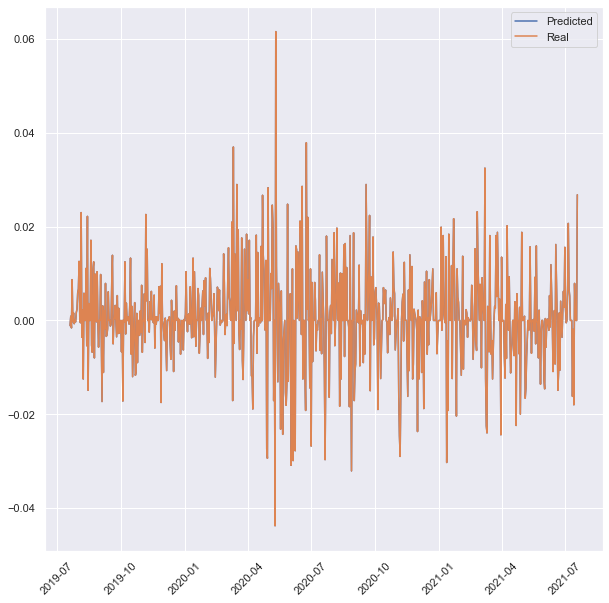

In [116]:
yhat_lr_dolar = pd.DataFrame(yhat_lr_dolar)
yhat_lr_dolar.set_index(y_test_dolar.index, inplace=True)
print('The R1 Score is: ',r2_score(yhat_lr_dolar, y_test_dolar))

plt.plot(yhat_lr_dolar, label='Predicted')
plt.plot(y_test_dolar, label='Real')
plt.xticks(rotation='45')
plt.legend();

### XGBoost Regressor

In [117]:
# Train Dataset
X_train_dolar = dolar[dolar.index < test_period]
y_train_dolar = X_train_dolar['daily_return_pct']

# Test Dataset
X_test_dolar = dolar[dolar.index >= test_period]
y_test_dolar = X_test_dolar['daily_return_pct']


In [118]:
# Model Definition
xgb_dolar = xgb.XGBRegressor(random_state=42)

dolar_cv_xgb = cross_validation(X_train_dolar, 10, 'XGBoost Regressor', xgb_dolar, verbose=True)
dolar_cv_xgb

Kfold Number: 10
Kfold Number: 9
Kfold Number: 8
Kfold Number: 7
Kfold Number: 6
Kfold Number: 5
Kfold Number: 4
Kfold Number: 3
Kfold Number: 2
Kfold Number: 1


Model            MAE cv          RMSE cv
0  XGBoost Regressor  0.01871+/-0.0045  0.0214+/-0.0037

In [119]:
### Train Dataset
X_train_dolar = dolar[dolar.index < test_period]
# Pre-processing
X_train_dolar = pre_processing(X_train_dolar)
y_train_dolar = X_train_dolar['daily_return_pct']

### Test Dataset
X_test_dolar = dolar[dolar.index >= test_period]
# Pre-processing
X_test_dolar = pre_processing(X_test_dolar)
y_test_dolar = X_test_dolar['daily_return_pct']

# Model Training
xgb_dolar.fit(X_train_dolar, y_train_dolar)

# Model prediction
yhat_xgb_dolar = xgb_dolar.predict(X_test_dolar)

# Model Performance
xgb_result_dolar = ml_error('XGB Regressor', y_test_dolar, yhat_xgb_dolar)
xgb_result_dolar

Model Name     MAE    RMSE
0  XGB Regressor 0.00034 0.00153

The R1 Score is:  0.98072581180669


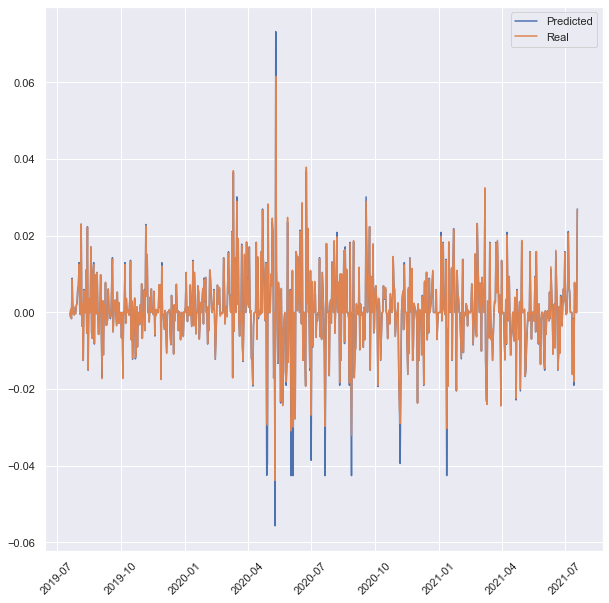

In [120]:
yhat_xgb_dolar = pd.DataFrame(yhat_xgb_dolar)
yhat_xgb_dolar.set_index(y_test_dolar.index, inplace=True)
print('The R1 Score is: ',r2_score(yhat_xgb_dolar, y_test_dolar))

plt.plot(yhat_xgb_dolar, label='Predicted')
plt.plot(y_test_dolar, label='Real')
plt.xticks(rotation='45')
plt.legend();

### Random Forest Regressor

In [121]:
# Train Dataset
X_train_dolar = dolar[dolar.index < test_period]
y_train_dolar = X_train_dolar['daily_return_pct']

# Test Dataset
X_test_dolar = dolar[dolar.index >= test_period]
y_test_dolar = X_test_dolar['daily_return_pct']

In [122]:
# Model Definition
rf_dolar = RandomForestRegressor(random_state=42)

dolar_cv_rf = cross_validation(X_train_dolar, 10, 'Random Forest Regressor', rf_dolar, verbose=True)
dolar_cv_rf

Kfold Number: 10
Kfold Number: 9
Kfold Number: 8
Kfold Number: 7
Kfold Number: 6
Kfold Number: 5
Kfold Number: 4
Kfold Number: 3
Kfold Number: 2
Kfold Number: 1


Model            MAE cv           RMSE cv
0  Random Forest Regressor  0.01855+/-0.0048  0.02042+/-0.0042

In [123]:
### Train Dataset
X_train_dolar = dolar[dolar.index < test_period]
# Pre-processing
X_train_dolar = pre_processing(X_train_dolar)
y_train_dolar = X_train_dolar['daily_return_pct']

### Test Dataset
X_test_dolar = dolar[dolar.index >= test_period]
# Pre-processing
X_test_dolar = pre_processing(X_test_dolar)
y_test_dolar = X_test_dolar['daily_return_pct']

# Model Training
rf_dolar.fit(X_train_dolar, y_train_dolar)

# Model prediction
yhat_rf_dolar = rf_dolar.predict(X_test_dolar)

# Model Performance
rf_result_dolar = ml_error('Random Forest Regressor', y_test_dolar, yhat_rf_dolar)
rf_result_dolar

Model Name     MAE    RMSE
0  Random Forest Regressor 0.00008 0.00049

The R1 Score is:  0.9977683688905638


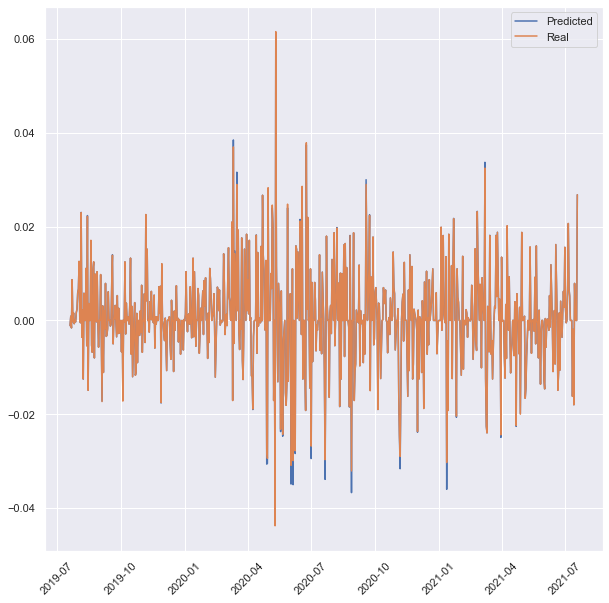

In [124]:
yhat_rf_dolar = pd.DataFrame(yhat_rf_dolar)
yhat_rf_dolar.set_index(y_test_dolar.index, inplace=True)
print('The R1 Score is: ',r2_score(yhat_rf_dolar, y_test_dolar))

plt.plot(yhat_rf_dolar, label='Predicted')
plt.plot(y_test_dolar, label='Real')
plt.xticks(rotation='45')
plt.legend();

## 7.2 BOVA11

In [125]:
# Train Dataset
X_train_bova11 = bova11[bova11.index < test_period]
y_train_bova11 = bova11[bova11.index < test_period]['daily_return_pct']

# Test Dataset
X_test_bova11 = bova11[bova11.index >= test_period]
y_test_bova11 = bova11[bova11.index >= test_period]['daily_return_pct']

### Linear Regression

In [126]:
# Model Definition
lr_bova11 = LinearRegression()

lr_cv_bova11 = cross_validation(X_train_bova11, 10, 'Linear Regression', lr_bova11, verbose=True)
lr_cv_bova11

Kfold Number: 10
Kfold Number: 9
Kfold Number: 8
Kfold Number: 7
Kfold Number: 6
Kfold Number: 5
Kfold Number: 4
Kfold Number: 3
Kfold Number: 2
Kfold Number: 1


Model            MAE cv           RMSE cv
0  Linear Regression  0.02867+/-0.0123  0.03211+/-0.0117

In [127]:
### Train Dataset
X_train_bova11 = bova11[bova11.index < test_period]
# Pre-processing
X_train_bova11 = pre_processing(X_train_bova11)
y_train_bova11 = X_train_bova11['daily_return_pct']

### Test Dataset
X_test_bova11 = bova11[bova11.index >= test_period]
# Pre-processing
X_test_bova11 = pre_processing(X_test_bova11)
y_test_bova11 = X_test_bova11['daily_return_pct']

# Model training
lr_bova11.fit(X_train_bova11, y_train_bova11)

# Model Prediction
yhat_lr_bova11 = lr_bova11.predict(X_test_bova11)

# Model Performance
lr_result_bova11 = ml_error('Linear Regression', y_test_bova11, yhat_lr_bova11)
lr_result_bova11

Model Name     MAE    RMSE
0  Linear Regression 0.00000 0.00000

The R1 Score is:  1.0


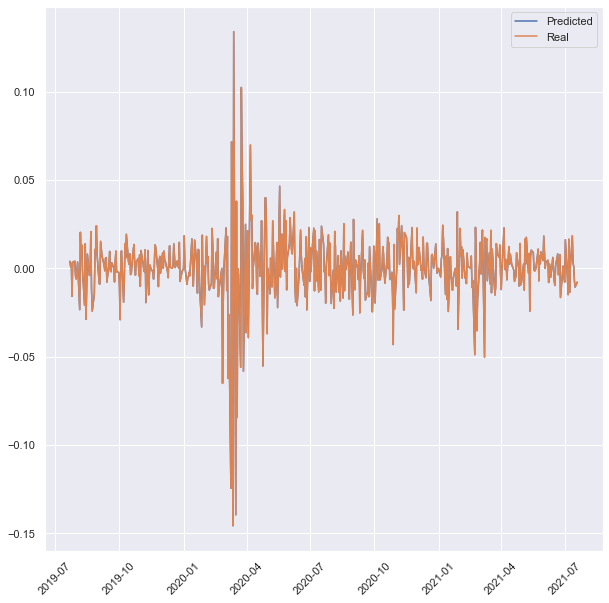

In [128]:
yhat_lr_bova11 = pd.DataFrame(yhat_lr_bova11)
yhat_lr_bova11.set_index(y_test_bova11.index, inplace=True)
print('The R1 Score is: ',r2_score(yhat_lr_bova11, y_test_bova11))

plt.plot(yhat_lr_bova11, label='Predicted')
plt.plot(y_test_bova11, label='Real')
plt.xticks(rotation='45')
plt.legend();

### XGB Regressor

In [129]:
# Train Dataset
X_train_bova11 = bova11[bova11.index < test_period]
y_train_bova11 = bova11[bova11.index < test_period]['daily_return_pct']

# Test Dataset
X_test_bova11 = bova11[bova11.index >= test_period]
y_test_bova11 = bova11[bova11.index >= test_period]['daily_return_pct']

In [130]:
# Model Definition
xgb_bova11 = xgb.XGBRegressor(random_state=42)

xgb_cv_bova11 = cross_validation(X_train_bova11, 10, 'XGBoost Regressor', xgb_bova11, verbose=True)
xgb_cv_bova11

Kfold Number: 10
Kfold Number: 9
Kfold Number: 8
Kfold Number: 7
Kfold Number: 6
Kfold Number: 5
Kfold Number: 4
Kfold Number: 3
Kfold Number: 2
Kfold Number: 1


Model            MAE cv           RMSE cv
0  XGBoost Regressor  0.02746+/-0.0118  0.03085+/-0.0112

In [131]:
### Train Dataset
X_train_bova11 = bova11[bova11.index < test_period]
# Pre-processing
X_train_bova11 = pre_processing(X_train_bova11)
y_train_bova11 = X_train_bova11['daily_return_pct']

### Test Dataset
X_test_bova11 = bova11[bova11.index >= test_period]
# Pre-processing
X_test_bova11 = pre_processing(X_test_bova11)
y_test_bova11 = X_test_bova11['daily_return_pct']

# Model training
xgb_bova11.fit(X_train_bova11, y_train_bova11)

# Model Prediction
yhat_xgb_bova11 = xgb_bova11.predict(X_test_bova11)

# Model Performance
xgb_result_bova11 = ml_error('XGBoost Regressor', y_test_bova11, yhat_xgb_bova11)
xgb_result_bova11

Model Name     MAE    RMSE
0  XGBoost Regressor 0.00090 0.00528

The R1 Score is:  0.9145206142972812


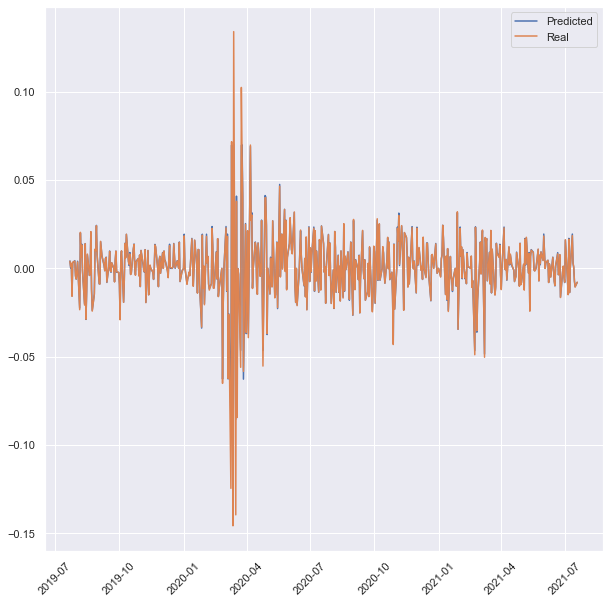

In [132]:
yhat_xgb_bova11 = pd.DataFrame(yhat_xgb_bova11)
yhat_xgb_bova11.set_index(y_test_bova11.index, inplace=True)
print('The R1 Score is: ',r2_score(yhat_xgb_bova11, y_test_bova11))

plt.plot(yhat_xgb_bova11, label='Predicted')
plt.plot(y_test_bova11, label='Real')
plt.xticks(rotation='45')
plt.legend();

### Random Forest Regressor

In [133]:
# Train Dataset
X_train_bova11 = bova11[bova11.index < test_period]
y_train_bova11 = bova11[bova11.index < test_period]['daily_return_pct']

# Test Dataset
X_test_bova11 = bova11[bova11.index >= test_period]
y_test_bova11 = bova11[bova11.index >= test_period]['daily_return_pct']

In [134]:
# Model Definition
rf_bova11 = RandomForestRegressor(random_state=42)

bova11_cv_rf = cross_validation(X_train_bova11, 10, 'Random Forest Regressor', rf_bova11, verbose=True)
bova11_cv_rf

Kfold Number: 10
Kfold Number: 9
Kfold Number: 8
Kfold Number: 7
Kfold Number: 6
Kfold Number: 5
Kfold Number: 4
Kfold Number: 3
Kfold Number: 2
Kfold Number: 1


Model           MAE cv           RMSE cv
0  Random Forest Regressor  0.0268+/-0.0107  0.02958+/-0.0098

In [135]:
### Train Dataset
X_train_bova11 = bova11[bova11.index < test_period]
# Pre-processing
X_train_bova11 = pre_processing(X_train_bova11)
y_train_bova11 = X_train_bova11['daily_return_pct']

### Test Dataset
X_test_bova11 = bova11[bova11.index >= test_period]
# Pre-processing
X_test_bova11 = pre_processing(X_test_bova11)
y_test_bova11 = X_test_bova11['daily_return_pct']

# Model training
rf_bova11.fit(X_train_bova11, y_train_bova11)

# Model Prediction
yhat_rf_bova11 = rf_bova11.predict(X_test_bova11)

# Model Performance
rf_result_bova11 = ml_error('Random Forest Regressor', y_test_bova11, yhat_rf_bova11)
rf_result_bova11

Model Name     MAE    RMSE
0  Random Forest Regressor 0.00084 0.00626

The R1 Score is:  0.8743216370138706


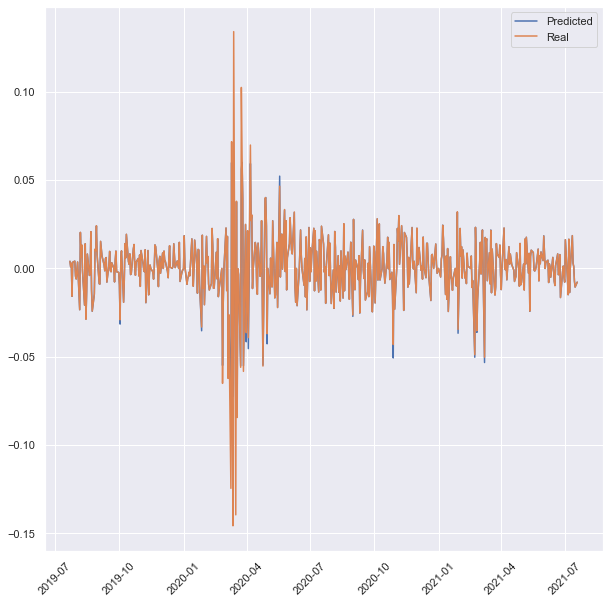

In [136]:
yhat_rf_bova11 = pd.DataFrame(yhat_rf_bova11)
yhat_rf_bova11.set_index(y_test_bova11.index, inplace=True)
print('The R1 Score is: ',r2_score(yhat_rf_bova11, y_test_bova11))

plt.plot(yhat_rf_bova11, label='Predicted')
plt.plot(y_test_bova11, label='Real')
plt.xticks(rotation='45')
plt.legend();

## 7.3 SMAL11

In [137]:
# Train Dataset
X_train_smal11 = smal11[smal11.index < test_period]
y_train_smal11 = X_train_smal11['daily_return_pct']

# Test Dataset
X_test_smal11 = smal11[smal11.index >= test_period]
y_test_smal11 = X_test_smal11['daily_return_pct']

### Linear Regression

In [138]:
# Model Definition
lr_smal11 = LinearRegression()

smal11_lr = cross_validation(X_train_smal11, 10, 'Linear Regression', lr_smal11, verbose=True)
smal11_lr

Kfold Number: 10
Kfold Number: 9
Kfold Number: 8
Kfold Number: 7
Kfold Number: 6
Kfold Number: 5
Kfold Number: 4
Kfold Number: 3
Kfold Number: 2
Kfold Number: 1


Model            MAE cv          RMSE cv
0  Linear Regression  0.02753+/-0.0119  0.03109+/-0.012

In [139]:
### Train Dataset
X_train_smal11 = smal11[smal11.index < test_period]
# Pre-processing
X_train_smal11 = pre_processing(X_train_smal11)
y_train_smal11 = X_train_smal11['daily_return_pct']

### Test Dataset
X_test_smal11 = smal11[smal11.index >= test_period]
# Pre-processing
X_test_smal11 = pre_processing(X_test_smal11)
y_test_smal11 = X_test_smal11['daily_return_pct']

# Model training
lr_smal11.fit(X_train_smal11, y_train_smal11)

# Model Prediction
yhat_lr_smal11 = lr_smal11.predict(X_test_smal11)

# Model Performance
lr_result_smal11 = ml_error('Linear Regression', y_test_smal11, yhat_lr_smal11)
lr_result_smal11

Model Name     MAE    RMSE
0  Linear Regression 0.00000 0.00000

The R1 Score is:  1.0


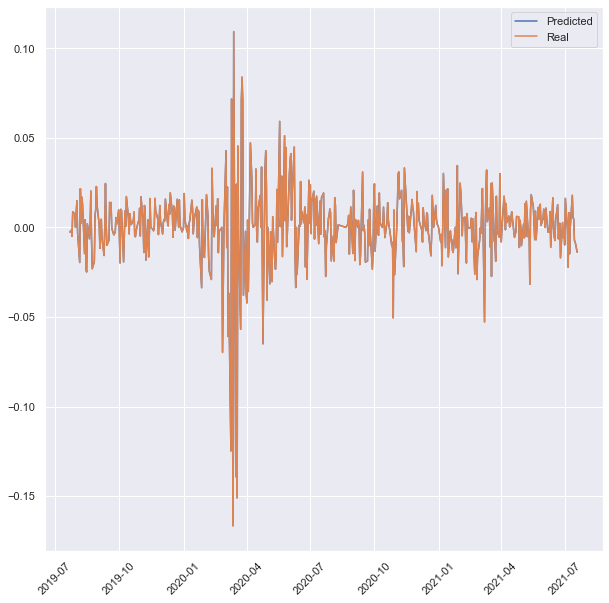

In [140]:
yhat_lr_smal11 = pd.DataFrame(yhat_lr_smal11)
yhat_lr_smal11.set_index(y_test_smal11.index, inplace=True)
print('The R1 Score is: ',r2_score(yhat_lr_smal11, y_test_smal11))

plt.plot(yhat_lr_smal11, label='Predicted')
plt.plot(y_test_smal11, label='Real')
plt.xticks(rotation='45')
plt.legend();

### XGB Regressor

In [141]:
# Train Dataset
X_train_smal11 = smal11[smal11.index < test_period]
y_train_smal11 = X_train_smal11['daily_return_pct']

# Test Dataset
X_test_smal11 = smal11[smal11.index >= test_period]
y_test_smal11 = X_test_smal11['daily_return_pct']

In [142]:
# Model Definition
xgb_smal11 = xgb.XGBRegressor(random_state=42)

smal11_xgb = cross_validation(X_train_smal11, 10, 'XGB Regressor', xgb_smal11, verbose=True)
smal11_xgb

Kfold Number: 10
Kfold Number: 9
Kfold Number: 8
Kfold Number: 7
Kfold Number: 6
Kfold Number: 5
Kfold Number: 4
Kfold Number: 3
Kfold Number: 2
Kfold Number: 1


Model           MAE cv           RMSE cv
0  XGB Regressor  0.0263+/-0.0103  0.02991+/-0.0104

In [143]:
### Train Dataset
X_train_smal11 = smal11[smal11.index < test_period]
# Pre-processing
X_train_smal11 = pre_processing(X_train_smal11)
y_train_smal11 = X_train_smal11['daily_return_pct']

### Test Dataset
X_test_smal11 = smal11[smal11.index >= test_period]
# Pre-processing
X_test_smal11 = pre_processing(X_test_smal11)
y_test_smal11 = X_test_smal11['daily_return_pct']

# Model training
xgb_smal11.fit(X_train_smal11, y_train_smal11)

# Model Prediction
yhat_xgb_smal11 = xgb_smal11.predict(X_test_smal11)

# Model Performance
xgb_result_smal11 = ml_error('XGBoost Regressor', y_test_smal11, yhat_xgb_smal11)
xgb_result_smal11

Model Name     MAE    RMSE
0  XGBoost Regressor 0.00135 0.00724

The R1 Score is:  0.8386286111220776


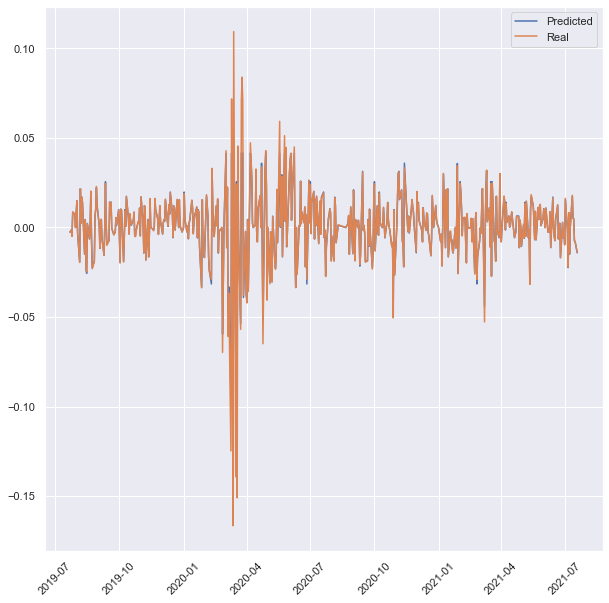

In [144]:
yhat_xgb_smal11 = pd.DataFrame(yhat_xgb_smal11)
yhat_xgb_smal11.set_index(y_test_smal11.index, inplace=True)
print('The R1 Score is: ',r2_score(yhat_xgb_smal11, y_test_smal11))

plt.plot(yhat_xgb_smal11, label='Predicted')
plt.plot(y_test_smal11, label='Real')
plt.xticks(rotation='45')
plt.legend();

### Random Forest Regressor

In [145]:
# Train Dataset
X_train_smal11 = smal11[smal11.index < test_period]
y_train_smal11 = X_train_smal11['daily_return_pct']

# Test Dataset
X_test_smal11 = smal11[smal11.index >= test_period]
y_test_smal11 = X_test_smal11['daily_return_pct']

In [146]:
# Model Definition
rf_smal11 = RandomForestRegressor(random_state=42)

smal11_rf = cross_validation(X_train_smal11, 10, 'XGB Regressor', rf_smal11, verbose=True)
smal11_rf

Kfold Number: 10
Kfold Number: 9
Kfold Number: 8
Kfold Number: 7
Kfold Number: 6
Kfold Number: 5
Kfold Number: 4
Kfold Number: 3
Kfold Number: 2
Kfold Number: 1


Model         MAE cv           RMSE cv
0  XGB Regressor  0.0258+/-0.01  0.02866+/-0.0099

In [147]:
### Train Dataset
X_train_smal11 = smal11[smal11.index < test_period]
# Pre-processing
X_train_smal11 = pre_processing(X_train_smal11)
y_train_smal11 = X_train_smal11['daily_return_pct']

### Test Dataset
X_test_smal11 = smal11[smal11.index >= test_period]
# Pre-processing
X_test_smal11 = pre_processing(X_test_smal11)
y_test_smal11 = X_test_smal11['daily_return_pct']

# Model training
rf_smal11.fit(X_train_smal11, y_train_smal11)

# Model Prediction
yhat_rf_smal11 = rf_smal11.predict(X_test_smal11)

# Model Performance
rf_result_smal11 = ml_error('Random Forest Regressor', y_test_smal11, yhat_rf_smal11)
rf_result_smal11

Model Name     MAE    RMSE
0  Random Forest Regressor 0.00127 0.00810

The R1 Score is:  0.7894269421145701


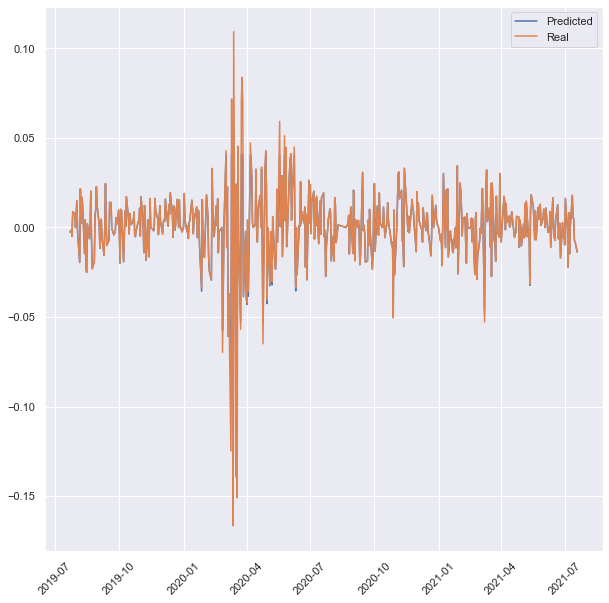

In [148]:
yhat_rf_smal11 = pd.DataFrame(yhat_rf_smal11)
yhat_rf_smal11.set_index(y_test_smal11.index, inplace=True)
print('The R1 Score is: ',r2_score(yhat_rf_smal11, y_test_smal11))

plt.plot(yhat_rf_smal11, label='Predicted')
plt.plot(y_test_smal11, label='Real')
plt.xticks(rotation='45')
plt.legend();

## 7.4 Bitcoin

In [149]:
# Train Dataset
X_train_bitcoin = bitcoin[bitcoin.index < test_period]
y_train_bitcoin1 = bitcoin[bitcoin.index < test_period]['daily_return_pct']

# Test Dataset
X_test_bitcoin = bitcoin[bitcoin.index >= test_period]
y_test_bitcoin = bitcoin[bitcoin.index >= test_period]['daily_return_pct']

### Linear Regression

In [150]:
# Model Definition
lr_bit = LinearRegression()

lr_cv_bit = cross_validation(X_train_bitcoin, 10, 'Linear Regression', lr_bit, verbose=True )
lr_cv_bit

Kfold Number: 10
Kfold Number: 9
Kfold Number: 8
Kfold Number: 7
Kfold Number: 6
Kfold Number: 5
Kfold Number: 4
Kfold Number: 3
Kfold Number: 2
Kfold Number: 1


Model            MAE cv           RMSE cv
0  Linear Regression  0.14485+/-0.0575  0.15771+/-0.0589

In [151]:
### Train Dataset
X_train_bitcoin = bitcoin[bitcoin.index < test_period]
# Pre-processing
X_train_bitcoin = pre_processing(X_train_bitcoin)
y_train_bitcoin = X_train_bitcoin['daily_return_pct']

### Test Dataset
X_test_bitcoin = bitcoin[bitcoin.index >= test_period]
# Pre-processing
X_test_bitcoin = pre_processing(X_test_bitcoin)
y_test_bitcoin = X_test_bitcoin['daily_return_pct']

# Model training
lr_bit.fit(X_train_bitcoin, y_train_bitcoin)

# Model Prediction
yhat_lr_bitcoin = lr_bit.predict(X_test_bitcoin)

# Model Performance
lr_result_bitcoin = ml_error('Linear Regression', y_test_bitcoin, yhat_lr_bitcoin)
lr_result_bitcoin

Model Name     MAE    RMSE
0  Linear Regression 0.00000 0.00000

The R1 Score is:  1.0


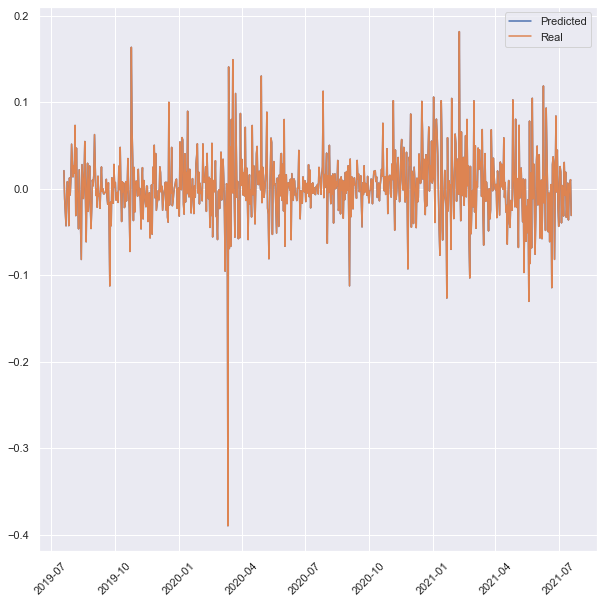

In [152]:
yhat_lr_bitcoin = pd.DataFrame(yhat_lr_bitcoin)
yhat_lr_bitcoin.set_index(y_test_bitcoin.index, inplace=True)
print('The R1 Score is: ',r2_score(yhat_lr_bitcoin, y_test_bitcoin))

plt.plot(yhat_lr_bitcoin, label='Predicted')
plt.plot(y_test_bitcoin, label='Real')
plt.xticks(rotation='45')
plt.legend();

### XGB Regressor

In [153]:
# Train Dataset
X_train_bitcoin = bitcoin[bitcoin.index < test_period]
y_train_bitcoin1 = bitcoin[bitcoin.index < test_period]['daily_return_pct']

# Test Dataset
X_test_bitcoin = bitcoin[bitcoin.index >= test_period]
y_test_bitcoin = bitcoin[bitcoin.index >= test_period]['daily_return_pct']

In [154]:
# Model Definition
xgb_bitcoin = xgb.XGBRegressor(random_state=42)

bitcoin_xgb = cross_validation(X_train_bitcoin, 10, 'XGB Regressor', xgb_bitcoin, verbose=True)
bitcoin_xgb

Kfold Number: 10
Kfold Number: 9
Kfold Number: 8
Kfold Number: 7
Kfold Number: 6
Kfold Number: 5
Kfold Number: 4
Kfold Number: 3
Kfold Number: 2
Kfold Number: 1


Model            MAE cv          RMSE cv
0  XGB Regressor  0.13101+/-0.0271  0.15679+/-0.029

In [155]:
### Train Dataset
X_train_bitcoin = bitcoin[bitcoin.index < test_period]
# Pre-processing
X_train_bitcoin = pre_processing(X_train_bitcoin)
y_train_bitcoin = X_train_bitcoin['daily_return_pct']

### Test Dataset
X_test_bitcoin = bitcoin[bitcoin.index >= test_period]
# Pre-processing
X_test_bitcoin = pre_processing(X_test_bitcoin)
y_test_bitcoin = X_test_bitcoin['daily_return_pct']

# Model training
xgb_bitcoin.fit(X_train_bitcoin, y_train_bitcoin)

# Model Prediction
yhat_xgb_bitcoin = xgb_bitcoin.predict(X_test_bitcoin)

# Model Performance
xgb_result_bitcoin = ml_error('XGBoost Regressor', y_test_bitcoin, yhat_xgb_bitcoin)
xgb_result_bitcoin

Model Name     MAE    RMSE
0  XGBoost Regressor 0.00049 0.00091

The R1 Score is:  0.9994808752847769


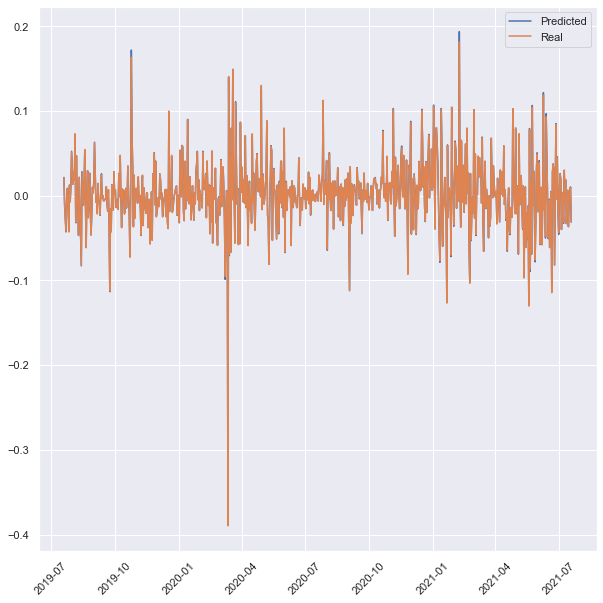

In [156]:
yhat_xgb_bitcoin = pd.DataFrame(yhat_xgb_bitcoin)
yhat_xgb_bitcoin.set_index(y_test_bitcoin.index, inplace=True)
print('The R1 Score is: ',r2_score(yhat_xgb_bitcoin, y_test_bitcoin))

plt.plot(yhat_xgb_bitcoin, label='Predicted')
plt.plot(y_test_bitcoin, label='Real')
plt.xticks(rotation='45')
plt.legend();

### Random Foret Regressor

In [157]:
# Train Dataset
X_train_bitcoin = bitcoin[bitcoin.index < test_period]
y_train_bitcoin1 = bitcoin[bitcoin.index < test_period]['daily_return_pct']

# Test Dataset
X_test_bitcoin = bitcoin[bitcoin.index >= test_period]
y_test_bitcoin = bitcoin[bitcoin.index >= test_period]['daily_return_pct']

In [158]:
# Model Definition
rf_bitcoin = RandomForestRegressor(random_state=42)

bitcoin_rf = cross_validation(X_train_bitcoin, 10, 'Random Forest Regressor', rf_bitcoin, verbose=True)
bitcoin_rf

Kfold Number: 10
Kfold Number: 9
Kfold Number: 8
Kfold Number: 7
Kfold Number: 6
Kfold Number: 5
Kfold Number: 4
Kfold Number: 3
Kfold Number: 2
Kfold Number: 1


Model            MAE cv           RMSE cv
0  Random Forest Regressor  0.12268+/-0.0196  0.13587+/-0.0198

In [159]:
### Train Dataset
X_train_bitcoin = bitcoin[bitcoin.index < test_period]
# Pre-processing
X_train_bitcoin = pre_processing(X_train_bitcoin)
y_train_bitcoin = X_train_bitcoin['daily_return_pct']

### Test Dataset
X_test_bitcoin = bitcoin[bitcoin.index >= test_period]
# Pre-processing
X_test_bitcoin = pre_processing(X_test_bitcoin)
y_test_bitcoin = X_test_bitcoin['daily_return_pct']

# Model training
rf_bitcoin.fit(X_train_bitcoin, y_train_bitcoin)

# Model Prediction
yhat_rf_bitcoin = rf_bitcoin.predict(X_test_bitcoin)

# Model Performance
rf_result_bitcoin = ml_error('Random Forest Regressor', y_test_bitcoin, yhat_rf_bitcoin)
rf_result_bitcoin

Model Name     MAE    RMSE
0  Random Forest Regressor 0.00014 0.00206

The R1 Score is:  0.997224058055702


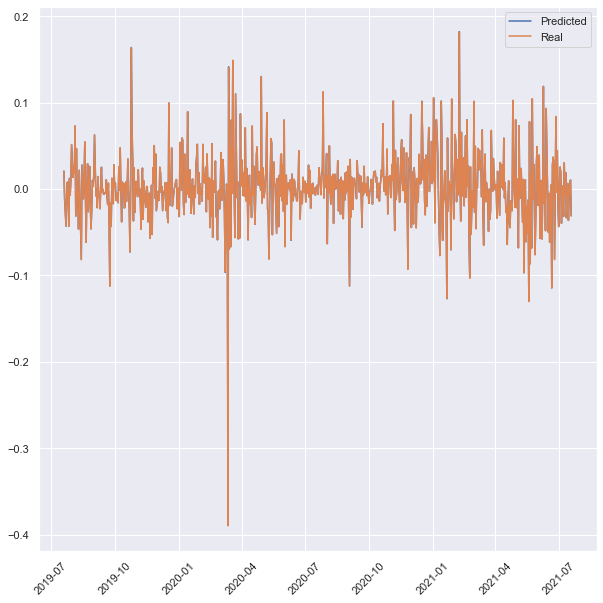

In [160]:
yhat_rf_bitcoin = pd.DataFrame(yhat_rf_bitcoin)
yhat_rf_bitcoin.set_index(y_test_bitcoin.index, inplace=True)
print('The R1 Score is: ',r2_score(yhat_rf_bitcoin, y_test_bitcoin))


plt.plot(yhat_rf_bitcoin, label='Predicted')
plt.plot(y_test_bitcoin, label='Real')
plt.xticks(rotation='45')
plt.legend();

## 7.5 Ether

In [161]:
# Train Dataset
X_train_ether = ether[ether.index < test_period]
y_train_ether = ether[ether.index < test_period]['daily_return_pct']

# Test Dataset
X_test_ether = ether[ether.index >= test_period]
y_test_ether = ether[ether.index >= test_period]['daily_return_pct']

### Linear Regression

In [162]:
lr_ether = LinearRegression()

lr_cv_ether = cross_validation(X_train_ether, 10, 'Linear Regression', lr_ether, verbose=True)
lr_cv_ether

Kfold Number: 10
Kfold Number: 9
Kfold Number: 8
Kfold Number: 7
Kfold Number: 6
Kfold Number: 5
Kfold Number: 4
Kfold Number: 3
Kfold Number: 2
Kfold Number: 1


Model            MAE cv           RMSE cv
0  Linear Regression  0.09182+/-0.0381  0.10414+/-0.0383

In [163]:
### Train Dataset
X_train_ether = ether[ether.index < test_period]
# Pre-processing
X_train_ether = pre_processing(X_train_ether)
y_train_ether = X_train_ether['daily_return_pct']

### Test Dataset
X_test_ether = ether[ether.index >= test_period]
# Pre-processing
X_test_ether = pre_processing(X_test_ether)
y_test_ether = X_test_ether['daily_return_pct']

# Model training
lr_ether.fit(X_train_ether, y_train_ether)

# Model Prediction
yhat_lr_ether = lr_ether.predict(X_test_ether)

# Model Performance
lr_result_ether = ml_error('Linear Regression', y_test_ether, yhat_lr_ether)
lr_result_ether

Model Name     MAE    RMSE
0  Linear Regression 0.00000 0.00000

The R1 Score is:  1.0


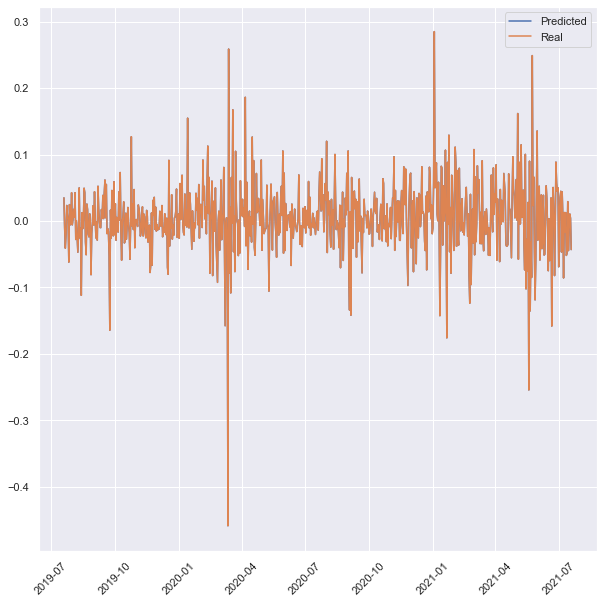

In [164]:
yhat_lr_ether = pd.DataFrame(yhat_lr_ether)
yhat_lr_ether.set_index(y_test_ether.index, inplace=True)
print('The R1 Score is: ',r2_score(yhat_lr_ether, y_test_ether))

plt.plot(yhat_lr_ether, label='Predicted')
plt.plot(y_test_ether, label='Real')
plt.xticks(rotation='45')
plt.legend();

### XGB Regressor

In [165]:
# Train Dataset
X_train_ether = ether[ether.index < test_period]
y_train_ether = ether[ether.index < test_period]['daily_return_pct']

# Test Dataset
X_test_ether = ether[ether.index >= test_period]
y_test_ether = ether[ether.index >= test_period]['daily_return_pct']

In [166]:
xgb_ether = xgb.XGBRegressor(random_state=42)

xgb_cv_ether = cross_validation(X_train_ether, 10, 'XGBoost Regressor', xgb_ether, verbose=True)
xgb_cv_ether

Kfold Number: 10
Kfold Number: 9
Kfold Number: 8
Kfold Number: 7
Kfold Number: 6
Kfold Number: 5
Kfold Number: 4
Kfold Number: 3
Kfold Number: 2
Kfold Number: 1


Model            MAE cv           RMSE cv
0  XGBoost Regressor  0.11514+/-0.0489  0.14712+/-0.0629

In [167]:
### Train Dataset
X_train_ether = ether[ether.index < test_period]
# Pre-processing
X_train_ether = pre_processing(X_train_ether)
y_train_ether = X_train_ether['daily_return_pct']

### Test Dataset
X_test_ether = ether[ether.index >= test_period]
# Pre-processing
X_test_ether = pre_processing(X_test_ether)
y_test_ether = X_test_ether['daily_return_pct']

# Model training
xgb_ether.fit(X_train_ether, y_train_ether)

# Model Prediction
yhat_xgb_ether = xgb_ether.predict(X_test_ether)

# Model Performance
xgb_result_ether = ml_error('XGBoost Regressor', y_test_ether, yhat_xgb_ether)
xgb_result_ether

Model Name     MAE    RMSE
0  XGBoost Regressor 0.00148 0.00727

The R1 Score is:  0.9796025520364736


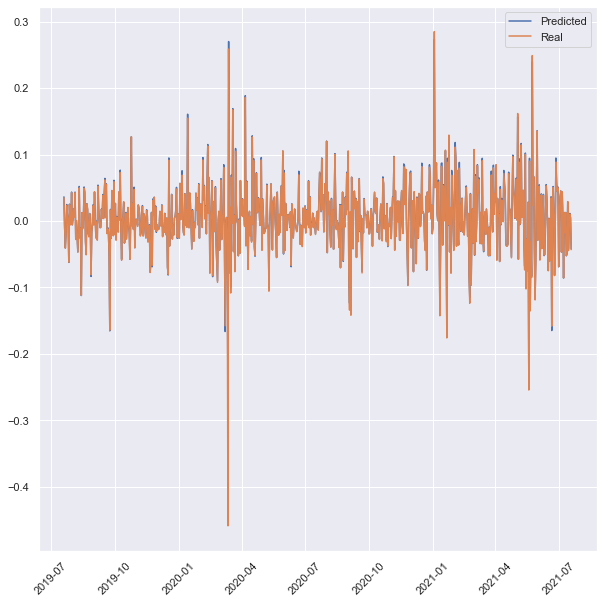

In [168]:
yhat_xgb_ether = pd.DataFrame(yhat_xgb_ether)
yhat_xgb_ether.set_index(y_test_ether.index, inplace=True)
print('The R1 Score is: ',r2_score(yhat_xgb_ether, y_test_ether))

plt.plot(yhat_xgb_ether, label='Predicted')
plt.plot(y_test_ether, label='Real')
plt.xticks(rotation='45')
plt.legend();

### Random Forest Regressor

In [169]:
# Train Dataset
X_train_ether = ether[ether.index < test_period]
y_train_ether = ether[ether.index < test_period]['daily_return_pct']

# Test Dataset
X_test_ether = ether[ether.index >= test_period]
y_test_ether = ether[ether.index >= test_period]['daily_return_pct']

In [170]:
rf_ether = RandomForestRegressor(random_state=42)

rf_cv_ether = cross_validation(X_train_ether, 10, 'Random Forest Regressor', rf_ether, verbose=True)
rf_cv_ether

Kfold Number: 10
Kfold Number: 9
Kfold Number: 8
Kfold Number: 7
Kfold Number: 6
Kfold Number: 5
Kfold Number: 4
Kfold Number: 3
Kfold Number: 2
Kfold Number: 1


Model            MAE cv          RMSE cv
0  Random Forest Regressor  0.10192+/-0.0393  0.1173+/-0.0447

In [171]:
### Train Dataset
X_train_ether = ether[ether.index < test_period]
# Pre-processing
X_train_ether = pre_processing(X_train_ether)
y_train_ether = X_train_ether['daily_return_pct']

### Test Dataset
X_test_ether = ether[ether.index >= test_period]
# Pre-processing
X_test_ether = pre_processing(X_test_ether)
y_test_ether = X_test_ether['daily_return_pct']

# Model training
rf_ether.fit(X_train_ether, y_train_ether)

# Model Prediction
yhat_rf_ether = rf_ether.predict(X_test_ether)

# Model Performance
rf_result_ether = ml_error('Random Forest Regressor', y_test_ether, yhat_rf_ether)
rf_result_ether

Model Name     MAE    RMSE
0  Random Forest Regressor 0.00061 0.00746

The R1 Score is:  0.9785941361062098


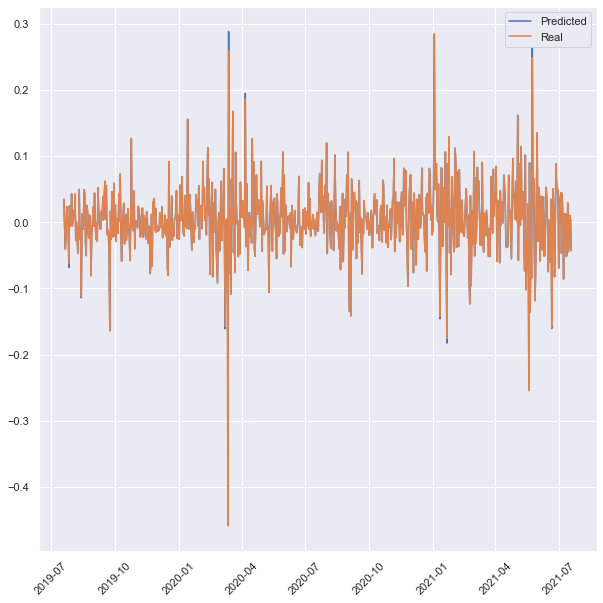

In [172]:
yhat_rf_ether = pd.DataFrame(yhat_rf_ether)
yhat_rf_ether.set_index(y_test_ether.index, inplace=True)
print('The R1 Score is: ',r2_score(yhat_rf_ether, y_test_ether))

plt.plot(yhat_rf_ether, label='Predicted')
plt.plot(y_test_ether, label='Real')
plt.xticks(rotation='45')
plt.legend();

# 8.0 Hyperparameter Fine-Tunning

## 8.2 Dolar

In [173]:
# Train Dataset
X_train_dolar = dolar[dolar.index < test_period]
y_train_dolar = X_train_dolar['daily_return_pct']

# Test Dataset
X_test_dolar = dolar[dolar.index >= test_period]
y_test_dolar = X_test_dolar['daily_return_pct']


In [174]:
# param ={
#     'n_estimators':[50, 200, 1000, 1500, 3000],
#     'eta':[0.01,0.03],
#     'max_depth':[3,5,9],
#     'subsample':[0.1,0.5,0.7],
#     'colsample_bytree':[0.3,0.7,0.9],
#     'min_child_weight':[3,8,15]}
# max_eval = 10

# final_result = pd.DataFrame()
# for i in range(max_eval):
#     # Randomly choose values for parameters
#     hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
#     print(hp)
#     # model
#     model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                   n_estimators=hp['n_estimators'], 
#                                   eta=hp['eta'], 
#                                   max_depth=hp['max_depth'], 
#                                   subsample=hp['subsample'],
#                                   colsample_bytree=hp['colsample_bytree'],
#                                   min_child_weight=hp['min_child_weight'])


#     # performance
#     result = cross_validation(X_train_dolar, 5, 'XGBoost Regressor', model_xgb, verbose=False)
#     final_result = pd.concat([final_result, result])
    
# final_result

In [175]:
# cv 0.01123+/-0.0039 	0.01268+/-0.0036 ||  result 0.00478
#param_dolar_tuned = {'n_estimators': 1500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 3}
# cv 0.01039+/-0.0041 	0.01188+/-0.0038 ||  result 0.00512
param_dolar_tuned = {'n_estimators': 1000, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 15}

xgb_dolar_tunned = xgb.XGBRegressor( objective='reg:squarederror',
                                  n_estimators=param_dolar_tuned['n_estimators'], 
                                  eta=param_dolar_tuned['eta'], 
                                  max_depth=param_dolar_tuned['max_depth'], 
                                  subsample=param_dolar_tuned['subsample'],
                                  colsample_bytree=param_dolar_tuned['colsample_bytree'],
                                  min_child_weight=param_dolar_tuned['min_child_weight'])


### Train Dataset
X_train_dolar = dolar[dolar.index < test_period]
# Pre-processing
X_train_dolar = pre_processing(X_train_dolar)
y_train_dolar = X_train_dolar['daily_return_pct']

### Test Dataset
X_test_dolar = dolar[dolar.index >= test_period]
# Pre-processing
X_test_dolar = pre_processing(X_test_dolar)
y_test_dolar = X_test_dolar['daily_return_pct']

# Model Training
xgb_dolar_tunned.fit(X_train_dolar, y_train_dolar)

# Model prediction
yhat_xgb_dolar_tunned = xgb_dolar_tunned.predict(X_test_dolar)


# Model Performance
xgb_result_dolar_tunned = ml_error('XGB Regressor', y_test_dolar, yhat_xgb_dolar_tunned)
xgb_result_dolar_tunned

Model Name     MAE    RMSE
0  XGB Regressor 0.00512 0.00540

In [176]:
# Convert predict values into dataframe
yhat_xgb_dolar_tunned = pd.DataFrame(yhat_xgb_dolar_tunned)
yhat_xgb_dolar_tunned.set_index(y_test_dolar.index, inplace=True)

## 8.3 Bova11

In [177]:
# Train Dataset
X_train_bova11 = bova11[bova11.index < test_period]
y_train_bova11 = bova11[bova11.index < test_period]['daily_return_pct']

# Test Dataset
X_test_bova11 = bova11[bova11.index >= test_period]
y_test_bova11 = bova11[bova11.index >= test_period]['daily_return_pct']

In [178]:
# param ={
#     'n_estimators':[1500,1700,2500,3000,3500],
#     'eta':[0.01,0.03],
#     'max_depth':[3,5,9],
#     'subsample':[0.1,0.5,0.7],
#     'colsample_bytree':[0.3,0.7,0.9],
#     'min_child_weight':[3,8,15]}
# max_eval = 10

# final_result = pd.DataFrame()
# for i in range(max_eval):
#     # Randomly choose values for parameters
#     hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
#     print(hp)
#     # model
#     model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                   n_estimators=hp['n_estimators'], 
#                                   eta=hp['eta'], 
#                                   max_depth=hp['max_depth'], 
#                                   subsample=hp['subsample'],
#                                   colsample_bytree=hp['colsample_bytree'],
#                                   min_child_weight=hp['min_child_weight'])


#     # performance
#     result = cross_validation(X_train_bova11, 5, 'XGBoost Regressor', model_xgb, verbose=False)
#     final_result = pd.concat([final_result, result])
    
# final_result

In [179]:
# cv 0.02075+/-0.0085 	0.02301+/-0.0082 || result 0.00293
#param_bova11_tuned = {'n_estimators': 1700, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 8}
param_bova11_tuned = {'n_estimators': 1700, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 8}

xgb_bova11_tunned = xgb.XGBRegressor( objective='reg:squarederror',
                                  n_estimators= param_bova11_tuned['n_estimators'], 
                                  eta= param_bova11_tuned['eta'], 
                                  max_depth= param_bova11_tuned['max_depth'], 
                                  subsample= param_bova11_tuned['subsample'],
                                  colsample_bytree= param_bova11_tuned['colsample_bytree'],
                                  min_child_weight= param_bova11_tuned['min_child_weight'])


### Train Dataset
X_train_bova11 = bova11[bova11.index < test_period]
# Pre-processing
X_train_bova11 = pre_processing(X_train_bova11)
y_train_bova11 = X_train_bova11['daily_return_pct']

### Test Dataset
X_test_bova11 = bova11[bova11.index >= test_period]
# Pre-processing
X_test_bova11 = pre_processing(X_test_bova11)
y_test_bova11 = X_test_bova11['daily_return_pct']

# Model training
xgb_bova11_tunned.fit(X_train_bova11, y_train_bova11)

# Model Prediction
yhat_xgb_bova11_tunned = xgb_bova11_tunned.predict(X_test_bova11)

# Model Performance
xgb_result_bova11_tunned = ml_error('XGBoost Regressor', y_test_bova11, yhat_xgb_bova11_tunned)
xgb_result_bova11_tunned

Model Name     MAE    RMSE
0  XGBoost Regressor 0.00493 0.01076

In [180]:
# Convert predict values into dataframe
yhat_xgb_bova11_tunned = pd.DataFrame(yhat_xgb_bova11_tunned)
yhat_xgb_bova11_tunned.set_index(y_test_bova11.index, inplace=True)

## 8.3 Smal11

In [181]:
# Train Dataset
X_train_smal11 = smal11[smal11.index < test_period]
y_train_smal11 = X_train_smal11['daily_return_pct']

# Test Dataset
X_test_smal11 = smal11[smal11.index >= test_period]
y_test_smal11 = X_test_smal11['daily_return_pct']

In [182]:
# param ={
#     'n_estimators':[50, 200, 1000, 1500, 3000],
#     'eta':[0.01,0.03],
#     'max_depth':[3,5,9],
#     'subsample':[0.1,0.5,0.7],
#     'colsample_bytree':[0.3,0.7,0.9],
#     'min_child_weight':[3,8,15]}
# max_eval = 10

# final_result = pd.DataFrame()
# for i in range(max_eval):
#     # Randomly choose values for parameters
#     hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
#     print(hp)
#     # model
#     model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                   n_estimators=hp['n_estimators'], 
#                                   eta=hp['eta'], 
#                                   max_depth=hp['max_depth'], 
#                                   subsample=hp['subsample'],
#                                   colsample_bytree=hp['colsample_bytree'],
#                                   min_child_weight=hp['min_child_weight'])


#     # performance
#     result = cross_validation(X_train_smal11, 5, 'XGBoost Regressor', model_xgb, verbose=False)
#     final_result = pd.concat([final_result, result])
    
# final_result

In [183]:
param_smal11_tuned = {'n_estimators': 1000, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 15}
xgb_smal11_tunned = xgb.XGBRegressor( objective='reg:squarederror',
                                  n_estimators= param_smal11_tuned['n_estimators'], 
                                  eta= param_smal11_tuned['eta'], 
                                  max_depth= param_smal11_tuned['max_depth'], 
                                  subsample= param_smal11_tuned['subsample'],
                                  colsample_bytree= param_smal11_tuned['colsample_bytree'],
                                  min_child_weight= param_smal11_tuned['min_child_weight'])

### Train Dataset
X_train_smal11 = smal11[smal11.index < test_period]
# Pre-processing
X_train_smal11 = pre_processing(X_train_smal11)
y_train_smal11 = X_train_smal11['daily_return_pct']

### Test Dataset
X_test_smal11 = smal11[smal11.index >= test_period]
# Pre-processing
X_test_smal11 = pre_processing(X_test_smal11)
y_test_smal11 = X_test_smal11['daily_return_pct']

# Model training
xgb_smal11_tunned.fit(X_train_smal11, y_train_smal11)

# Model Prediction
yhat_xgb_smal11_tunned = xgb_smal11_tunned.predict(X_test_smal11)

# Model Performance
xgb_result_smal11_tunned = ml_error('XGBoost Regressor', y_test_smal11, yhat_xgb_smal11_tunned)
xgb_result_smal11_tunned

Model Name     MAE    RMSE
0  XGBoost Regressor 0.00517 0.01190

In [184]:
# Convert predict values into dataframe
yhat_xgb_smal11_tunned = pd.DataFrame(yhat_xgb_smal11_tunned)
yhat_xgb_smal11_tunned.set_index(y_test_smal11.index, inplace=True)

## 8.4 Bitcoin

In [185]:
# Train Dataset
X_train_bitcoin = bitcoin[bitcoin.index < test_period]
y_train_bitcoin1 = bitcoin[bitcoin.index < test_period]['daily_return_pct']

# Test Dataset
X_test_bitcoin = bitcoin[bitcoin.index >= test_period]
y_test_bitcoin = bitcoin[bitcoin.index >= test_period]['daily_return_pct']

In [186]:
# param ={
#     'n_estimators':[50, 200, 1000, 1500, 3000],
#     'eta':[0.01,0.03],
#     'max_depth':[3,5,9],
#     'subsample':[0.1,0.5,0.7],
#     'colsample_bytree':[0.3,0.7,0.9],
#     'min_child_weight':[3,8,15]}
# max_eval = 10

# final_result = pd.DataFrame()
# for i in range(max_eval):
#     # Randomly choose values for parameters
#     hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
#     print(hp)
#     # model
#     model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                   n_estimators=hp['n_estimators'], 
#                                   eta=hp['eta'], 
#                                   max_depth=hp['max_depth'], 
#                                   subsample=hp['subsample'],
#                                   colsample_bytree=hp['colsample_bytree'],
#                                   min_child_weight=hp['min_child_weight'])


#     # performance
#     result = cross_validation(X_train_bitcoin, 5, 'XGBoost Regressor', model_xgb, verbose=False)
#     final_result = pd.concat([final_result, result])
    
# final_result

In [187]:
param_bitcoin_tuned = {'n_estimators': 200, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 8}
xgb_bitcoin_tunned = xgb.XGBRegressor( objective='reg:squarederror',
                                  n_estimators= param_bitcoin_tuned['n_estimators'], 
                                  eta= param_bitcoin_tuned['eta'], 
                                  max_depth= param_bitcoin_tuned['max_depth'], 
                                  subsample= param_bitcoin_tuned['subsample'],
                                  colsample_bytree= param_bitcoin_tuned['colsample_bytree'],
                                  min_child_weight= param_bitcoin_tuned['min_child_weight'])

### Train Dataset
X_train_bitcoin = bitcoin[bitcoin.index < test_period]
# Pre-processing
X_train_bitcoin = pre_processing(X_train_bitcoin)
y_train_bitcoin = X_train_bitcoin['daily_return_pct']

### Test Dataset
X_test_bitcoin = bitcoin[bitcoin.index >= test_period]
# Pre-processing
X_test_bitcoin = pre_processing(X_test_bitcoin)
y_test_bitcoin = X_test_bitcoin['daily_return_pct']

# Model training
xgb_bitcoin_tunned.fit(X_train_bitcoin, y_train_bitcoin)

# Model Prediction
yhat_xgb_bitcoin_tunned = xgb_bitcoin_tunned.predict(X_test_bitcoin)

# Model Performance
xgb_result_bitcoin_tunned = ml_error('XGBoost Regressor', y_test_bitcoin, yhat_xgb_bitcoin_tunned)
xgb_result_bitcoin_tunned

Model Name     MAE    RMSE
0  XGBoost Regressor 0.01352 0.01758

In [188]:
# Convert predict values into dataframe
yhat_xgb_bitcoin_tunned = pd.DataFrame(yhat_xgb_bitcoin_tunned)
yhat_xgb_bitcoin_tunned.set_index(y_test_bitcoin.index, inplace=True)

## 8.5 Ether

In [189]:
# Train Dataset
X_train_ether = ether[ether.index < test_period]
y_train_ether = ether[ether.index < test_period]['daily_return_pct']

# Test Dataset
X_test_ether = ether[ether.index >= test_period]
y_test_ether = ether[ether.index >= test_period]['daily_return_pct']

In [190]:
# param ={
#     'n_estimators':[50, 200, 1000, 1500, 3000],
#     'eta':[0.01,0.03],
#     'max_depth':[3,5,9],
#     'subsample':[0.1,0.5,0.7],
#     'colsample_bytree':[0.3,0.7,0.9],
#     'min_child_weight':[3,8,15]}
# max_eval = 10

# final_result = pd.DataFrame()
# for i in range(max_eval):
#     # Randomly choose values for parameters
#     hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
#     print(hp)
#     # model
#     model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                   n_estimators=hp['n_estimators'], 
#                                   eta=hp['eta'], 
#                                   max_depth=hp['max_depth'], 
#                                   subsample=hp['subsample'],
#                                   colsample_bytree=hp['colsample_bytree'],
#                                   min_child_weight=hp['min_child_weight'])


#     # performance
#     result = cross_validation(X_train_ether, 5, 'XGBoost Regressor', model_xgb, verbose=False)
#     final_result = pd.concat([final_result, result])
    
# final_result

In [191]:
param_ether_tuned = {'n_estimators': 1000, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 15}
xgb_ether_tunned = xgb.XGBRegressor( objective='reg:squarederror',
                                  n_estimators= param_ether_tuned['n_estimators'], 
                                  eta= param_ether_tuned['eta'], 
                                  max_depth= param_ether_tuned['max_depth'], 
                                  subsample= param_ether_tuned['subsample'],
                                  colsample_bytree= param_ether_tuned['colsample_bytree'],
                                  min_child_weight= param_ether_tuned['min_child_weight'])

### Train Dataset
X_train_ether = ether[ether.index < test_period]
# Pre-processing
X_train_ether = pre_processing(X_train_ether)
y_train_ether = X_train_ether['daily_return_pct']

### Test Dataset
X_test_ether = ether[ether.index >= test_period]
# Pre-processing
X_test_ether = pre_processing(X_test_ether)
y_test_ether = X_test_ether['daily_return_pct']

# Model training
xgb_ether_tunned.fit(X_train_ether, y_train_ether)

# Model Prediction
yhat_xgb_ether_tunned = xgb_ether_tunned.predict(X_test_ether)

# Model Performance
xgb_result_ether_tunned = ml_error('XGBoost Regressor', y_test_ether, yhat_xgb_ether_tunned)
xgb_result_ether_tunned

Model Name     MAE    RMSE
0  XGBoost Regressor 0.01039 0.01395

In [192]:
# Convert predict values into dataframe
yhat_xgb_ether_tunned = pd.DataFrame(yhat_xgb_ether_tunned)
yhat_xgb_ether_tunned.set_index(y_test_ether.index, inplace=True)

# 9.0 Business Report

## 9.1 Portfolio proposal

Com intuito de traduzir as performance de Machine Learning em resultados de negócio, utilizaremos novamente a **Simulação de Monte Cartlo**, com auxílido da visualização da **Fronteira Eficiente**, para traçar uma recomendação de carteira ideal de investimento. 

O procedimento é o seguinte: definiremos um número de portfólio a serem criados de modo que os pesos de alocação para cada ativo sejam gerados aleatoriamente. Em cima disso, a Simulação de Monte Carlo resulta numa planilha como todos os portfólios gerados e suas respectivas rentabilidades e riscos. Ordenaremos esses portfólios para sabermos os Top 5 melhores portfólio em termos de retorno.

In [193]:
def concat_final_return(yhat_dolar, yhat_bova11, yhat_smal11, yhat_bitcoin, yhat_ether):
    # Change all the predict values column names to daily_return_pct before the merge
    for df in [yhat_dolar, yhat_bova11, yhat_smal11, yhat_bitcoin, yhat_ether]:
        df.columns = ['daily_return_pct']
    
    full_return_pct = yhat_dolar.copy()
    full_return_pct.rename(columns= {'daily_return_pct':'dolar'}, inplace=True)
    full_return_pct = full_return_pct.merge(yhat_bova11['daily_return_pct'], left_index=True, right_index=True, how='left')
    full_return_pct.rename(columns= {'daily_return_pct':'bova11'}, inplace=True)
    full_return_pct = full_return_pct.merge(yhat_smal11['daily_return_pct'], left_index=True, right_index=True, how='left')
    full_return_pct.rename(columns= {'daily_return_pct':'smal11'}, inplace=True)
    full_return_pct = full_return_pct.merge(yhat_bitcoin['daily_return_pct'], left_index=True, right_index=True, how='left')
    full_return_pct.rename(columns= {'daily_return_pct':'bitcoin'}, inplace=True)
    full_return_pct = full_return_pct.merge(yhat_ether['daily_return_pct'], left_index=True, right_index=True, how='left')
    full_return_pct.rename(columns= {'daily_return_pct':'ether'}, inplace=True)
    
    # Replacing BOVA11 and SMAL11 NAs (weekend days) with 0 
    full_return_pct.fillna(0, inplace=True)
    return full_return_pct

In [194]:
print('negative:', y_test_dolar[y_test_dolar<0].shape[0],'positive:',  y_test_dolar[y_test_dolar>0].shape[0])
print('negative:', y_test_bova11[y_test_bova11<0].shape[0],'positive:',  y_test_bova11[y_test_bova11>0].shape[0])
print('negative:', y_test_smal11[y_test_smal11<0].shape[0],'positive:',  y_test_smal11[y_test_smal11>0].shape[0])
print('negative:', y_test_bitcoin[y_test_bitcoin<0].shape[0],'positive:',  y_test_bitcoin[y_test_bitcoin>0].shape[0])
print('negative:', y_test_ether[y_test_ether<0].shape[0],'positive:',  y_test_ether[y_test_ether>0].shape[0])

negative: 256 positive: 300
negative: 226 positive: 266
negative: 212 positive: 272
negative: 356 positive: 374
negative: 341 positive: 389


In [195]:
print(y_test_dolar.shape)
print(y_test_bova11.shape)
print(y_test_smal11.shape)
print(y_test_bitcoin.shape)
print(y_test_ether.shape)

(691,)
(514,)
(506,)
(731,)
(731,)


In [196]:
final_return = concat_final_return(yhat_xgb_dolar, yhat_xgb_bova11, yhat_xgb_smal11, yhat_xgb_bitcoin, yhat_xgb_ether)
final_return.head()

dolar   bova11   smal11  bitcoin    ether
date                                                   
2021-07-19  0.02699 -0.00796 -0.01419 -0.03121 -0.04197
2021-07-18 -0.00000  0.00000  0.00000  0.01033  0.00486
2021-07-17 -0.00000  0.00000  0.00000  0.00501  0.01140
2021-07-16  0.00063 -0.01035 -0.00796 -0.00617 -0.01237
2021-07-15  0.00767 -0.00714 -0.00745 -0.03673 -0.04260

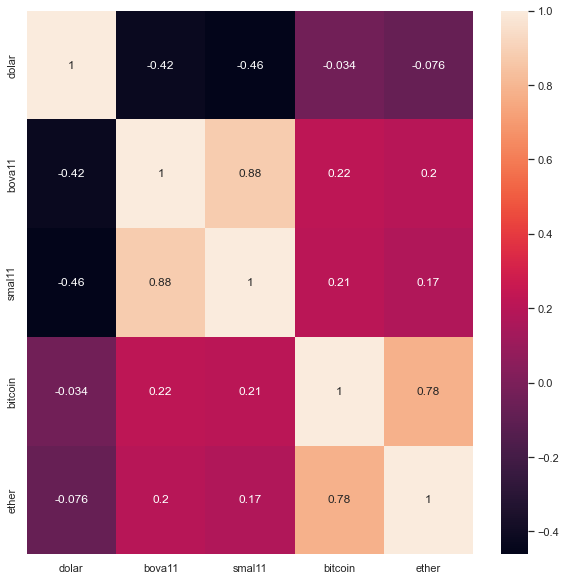

In [197]:
sns.heatmap(final_return.corr(), annot=True);

In [198]:
print(yhat_xgb_dolar_tunned.shape)
print(yhat_xgb_bova11_tunned.shape)
print(yhat_xgb_smal11_tunned.shape)
print(yhat_xgb_bitcoin_tunned.shape)
print(yhat_xgb_ether_tunned.shape)

(691, 1)
(514, 1)
(506, 1)
(731, 1)
(731, 1)


In [199]:
final_return_tunned = concat_final_return(yhat_xgb_dolar_tunned, yhat_xgb_bova11_tunned, yhat_xgb_smal11_tunned, yhat_xgb_bitcoin_tunned, yhat_xgb_ether_tunned)
final_return_tunned.head()

dolar   bova11   smal11  bitcoin    ether
date                                                   
2021-07-19  0.02679 -0.01117 -0.01465 -0.02745 -0.04036
2021-07-18 -0.00521  0.00000  0.00000  0.01958  0.00897
2021-07-17 -0.00523  0.00000  0.00000  0.01609  0.01320
2021-07-16 -0.00469 -0.01173 -0.00846  0.01106 -0.01001
2021-07-15  0.00224 -0.00884 -0.00828 -0.03489 -0.04254

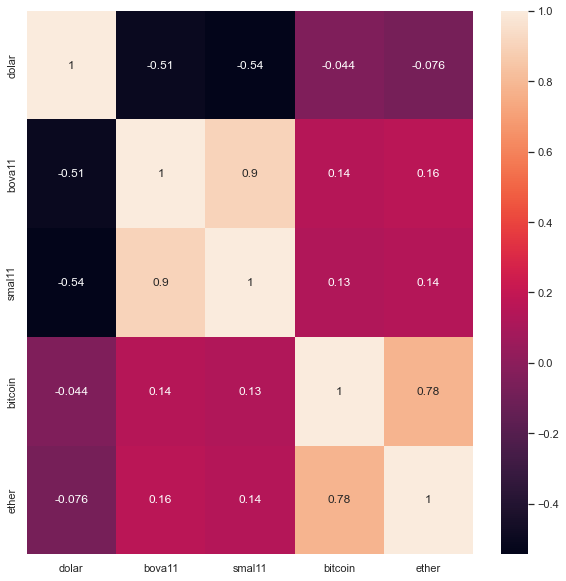

In [200]:
sns.heatmap(final_return_tunned.corr(), annot=True);

In [201]:
print('negative:', yhat_xgb_dolar.loc[yhat_xgb_dolar.daily_return_pct < 0 ].shape[0],'positive:', yhat_xgb_dolar.loc[yhat_xgb_dolar.daily_return_pct > 0 ].shape[0])
print('negative:', yhat_xgb_bova11.loc[yhat_xgb_bova11.daily_return_pct < 0 ].shape[0],'positive:', yhat_xgb_bova11.loc[yhat_xgb_bova11.daily_return_pct > 0 ].shape[0])
print('negative:', yhat_xgb_smal11.loc[yhat_xgb_smal11.daily_return_pct < 0 ].shape[0],'positive:', yhat_xgb_smal11.loc[yhat_xgb_smal11.daily_return_pct > 0 ].shape[0])
print('negative:', yhat_xgb_bitcoin.loc[yhat_xgb_bitcoin.daily_return_pct < 0 ].shape[0],'positive:', yhat_xgb_bitcoin.loc[yhat_xgb_bitcoin.daily_return_pct > 0 ].shape[0])
print('negative:', yhat_xgb_ether.loc[yhat_xgb_ether.daily_return_pct < 0 ].shape[0],'positive:', yhat_xgb_ether.loc[yhat_xgb_ether.daily_return_pct > 0 ].shape[0])

negative: 391 positive: 300
negative: 254 positive: 260
negative: 236 positive: 270
negative: 354 positive: 377
negative: 337 positive: 394


In [202]:
def monte_carlo(full_return_pct, num_portfolios):
    # Requeried inputs
    yearly_mean_return = full_return_pct.mean() *252
    daily_cov = full_return_pct.cov()
    yearly_cov = daily_cov*252
    num_assets = full_return_pct.shape[1]
    num_portfolios = num_portfolios
    
    port_returns = []
    port_volatility = []
    stock_weights = []
    for single_portfolio in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        returns = np.dot(weights, yearly_mean_return)
        volatility = np.sqrt(np.dot(weights.T, np.dot(yearly_cov, weights)))
        
        # # Monte Carlo's output
        port_returns.append(returns)
        port_volatility.append(volatility)
        stock_weights.append(weights)
        
    # Create dict for final dataframe
    portfolio = {'returns': port_returns, 'volatility': port_volatility, 'return_risk_ratio': ((value/ port_volatility[count]) for count, value in enumerate(port_returns))}
    # Create weight columns
    for counter, symbol in enumerate(full_return_pct.columns):
        portfolio[symbol + '_weight'] = [weight[counter] for weight in stock_weights]
    # Create final dataframe
    port = pd.DataFrame(portfolio)
    port.sort_values(by='return_risk_ratio', ascending=False, inplace=True)
    
    return port


In [203]:
simulation_portfolios = monte_carlo(final_return, 100000)
best_port = simulation_portfolios.iloc[[0]]
simulation_portfolios.head()

returns  volatility  return_risk_ratio  dolar_weight  bova11_weight  smal11_weight  bitcoin_weight  ether_weight
64341  0.28986     0.14780            1.96118       0.56354        0.03204        0.26732         0.00162       0.13548
44475  0.35645     0.18194            1.95911       0.53401        0.03847        0.23511         0.00134       0.19107
73986  0.29252     0.15001            1.94999       0.52867        0.08298        0.24657         0.00787       0.13392
62689  0.28515     0.14642            1.94745       0.49892        0.12200        0.24942         0.00126       0.12838
74519  0.27399     0.14070            1.94739       0.51810        0.01107        0.34838         0.00603       0.11642

In [204]:
simulation_portfolios_tunned = monte_carlo(final_return_tunned, 100000)
best_port_tunned = simulation_portfolios_tunned.iloc[[0]]
simulation_portfolios_tunned.head()

returns  volatility  return_risk_ratio  dolar_weight  bova11_weight  smal11_weight  bitcoin_weight  ether_weight
89374  3.73086     0.57480            6.49075       0.02320        0.01474        0.00048         0.94147       0.02011
88074  3.70789     0.57676            6.42887       0.01824        0.01367        0.00822         0.87229       0.08758
98720  3.38150     0.52677            6.41926       0.00410        0.02407        0.09609         0.85093       0.02482
24064  3.71610     0.58488            6.35363       0.00199        0.00743        0.02683         0.80097       0.16279
42477  3.47375     0.54720            6.34824       0.01510        0.01433        0.06526         0.79667       0.10864

De acordo com nossa Simulação de Monte Carlo, em que criamos 100 mil portfólios com alocação aleatória, o melhor portfólio, aquele com maior `return_risk_ratio`, possui o Bitcoin como o ativo com maior alocação, seguido pelo Smal11, principalmente.

O fato curioso a se destacar é que a mistura do Bitcoin com os demais ativos fez com que a volatidade do conjunto da carteira fosse menor do que uma carteira exclusivamente dominada por criptomoedas. Isso pode ser evidenciados quando elecarmos os portfólios somente pela rentabilidade, de modo que, ainda que possuam as maiores rentabilidades, essas carteiras não possuem o maior `return_risk_ratio` ao passo que detém volatilidade mais elevadas. Vejamos a seguir:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


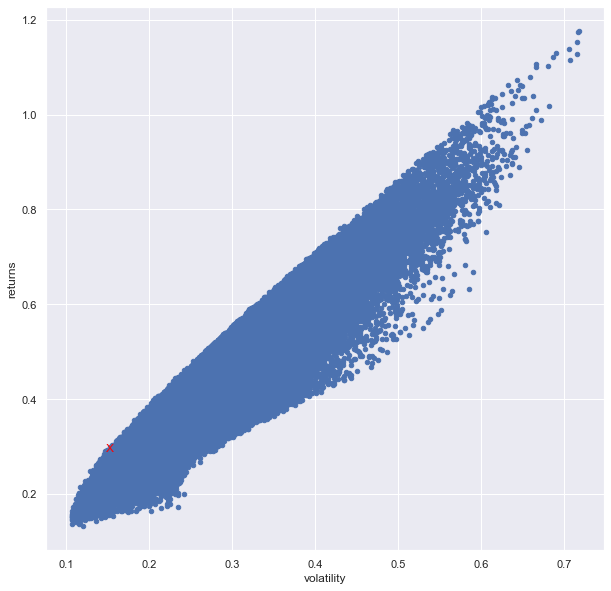

In [205]:
simulation_portfolios.plot.scatter(x='volatility', y='returns', figsize=(10,10), grid=True);
plt.annotate('X', (best_port['volatility'],best_port['returns']), color='red');

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


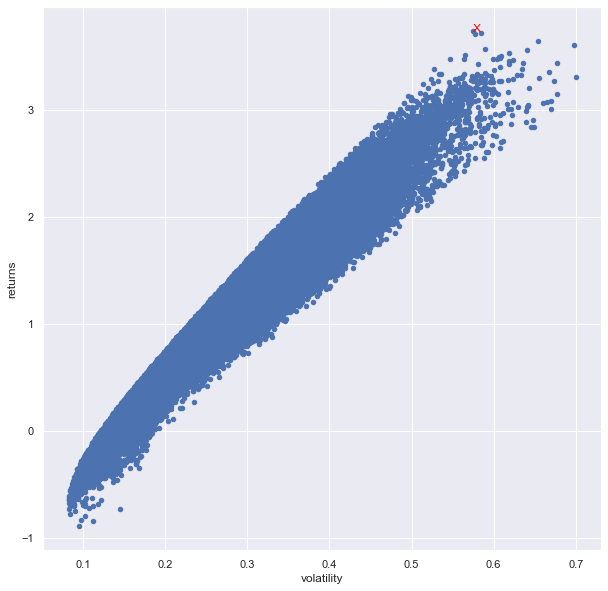

In [206]:
simulation_portfolios_tunned.plot.scatter(x='volatility', y='returns', figsize=(10,10), grid=True);
plt.annotate('X', (best_port_tunned['volatility'],best_port_tunned['returns']), color='red');

De acordo com nossa Simulação de Monte Carlo, em que criamos 100 mil portfólios com alocação aleatória, o melhor portfólio, aquele com maior `return_risk_ratio`, possui o Dolar como o ativo com maior alocação, seguido por Smal11 e Ether, respectivamente. 

Vale destacar que curiosamente as criptomoedas foram os ativos com menor alocação, possivelmente pelo fato de deterem uma alta `volatility`, o que influencia significativamente na redução do `return_risk_ratio`. 

Isso não significa, portanto, que as criptomoedas sejam ativos descartáveis. Isso é expresso, sobretudo, pelo fato delas possuiem a maior porção de alocação quando se trata de elecarmos os portfólios somente pela reantabilidade, principalmente o Ether. Vejamos:

In [207]:
simulation_portfolios.sort_values(by='returns', ascending=False).head()

returns  volatility  return_risk_ratio  dolar_weight  bova11_weight  smal11_weight  bitcoin_weight  ether_weight
50144  1.17556     0.71749            1.63844       0.00414        0.08763        0.00456         0.06578       0.83790
32779  1.17498     0.71633            1.64028       0.05248        0.00829        0.03030         0.07140       0.83754
39796  1.15377     0.71562            1.61226       0.04828        0.01696        0.00371         0.13425       0.79680
92122  1.13750     0.70539            1.61258       0.04735        0.01307        0.02102         0.13693       0.78164
79166  1.13017     0.69010            1.63769       0.04717        0.03483        0.03898         0.08492       0.79410

In [208]:
simulation_portfolios_tunned.sort_values(by='returns', ascending=False).head()

returns  volatility  return_risk_ratio  dolar_weight  bova11_weight  smal11_weight  bitcoin_weight  ether_weight
89374  3.73086     0.57480            6.49075       0.02320        0.01474        0.00048         0.94147       0.02011
24064  3.71610     0.58488            6.35363       0.00199        0.00743        0.02683         0.80097       0.16279
88074  3.70789     0.57676            6.42887       0.01824        0.01367        0.00822         0.87229       0.08758
72421  3.64300     0.65374            5.57253       0.01658        0.00627        0.00062         0.42315       0.55338
96484  3.60762     0.69767            5.17093       0.00447        0.01691        0.00059         0.25359       0.72445

Entretanto, imaginemos o cenário em que o cliente **não** esteja interessado em aportar mais de metade do seu investimento **somente** num ativo (aqui especificamente o Bitcoin). Vejamos o cenário quando o Bitcoin é extraído:

In [209]:
simulation_portfolios_without_dolar = monte_carlo(final_return[['bova11', 'smal11', 'bitcoin', 'ether']], 100000)
best_port_no_dolar = simulation_portfolios_without_dolar.iloc[0]
simulation_portfolios_without_dolar.head()

returns  volatility  return_risk_ratio  bova11_weight  smal11_weight  bitcoin_weight  ether_weight
31867  0.75604     0.44147            1.71255        0.00107        0.50045         0.00303       0.49545
80910  0.72988     0.42636            1.71188        0.00089        0.52335         0.00288       0.47288
49981  0.77931     0.45544            1.71112        0.00246        0.47749         0.00524       0.51481
35957  0.77624     0.45374            1.71077        0.05809        0.42596         0.00139       0.51456
81068  0.72401     0.42333            1.71027        0.01773        0.51062         0.00390       0.46776

É possível evidenciar que, com a retirada do Dólar, houve a concentração da alocação no Smal11 e no Ether, os ativos que já prevaleciam na simulação anterior, enquanto o Bova11 e o Bitcoin perdem a primazia.

In [210]:
simulation_portfolios_without_bit = monte_carlo(final_return_tunned[['bova11', 'smal11', 'dolar', 'ether']], 100000)
best_port_no_bit = simulation_portfolios_without_bit.iloc[0]
simulation_portfolios_without_bit.head()

returns  volatility  return_risk_ratio  bova11_weight  smal11_weight  dolar_weight  ether_weight
39824  3.33350     0.73660            4.52554        0.01381        0.03896       0.01733       0.92990
57251  3.31181     0.73439            4.50964        0.01193        0.02567       0.03449       0.92790
41534  3.19100     0.70864            4.50299        0.01337        0.07883       0.01473       0.89307
63852  3.16576     0.70483            4.49150        0.06776        0.03276       0.01187       0.88760
30559  3.12348     0.69542            4.49149        0.05862        0.06352       0.00310       0.87475

É possível evidenciar que, com a retirada do Bitcoin, há uma preponderância da alocação no Dolar, acompanhado pelo Smal11 e o Ether. Tal medida pode apontar para estratégias de diversificação de investimento, com aplicações em ativos de diferentes teores.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


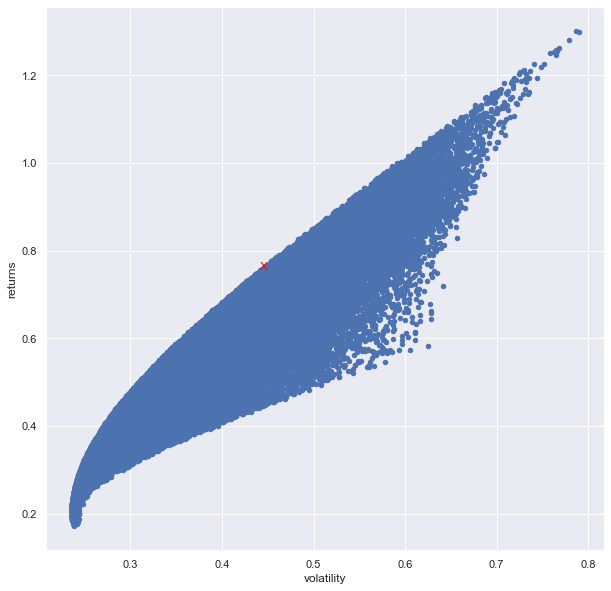

In [211]:
simulation_portfolios_without_dolar.plot.scatter(x='volatility', y='returns', figsize=(10,10), grid=True);
plt.annotate('X', (best_port_no_dolar['volatility'],best_port_no_dolar['returns']), color='red');

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


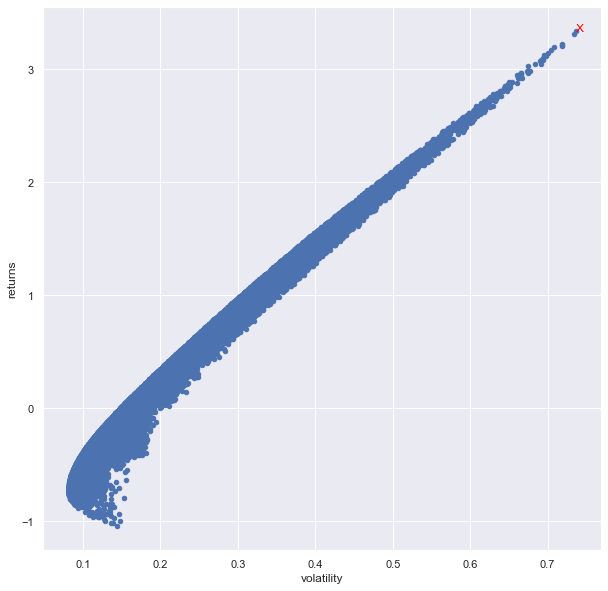

In [212]:
simulation_portfolios_without_bit.plot.scatter(x='volatility', y='returns', figsize=(10,10), grid=True);
plt.annotate('X', (best_port_no_bit['volatility'],best_port_no_bit['returns']), color='red');

Nossa simulação de Monte Carlo apontou algo que já podíamos imaginar a partir da Análise Exploratória de Dados: a prevalência de rentabilidade das criptomoeda. Pelo resultado da simulação, pode-se notar que os portfolio ideias majoritariamente formados pelo Bitcoin e pelo Ether, de modo que nenhum outro ativo ultrapassou 10% de composição da carteira.

Essa prevalência das criptomoedas faz com que a rentabilidade seja bastante significa, assim como o risco seja bastante acentuado. Assim sendo, lançaremos mão da visualização da Fronteira Eficiente precisamente para identificar alguns portfólios que otimizam essa relação entre retorno e risco.

### 9.2 Portfolio Comparison

Aqui iremos calcular o retorno esperado da melhor carteira eleita pela Simulação de Monte Carlo. Com ela, podemos calcular o retorno acumulado esperado e compará-lo com os demais ativos individualmente.

In [213]:
final_return_tunned.head()

dolar   bova11   smal11  bitcoin    ether
date                                                   
2021-07-19  0.02679 -0.01117 -0.01465 -0.02745 -0.04036
2021-07-18 -0.00521  0.00000  0.00000  0.01958  0.00897
2021-07-17 -0.00523  0.00000  0.00000  0.01609  0.01320
2021-07-16 -0.00469 -0.01173 -0.00846  0.01106 -0.01001
2021-07-15  0.00224 -0.00884 -0.00828 -0.03489 -0.04254

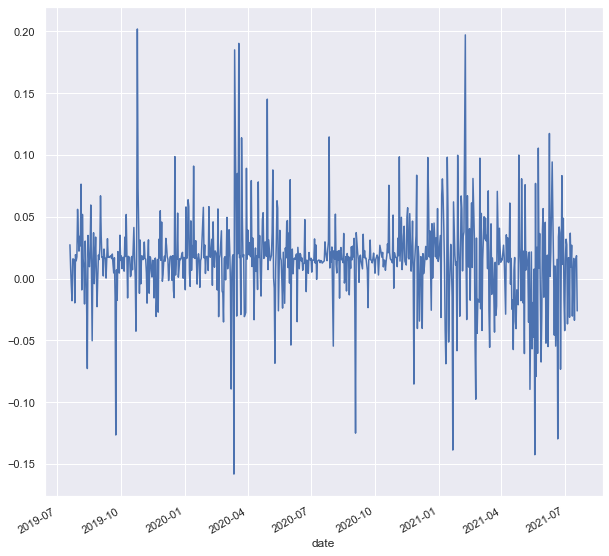

In [214]:
weights = np.array(best_port_tunned.drop(['returns', 'volatility', 'return_risk_ratio'], axis=1))
# Calculate expected return
expected_return = final_return_tunned * weights
# Sum all the portfolio assets daily return
expected_return = expected_return.sum(axis=1)
expected_return.plot();

In [215]:
# Calculate acumulated expected returns
acm_expected_returns = pd.DataFrame((1 + expected_return).cumprod())
acm_expected_returns.columns = ['best_port']

# Calculate acumulated predicted returns for all assets
all_assets_acm_return = (1 + final_return).cumprod()

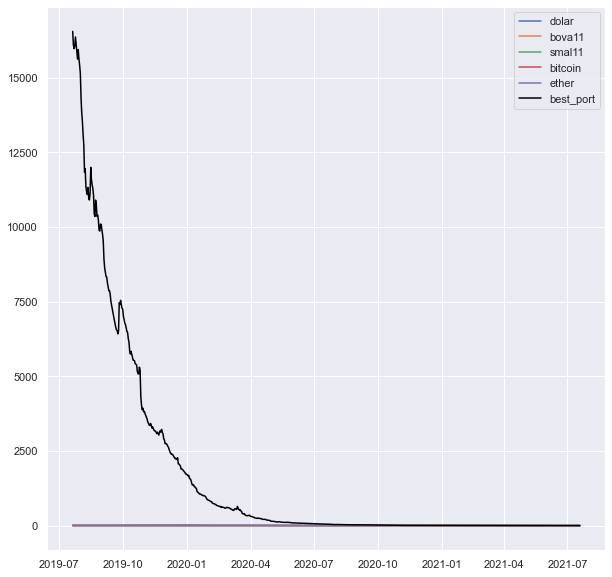

In [216]:
# WITH BITCOIN AND ETHER
plt.plot(all_assets_acm_return.index,all_assets_acm_return['dolar'], label='dolar');
plt.plot(all_assets_acm_return.index,all_assets_acm_return['bova11'], label='bova11');
plt.plot(all_assets_acm_return.index,all_assets_acm_return['smal11'], label='smal11');
plt.plot(all_assets_acm_return.index,all_assets_acm_return['bitcoin'], label='bitcoin');
plt.plot(all_assets_acm_return.index,all_assets_acm_return['ether'], label='ether');

plt.plot(acm_expected_returns.index,acm_expected_returns['best_port'], label='best_port', color='black');
plt.legend();

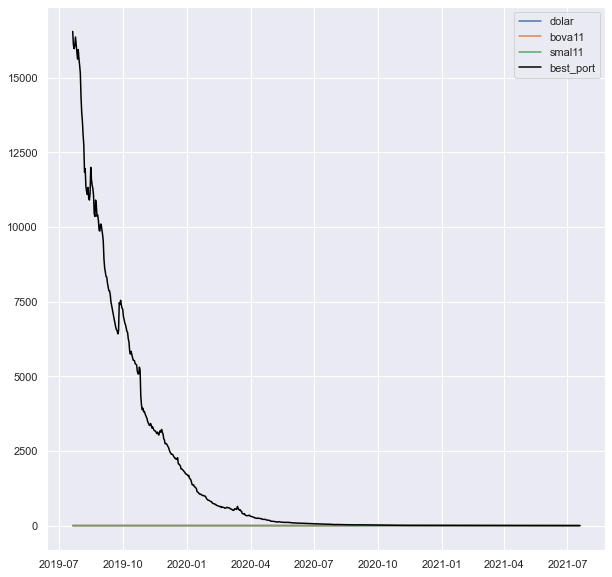

In [217]:
# WITHOUT BITCOIN AND ETHER
plt.plot(all_assets_acm_return.index,all_assets_acm_return['dolar'], label='dolar');
plt.plot(all_assets_acm_return.index,all_assets_acm_return['bova11'], label='bova11');
plt.plot(all_assets_acm_return.index,all_assets_acm_return['smal11'], label='smal11');
# plt.plot(all_assets_acm_return.index,all_assets_acm_return['bitcoin'], label='bitcoin');
# plt.plot(all_assets_acm_return.index,all_assets_acm_return['ether'], label='ether');

plt.plot(acm_expected_returns.index,acm_expected_returns['best_port'], label='best_port', color='black');
plt.legend();

Vamos observar com mais proxidade o movimento dos ativos no ano de 2021

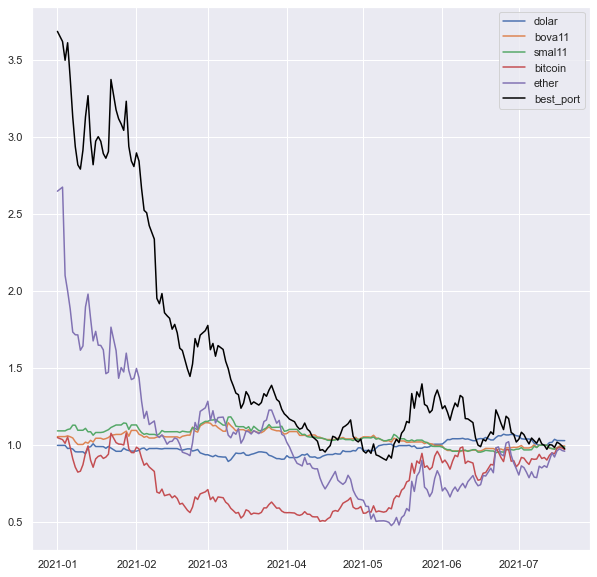

In [218]:
# ONLY 2021
plt.plot(all_assets_acm_return.index[all_assets_acm_return.index.year>=2021],all_assets_acm_return[all_assets_acm_return.index.year>=2021]['dolar'], label='dolar');
plt.plot(all_assets_acm_return.index[all_assets_acm_return.index.year>=2021],all_assets_acm_return[all_assets_acm_return.index.year>=2021]['bova11'], label='bova11');
plt.plot(all_assets_acm_return.index[all_assets_acm_return.index.year>=2021],all_assets_acm_return[all_assets_acm_return.index.year>=2021]['smal11'], label='smal11');
plt.plot(all_assets_acm_return.index[all_assets_acm_return.index.year>=2021],all_assets_acm_return[all_assets_acm_return.index.year>=2021]['bitcoin'], label='bitcoin');
plt.plot(all_assets_acm_return.index[all_assets_acm_return.index.year>=2021],all_assets_acm_return[all_assets_acm_return.index.year>=2021]['ether'], label='ether');

plt.plot(acm_expected_returns.index[acm_expected_returns.index.year>=2021],acm_expected_returns[acm_expected_returns.index.year>=2021]['best_port'], label='best_port', color='black');
plt.legend();

# 10.0 Deploy